## Unsupervised Learning Trading Strategy


* Download/Load NIFTY50 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization OR equal weighted.
* Visualize Portfolio returns and compare to NIFTY50 returns

### All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

### 1. Download/Load Nifty50 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np #The Numpy numerical computing library
import pandas as pd #The Pandas data science library
import requests #The requests library for HTTP requests in Python
import xlsxwriter #The XlsxWriter libarary for 
import math #The Python math module
from scipy import stats #The SciPy stats module
import yfinance as yf
import datetime as dt
import pandas_ta 
import matplotlib.pyplot as plt 

In [34]:
nifty_50_stocks = pd.read_html("https://en.wikipedia.org/wiki/NIFTY_50")[2]

nifty_50_stocks = nifty_50_stocks['Symbol'].add(".NS")

stocks = nifty_50_stocks.unique().tolist()

In [4]:
end = dt.date.today()
start = end - pd.Timedelta(days= 252*14)
end
start

datetime.date(2014, 4, 3)

In [5]:
stocks_df = yf.download(stocks, start, end).stack()

[*********************100%%**********************]  50 of 50 completed


In [6]:
df = stocks_df.copy()

df.columns = df.columns.str.lower()

df.index.names = ['date', 'ticker']

In [7]:
df

adj close        close         high          low  \
date       ticker                                                              
2014-04-03 ADANIENT.NS      49.679119    53.899174    55.102383    53.186443   
           ADANIPORTS.NS   172.129776   181.300003   187.800003   179.100006   
           APOLLOHOSP.NS   880.318787   914.400024   924.000000   900.000000   
           ASIANPAINT.NS   500.648773   538.599976   542.000000   523.549988   
           AXISBANK.NS     275.377625   286.970001   293.779999   285.619995   
...                               ...          ...          ...          ...   
2023-11-29 TECHM.NS       1221.699951  1221.699951  1234.599976  1206.650024   
           TITAN.NS       3429.300049  3429.300049  3473.850098  3424.000000   
           ULTRACEMCO.NS  8732.750000  8732.750000  8790.000000  8692.000000   
           UPL.NS          570.049988   570.049988   571.900024   563.099976   
           WIPRO.NS        406.250000   406.250000   408.549988   398.000000   

                                 open      volume  
date       ticker                                  
2014-04-03 ADANIENT.NS      54.995090  15944250.0  
           ADANIPORTS.NS   186.050003   2074961.0  
           APOLLOHOSP.NS   900.049988    262920.0  
           ASIANPAINT.NS   523.549988    960789.0  
           AXISBANK.NS     293.779999   5572305.0  
...                               ...         ...  
2023-11-29 TECHM.NS       1207.000000   1898448.0  
           TITAN.NS       3473.850098    819200.0  
           ULTRACEMCO.NS  8759.900391    207727.0  
           UPL.NS          565.000000   1780095.0  
           WIPRO.NS        398.000000   7772043.0  

[116690 rows x 6 columns]

###  2. Calculate features and technical indicators for each stock.


Garman-Klass Volatility

RSI

Bollinger Bands

ATR

MACD

Dollar Volume

In [8]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6


In [9]:
df

adj close        close         high          low  \
date       ticker                                                              
2014-04-03 ADANIENT.NS      49.679119    53.899174    55.102383    53.186443   
           ADANIPORTS.NS   172.129776   181.300003   187.800003   179.100006   
           APOLLOHOSP.NS   880.318787   914.400024   924.000000   900.000000   
           ASIANPAINT.NS   500.648773   538.599976   542.000000   523.549988   
           AXISBANK.NS     275.377625   286.970001   293.779999   285.619995   
...                               ...          ...          ...          ...   
2023-11-29 TECHM.NS       1221.699951  1221.699951  1234.599976  1206.650024   
           TITAN.NS       3429.300049  3429.300049  3473.850098  3424.000000   
           ULTRACEMCO.NS  8732.750000  8732.750000  8790.000000  8692.000000   
           UPL.NS          570.049988   570.049988   571.900024   563.099976   
           WIPRO.NS        406.250000   406.250000   408.549988   398.000000   

                                 open      volume  garman_klass_vol  \
date       ticker                                                     
2014-04-03 ADANIENT.NS      54.995090  15944250.0         -0.003366   
           ADANIPORTS.NS   186.050003   2074961.0         -0.001211   
           APOLLOHOSP.NS   900.049988    262920.0          0.000156   
           ASIANPAINT.NS   523.549988    960789.0         -0.000173   
           AXISBANK.NS     293.779999   5572305.0         -0.001220   
...                               ...         ...               ...   
2023-11-29 TECHM.NS       1207.000000   1898448.0          0.000206   
           TITAN.NS       3473.850098    819200.0          0.000040   
           ULTRACEMCO.NS  8759.900391    207727.0          0.000059   
           UPL.NS          565.000000   1780095.0          0.000090   
           WIPRO.NS        398.000000   7772043.0          0.000180   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2014-04-03 ADANIENT.NS          NaN       NaN       NaN       NaN       NaN   
           ADANIPORTS.NS        NaN       NaN       NaN       NaN       NaN   
           APOLLOHOSP.NS        NaN       NaN       NaN       NaN       NaN   
           ASIANPAINT.NS        NaN       NaN       NaN       NaN       NaN   
           AXISBANK.NS          NaN       NaN       NaN       NaN       NaN   
...                             ...       ...       ...       ...       ...   
2023-11-29 TECHM.NS       58.874528  6.996486  7.063125  7.129765  0.138146   
           TITAN.NS       63.926733  8.058098  8.106388  8.154678  1.116550   
           ULTRACEMCO.NS  57.265108  9.037609  9.064815  9.092020  0.388684   
           UPL.NS         48.154019  6.286673  6.321048  6.355424 -1.151796   
           WIPRO.NS       57.050679  5.924888  5.969576  6.014264 -0.192716   

                              macd  dollar_volume  
date       ticker                                  
2014-04-03 ADANIENT.NS         NaN     792.096295  
           ADANIPORTS.NS       NaN     357.162572  
           APOLLOHOSP.NS       NaN     231.453415  
           ASIANPAINT.NS       NaN     481.017834  
           AXISBANK.NS         NaN    1534.488114  
...                            ...            ...  
2023-11-29 TECHM.NS       0.601109    2319.333829  
           TITAN.NS       1.590522    2809.282600  
           ULTRACEMCO.NS  0.704802    1814.027959  
           UPL.NS        -0.526791    1014.743133  
           WIPRO.NS       0.100612    3157.392469  

[116690 rows x 14 columns]

### 3. Aggregate to monthly level stocks for each month.

In [10]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume    adj close  garman_klass_vol  \
date       ticker                                                        
2014-05-31 ADANIENT.NS      2910.752445    67.656288          0.003386   
           ADANIPORTS.NS    1514.971671   215.992950          0.003929   
           APOLLOHOSP.NS     172.422784   873.868408         -0.000366   
           ASIANPAINT.NS     495.072992   471.833099         -0.001744   
           AXISBANK.NS      2542.987798   352.395416         -0.001046   
...                                 ...          ...               ...   
2023-11-30 TECHM.NS         1710.576050  1221.699951          0.000206   
           TITAN.NS         2702.232074  3429.300049          0.000040   
           ULTRACEMCO.NS    1769.034900  8732.750000          0.000059   
           UPL.NS            925.145968   570.049988          0.000090   
           WIPRO.NS         1519.022316   406.250000          0.000180   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2014-05-31 ADANIENT.NS    56.253127  4.064955  4.222889  4.380823 -0.544140   
           ADANIPORTS.NS  60.534423  5.179488  5.320677  5.461866 -0.305332   
           APOLLOHOSP.NS  47.122418  6.756866  6.795993  6.835120 -0.974654   
           ASIANPAINT.NS  42.648874  6.138339  6.193707  6.249075 -1.100101   
           AXISBANK.NS    72.082234  5.658768  5.807805  5.956842 -1.053107   
...                             ...       ...       ...       ...       ...   
2023-11-30 TECHM.NS       58.874528  6.996486  7.063125  7.129765  0.138146   
           TITAN.NS       63.926733  8.058098  8.106388  8.154678  1.116550   
           ULTRACEMCO.NS  57.265108  9.037609  9.064815  9.092020  0.388684   
           UPL.NS         48.154019  6.286673  6.321048  6.355424 -1.151796   
           WIPRO.NS       57.050679  5.924888  5.969576  6.014264 -0.192716   

                              macd  
date       ticker                   
2014-05-31 ADANIENT.NS   -0.075411  
           ADANIPORTS.NS  0.446742  
           APOLLOHOSP.NS -0.161082  
           ASIANPAINT.NS -0.330673  
           AXISBANK.NS    1.212561  
...                            ...  
2023-11-30 TECHM.NS       0.601109  
           TITAN.NS       1.590522  
           ULTRACEMCO.NS  0.704802  
           UPL.NS        -0.526791  
           WIPRO.NS       0.100612  

[5638 rows x 9 columns]

#### Calculate 5-year rolling average of dollar volume for each stocks.

In [11]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data.drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2014-05-31 ADANIENT.NS      67.656288          0.003386  56.253127  4.064955   
           ADANIPORTS.NS   215.992950          0.003929  60.534423  5.179488   
           APOLLOHOSP.NS   873.868408         -0.000366  47.122418  6.756866   
           ASIANPAINT.NS   471.833099         -0.001744  42.648874  6.138339   
           AXISBANK.NS     352.395416         -0.001046  72.082234  5.658768   
...                               ...               ...        ...       ...   
2023-11-30 TECHM.NS       1221.699951          0.000206  58.874528  6.996486   
           TITAN.NS       3429.300049          0.000040  63.926733  8.058098   
           ULTRACEMCO.NS  8732.750000          0.000059  57.265108  9.037609   
           UPL.NS          570.049988          0.000090  48.154019  6.286673   
           WIPRO.NS        406.250000          0.000180  57.050679  5.924888   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2014-05-31 ADANIENT.NS    4.222889  4.380823 -0.544140 -0.075411  
           ADANIPORTS.NS  5.320677  5.461866 -0.305332  0.446742  
           APOLLOHOSP.NS  6.795993  6.835120 -0.974654 -0.161082  
           ASIANPAINT.NS  6.193707  6.249075 -1.100101 -0.330673  
           AXISBANK.NS    5.807805  5.956842 -1.053107  1.212561  
...                            ...       ...       ...       ...  
2023-11-30 TECHM.NS       7.063125  7.129765  0.138146  0.601109  
           TITAN.NS       8.106388  8.154678  1.116550  1.590522  
           ULTRACEMCO.NS  9.064815  9.092020  0.388684  0.704802  
           UPL.NS         6.321048  6.355424 -1.151796 -0.526791  
           WIPRO.NS       5.969576  6.014264 -0.192716  0.100612  

[5638 rows x 8 columns]

### 4. Calculate Monthly Returns for different time horizons as features.

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method 
.pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [12]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2015-05-31 ADANIENT.NS     101.897827         -0.000714  49.770762  4.552744   
           ADANIPORTS.NS   309.617706         -0.001381  47.436018  5.735199   
           APOLLOHOSP.NS  1173.623901         -0.000182  43.408204  7.024781   
           ASIANPAINT.NS   739.291199          0.000017  50.941210  6.559241   
           AXISBANK.NS     567.601379          0.000161  57.656094  6.246517   
...                               ...               ...        ...       ...   
2023-11-30 TECHM.NS       1221.699951          0.000206  58.874528  6.996486   
           TITAN.NS       3429.300049          0.000040  63.926733  8.058098   
           ULTRACEMCO.NS  8732.750000          0.000059  57.265108  9.037609   
           UPL.NS          570.049988          0.000090  48.154019  6.286673   
           WIPRO.NS        406.250000          0.000180  57.050679  5.924888   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2015-05-31 ADANIENT.NS    4.673124  4.793505 -0.549146 -0.051168   0.047612   
           ADANIPORTS.NS  5.779461  5.823722 -0.453026  0.128134   0.023069   
           APOLLOHOSP.NS  7.090177  7.155573 -0.480156 -0.388860   0.066306   
           ASIANPAINT.NS  6.587045  6.614848 -0.810178 -0.382670   0.032264   
           AXISBANK.NS    6.298212  6.349907 -0.223515  0.320356   0.030997   
...                            ...       ...       ...       ...        ...   
2023-11-30 TECHM.NS       7.063125  7.129765  0.138146  0.601109   0.089768   
           TITAN.NS       8.106388  8.154678  1.116550  1.590522   0.075134   
           ULTRACEMCO.NS  9.064815  9.092020  0.388684  0.704802   0.036867   
           UPL.NS         6.321048  6.355424 -1.151796 -0.526791   0.054672   
           WIPRO.NS       5.969576  6.014264 -0.192716  0.100612   0.064039   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2015-05-31 ADANIENT.NS     0.071355  -0.002372   0.074494   0.044117   
           ADANIPORTS.NS   0.026697  -0.021016   0.018961   0.015511   
           APOLLOHOSP.NS  -0.058942  -0.023484   0.006539   0.003672   
           ASIANPAINT.NS  -0.015059  -0.008371   0.009261   0.026399   
           AXISBANK.NS     0.022245   0.010613   0.033208   0.044023   
...                             ...        ...        ...        ...   
2023-11-30 TECHM.NS        0.004924   0.009048   0.025919   0.018768   
           TITAN.NS        0.043591   0.033730   0.033499   0.042144   
           ULTRACEMCO.NS   0.028539   0.017190   0.018261   0.021231   
           UPL.NS         -0.038215  -0.012042  -0.027540  -0.019883   
           WIPRO.NS        0.000246  -0.001758   0.001071   0.005394   

                          return_12m  
date       ticker                     
2015-05-31 ADANIENT.NS      0.034717  
           ADANIPORTS.NS    0.030462  
           APOLLOHOSP.NS    0.024881  
           ASIANPAINT.NS    0.038131  
           AXISBANK.NS      0.040522  
...                              ...  
2023-11-30 TECHM.NS         0.015850  
           TITAN.NS         0.021895  
           ULTRACEMCO.NS    0.018060  
           UPL.NS          -0.025474  
           WIPRO.NS         0.000072  

[5038 rows x 14 columns]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5038 entries, (Timestamp('2015-05-31 00:00:00'), 'ADANIENT.NS') to (Timestamp('2023-11-30 00:00:00'), 'WIPRO.NS')
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   adj close         5038 non-null   float64
 1   garman_klass_vol  5038 non-null   float64
 2   rsi               5038 non-null   float64
 3   bb_low            5038 non-null   float64
 4   bb_mid            5038 non-null   float64
 5   bb_high           5038 non-null   float64
 6   atr               5038 non-null   float64
 7   macd              5038 non-null   float64
 8   return_1m         5038 non-null   float64
 9   return_2m         5038 non-null   float64
 10  return_3m         5038 non-null   float64
 11  return_6m         5038 non-null   float64
 12  return_9m         5038 non-null   float64
 13  return_12m        5038 non-null   float64
dtypes: float64(14)
memory usage: 568.4+ KB


### 5. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.


### K-Means Clustering

You may want to initialize predefined centroids for each cluster based on your research.

For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

Then we will pre-define our centroids for each cluster.

In [14]:
from sklearn.cluster import KMeans


### Apply pre-defined centroids.

In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 14))

initial_centroids[:, 2] = target_rsi_values

initial_centroids

array([[ 0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.],
       [ 0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]])

The initial centroids is locate the centre and separate the cluster based on the target rsi values. 

In [16]:
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df


In [17]:
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2015-05-31 ADANIENT.NS     101.897827         -0.000714  49.770762  4.552744   
           ADANIPORTS.NS   309.617706         -0.001381  47.436018  5.735199   
           APOLLOHOSP.NS  1173.623901         -0.000182  43.408204  7.024781   
           ASIANPAINT.NS   739.291199          0.000017  50.941210  6.559241   
           AXISBANK.NS     567.601379          0.000161  57.656094  6.246517   
...                               ...               ...        ...       ...   
2023-11-30 TECHM.NS       1221.699951          0.000206  58.874528  6.996486   
           TITAN.NS       3429.300049          0.000040  63.926733  8.058098   
           ULTRACEMCO.NS  8732.750000          0.000059  57.265108  9.037609   
           UPL.NS          570.049988          0.000090  48.154019  6.286673   
           WIPRO.NS        406.250000          0.000180  57.050679  5.924888   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2015-05-31 ADANIENT.NS    4.673124  4.793505 -0.549146 -0.051168   0.047612   
           ADANIPORTS.NS  5.779461  5.823722 -0.453026  0.128134   0.023069   
           APOLLOHOSP.NS  7.090177  7.155573 -0.480156 -0.388860   0.066306   
           ASIANPAINT.NS  6.587045  6.614848 -0.810178 -0.382670   0.032264   
           AXISBANK.NS    6.298212  6.349907 -0.223515  0.320356   0.030997   
...                            ...       ...       ...       ...        ...   
2023-11-30 TECHM.NS       7.063125  7.129765  0.138146  0.601109   0.089768   
           TITAN.NS       8.106388  8.154678  1.116550  1.590522   0.075134   
           ULTRACEMCO.NS  9.064815  9.092020  0.388684  0.704802   0.036867   
           UPL.NS         6.321048  6.355424 -1.151796 -0.526791   0.054672   
           WIPRO.NS       5.969576  6.014264 -0.192716  0.100612   0.064039   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2015-05-31 ADANIENT.NS     0.071355  -0.002372   0.074494   0.044117   
           ADANIPORTS.NS   0.026697  -0.021016   0.018961   0.015511   
           APOLLOHOSP.NS  -0.058942  -0.023484   0.006539   0.003672   
           ASIANPAINT.NS  -0.015059  -0.008371   0.009261   0.026399   
           AXISBANK.NS     0.022245   0.010613   0.033208   0.044023   
...                             ...        ...        ...        ...   
2023-11-30 TECHM.NS        0.004924   0.009048   0.025919   0.018768   
           TITAN.NS        0.043591   0.033730   0.033499   0.042144   
           ULTRACEMCO.NS   0.028539   0.017190   0.018261   0.021231   
           UPL.NS         -0.038215  -0.012042  -0.027540  -0.019883   
           WIPRO.NS        0.000246  -0.001758   0.001071   0.005394   

                          return_12m  cluster  
date       ticker                              
2015-05-31 ADANIENT.NS      0.034717        0  
           ADANIPORTS.NS    0.030462        0  
           APOLLOHOSP.NS    0.024881        2  
           ASIANPAINT.NS    0.038131        1  
           AXISBANK.NS      0.040522        1  
...                              ...      ...  
2023-11-30 TECHM.NS         0.015850        1  
           TITAN.NS         0.021895        2  
           ULTRACEMCO.NS    0.018060        3  
           UPL.NS          -0.025474        1  
           WIPRO.NS         0.000072        1  

[5038 rows x 15 columns]

In [18]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


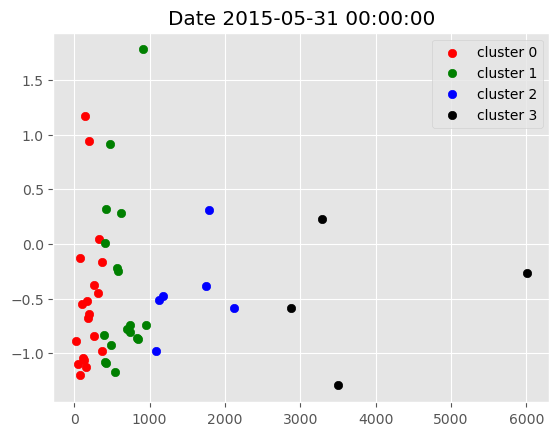

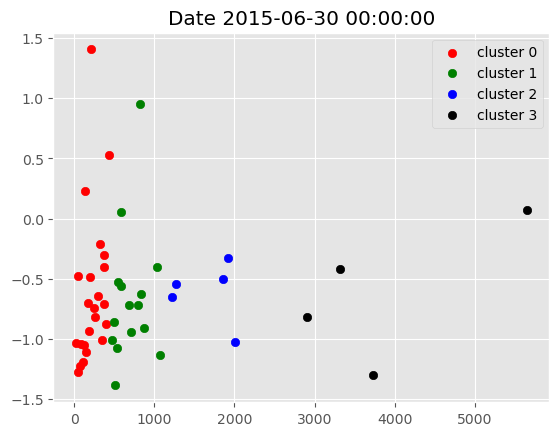

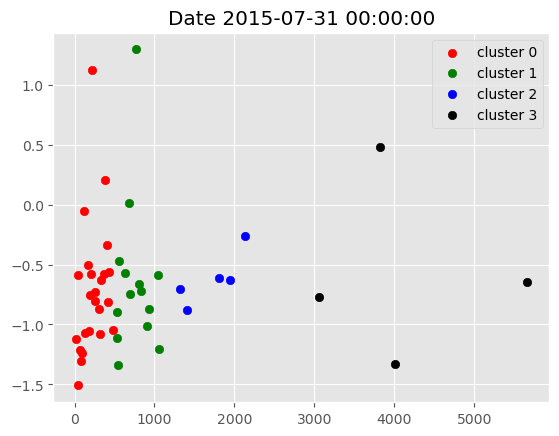

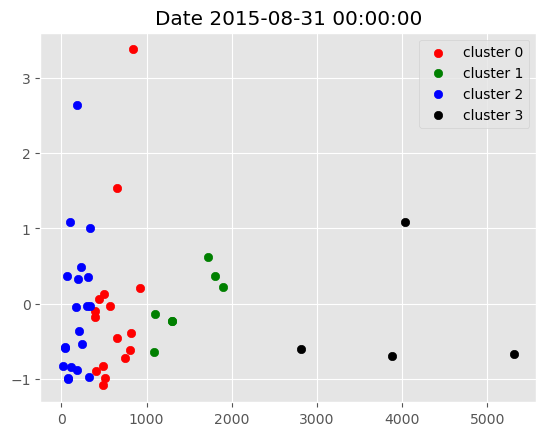

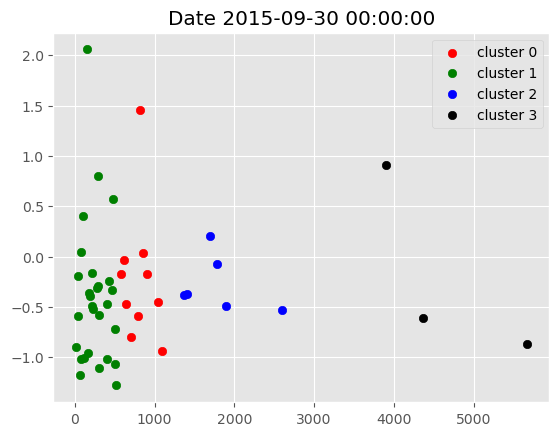

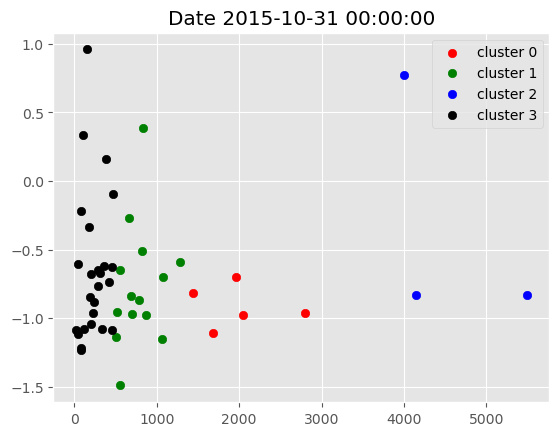

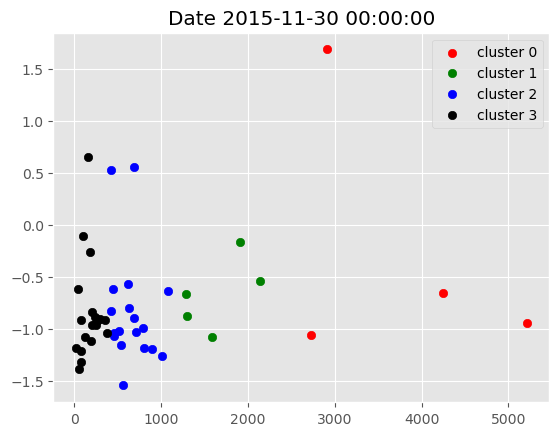

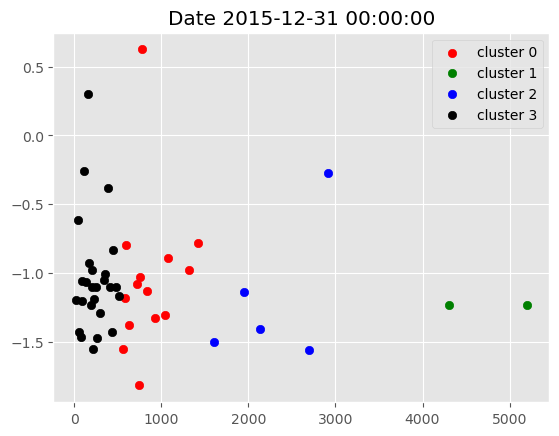

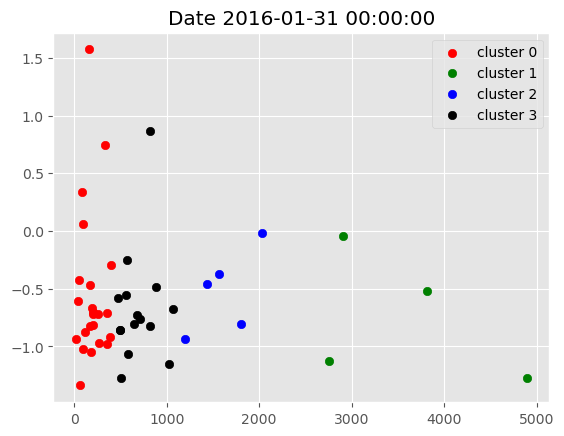

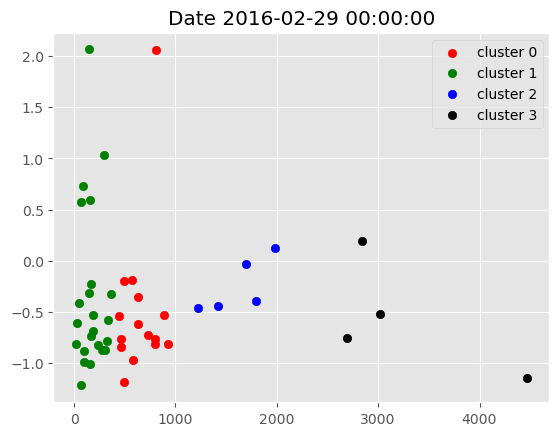

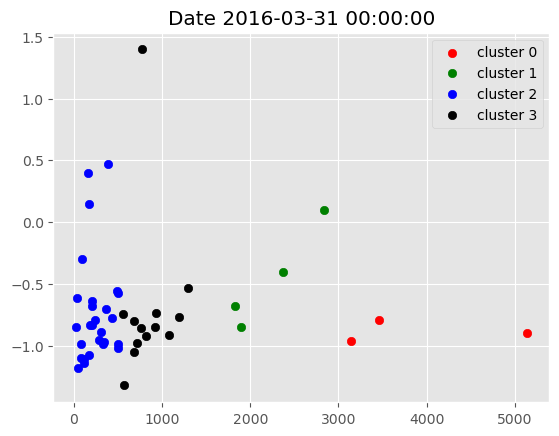

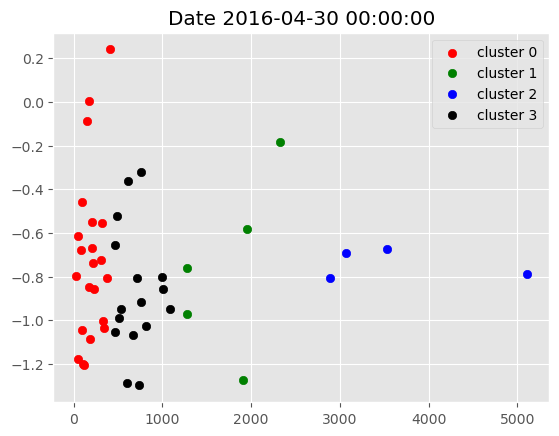

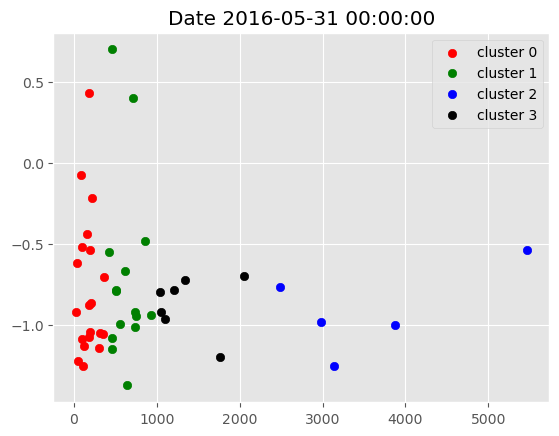

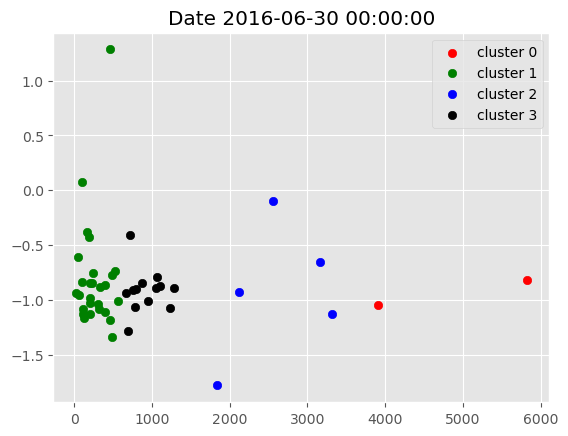

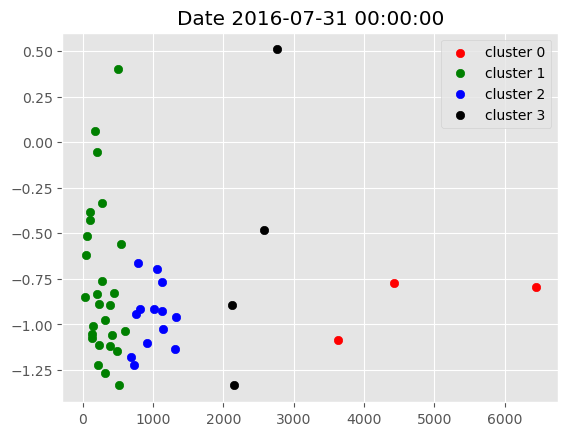

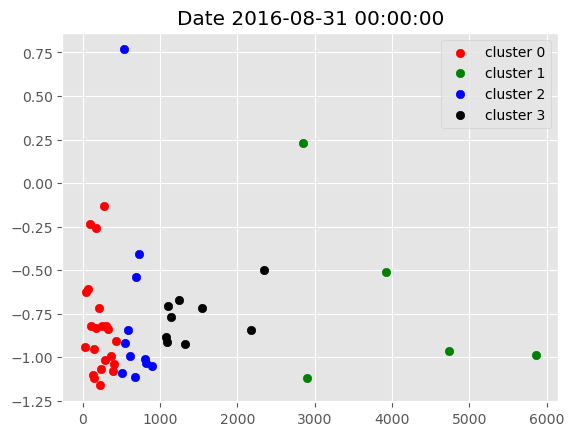

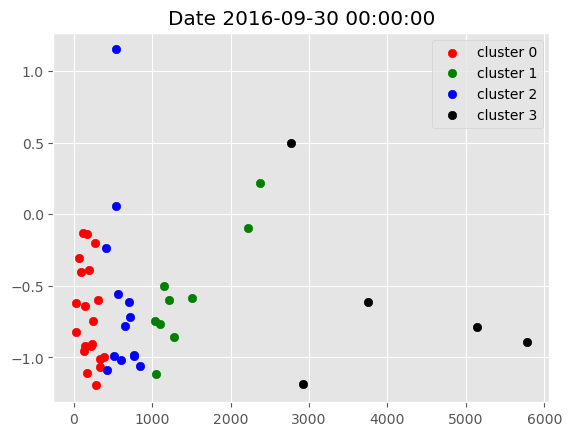

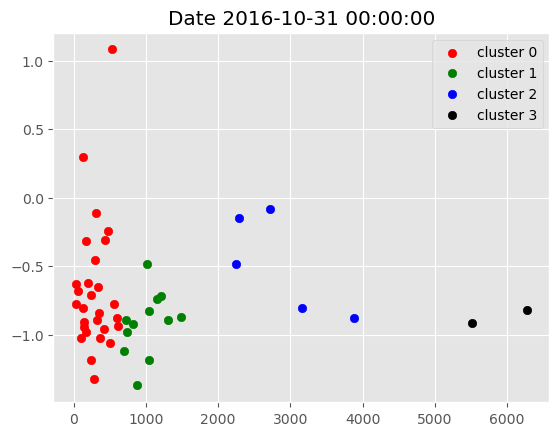

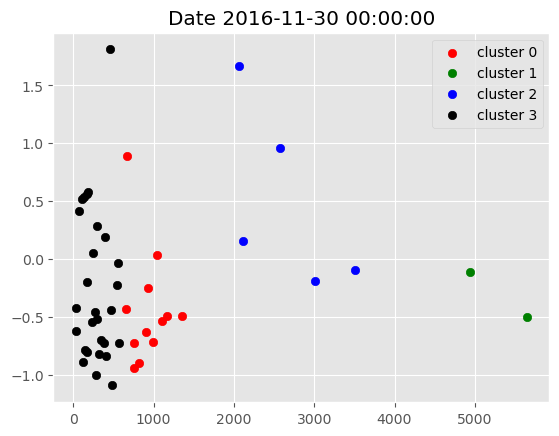

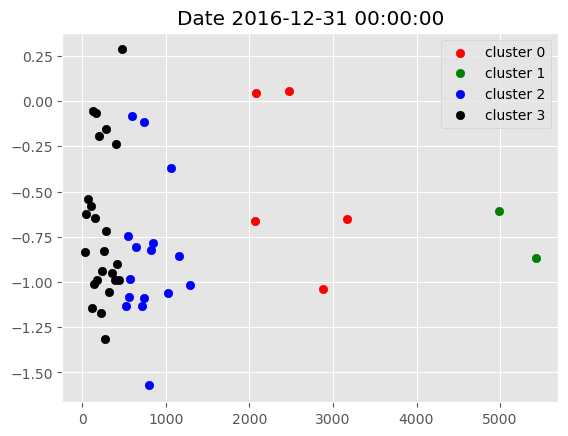

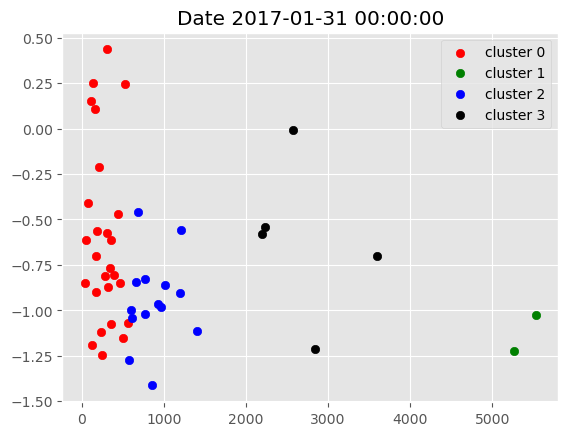

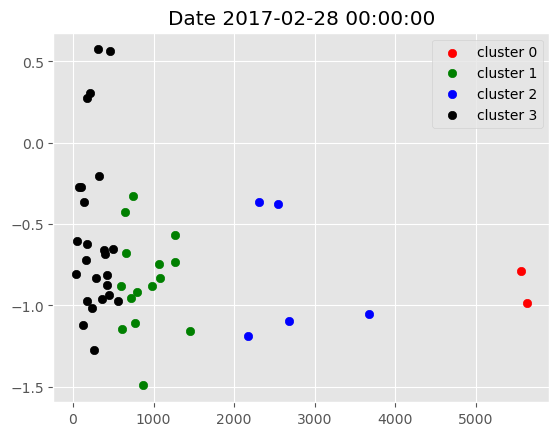

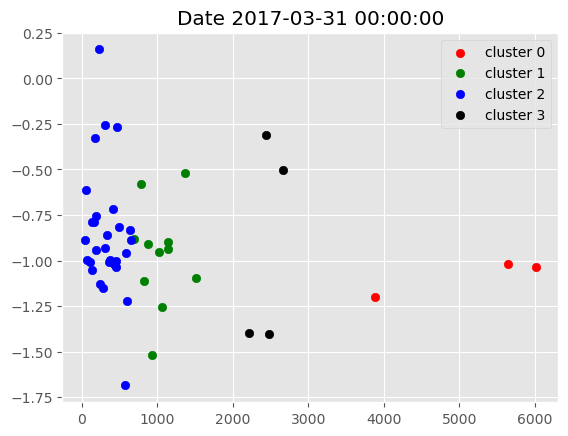

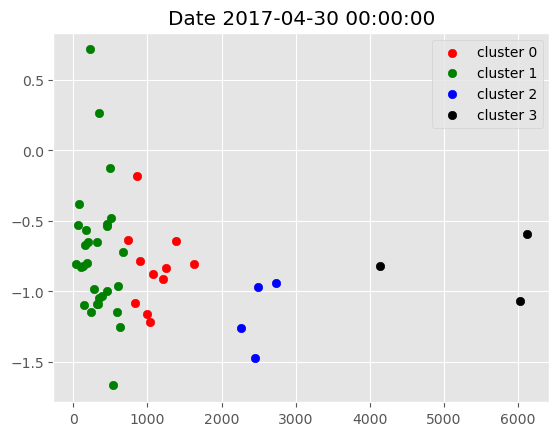

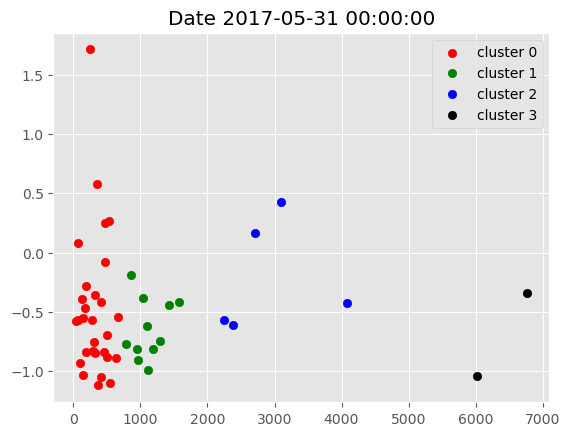

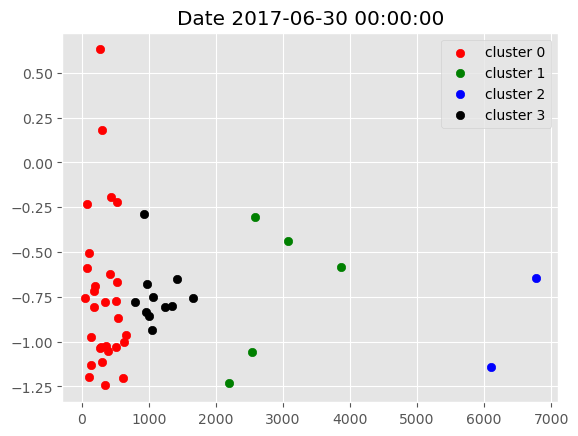

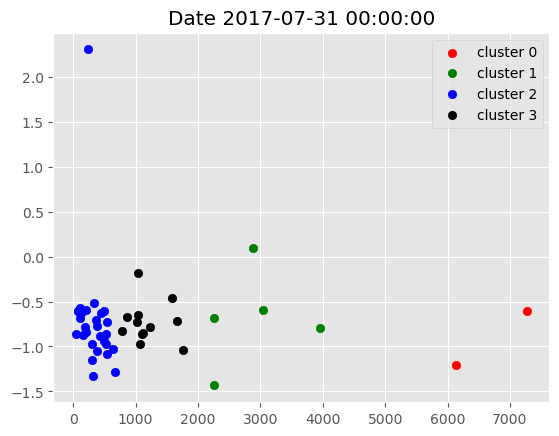

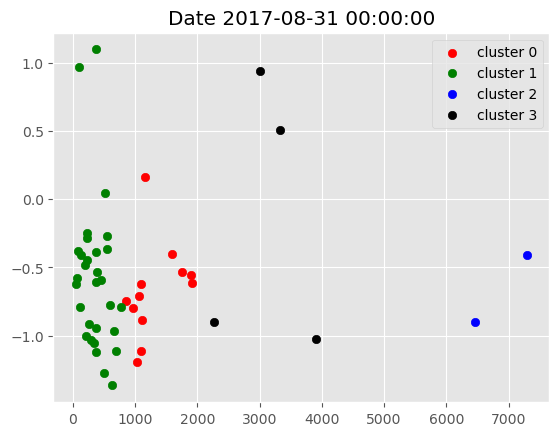

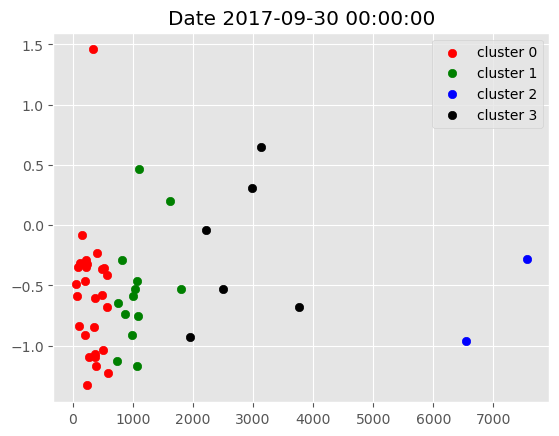

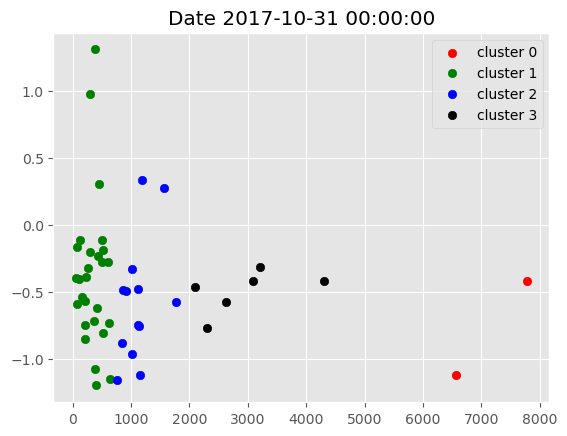

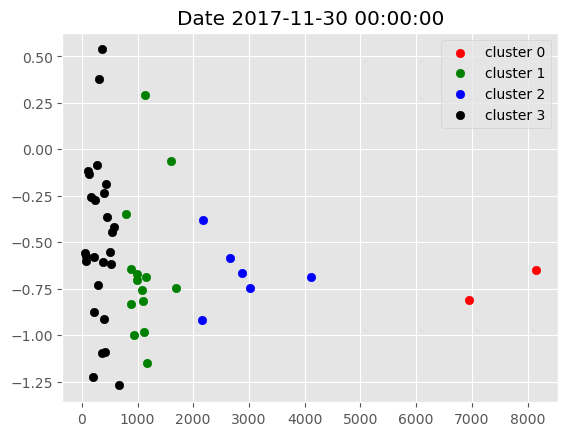

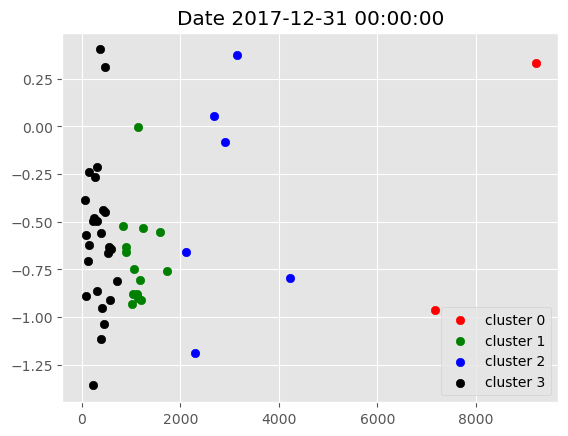

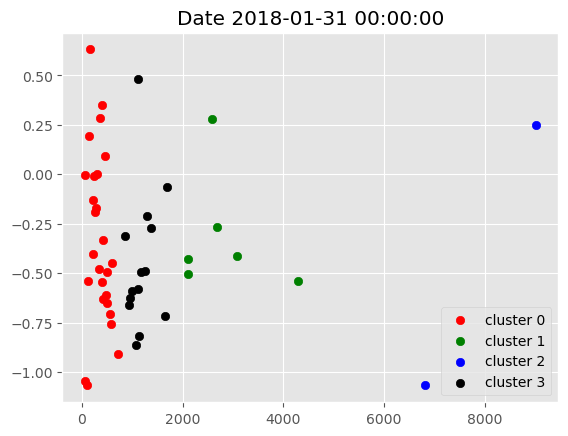

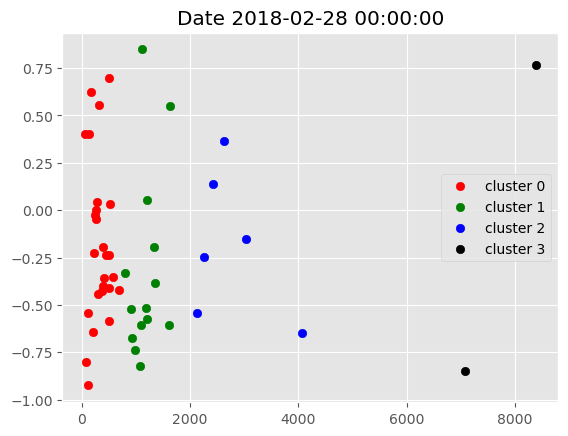

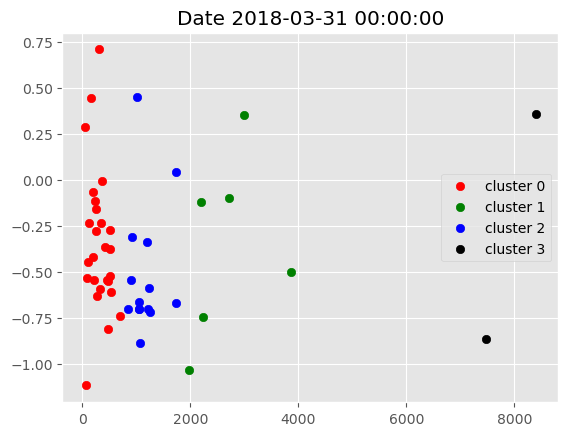

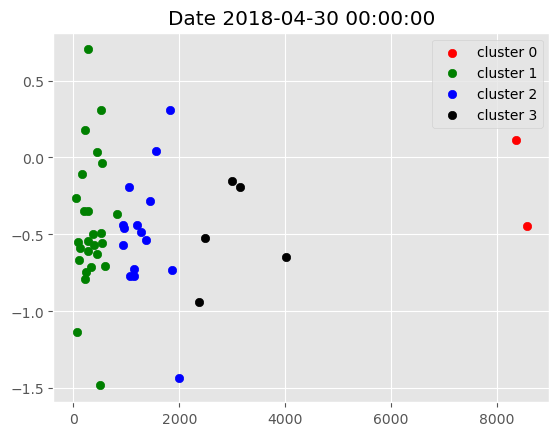

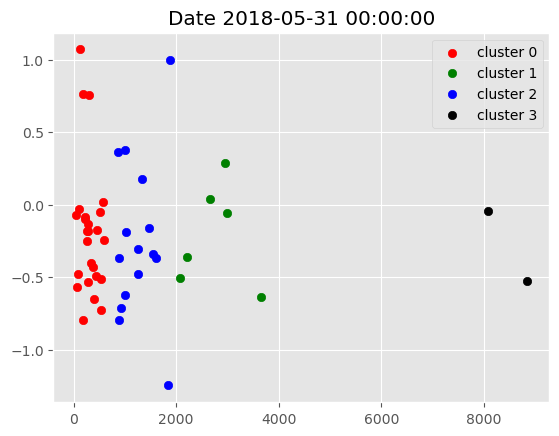

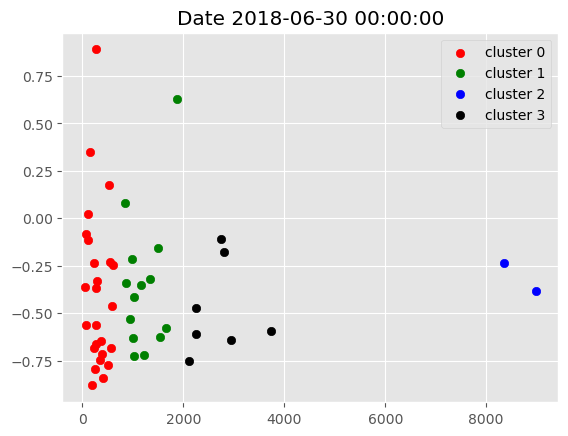

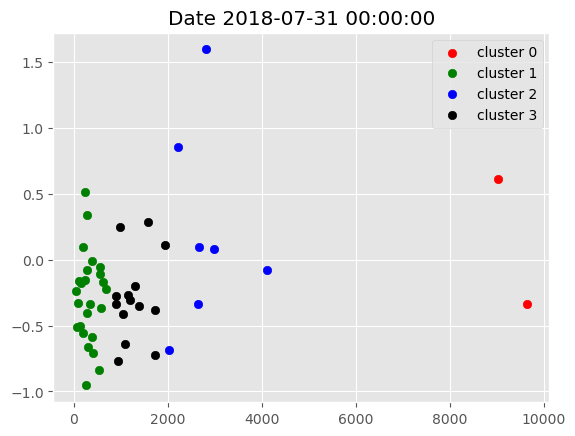

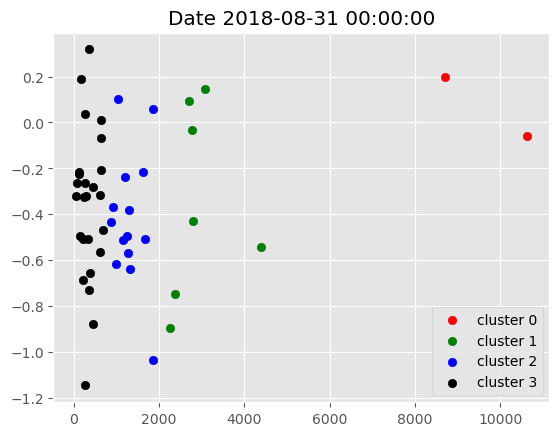

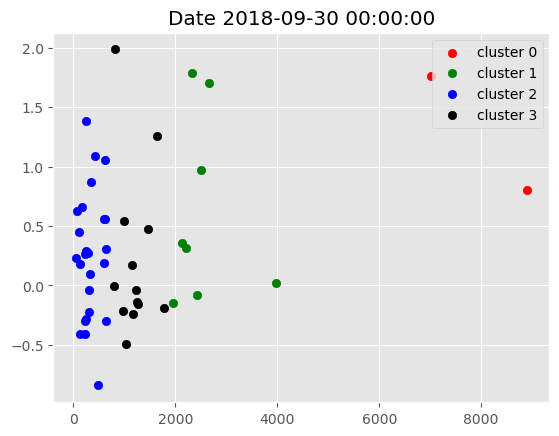

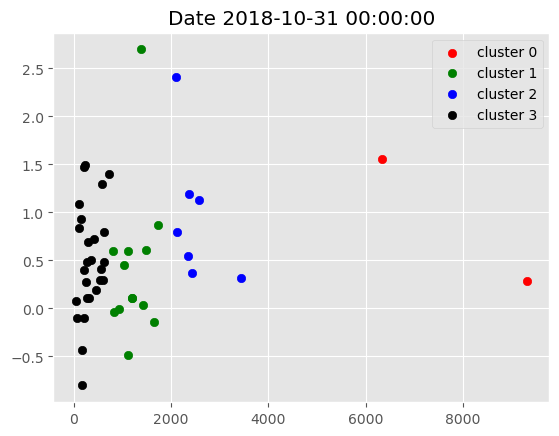

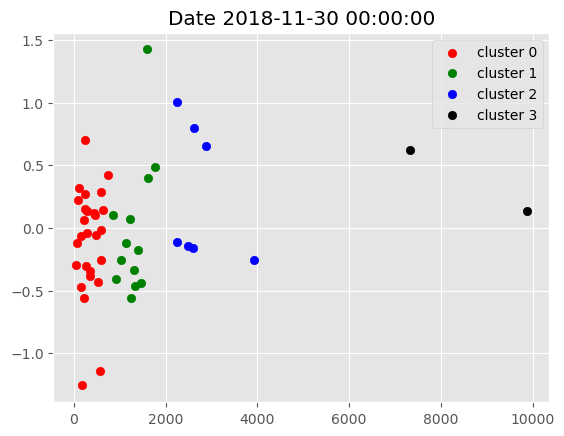

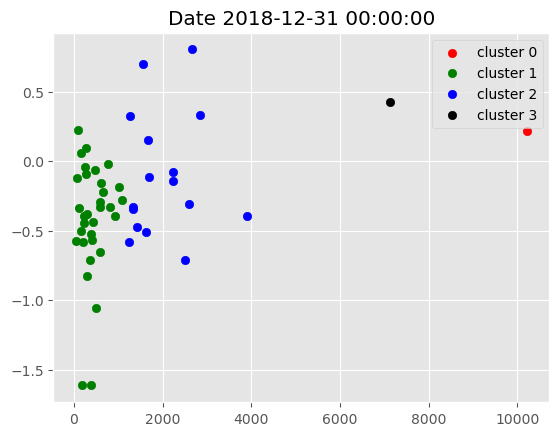

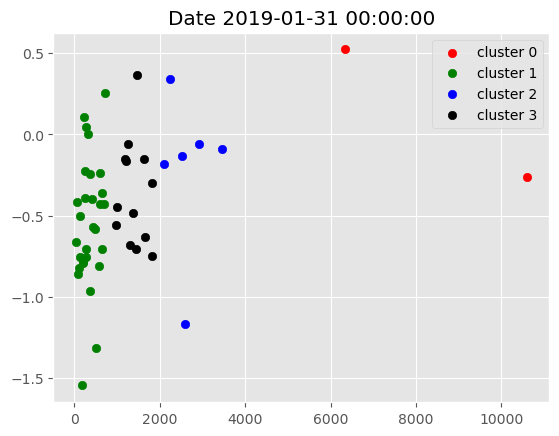

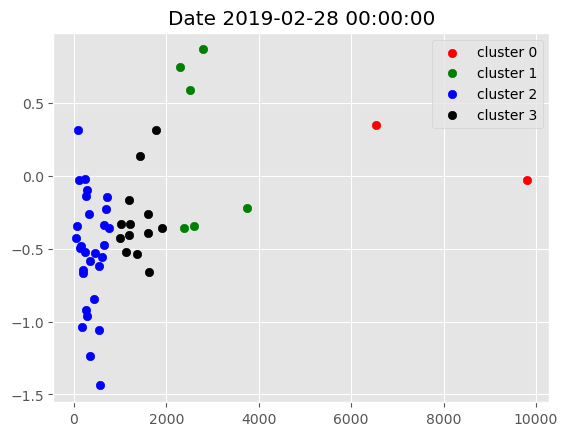

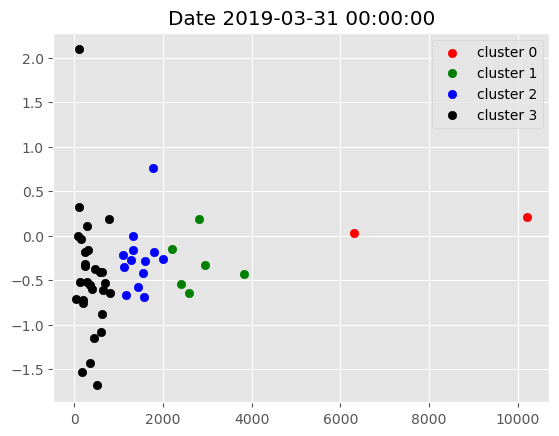

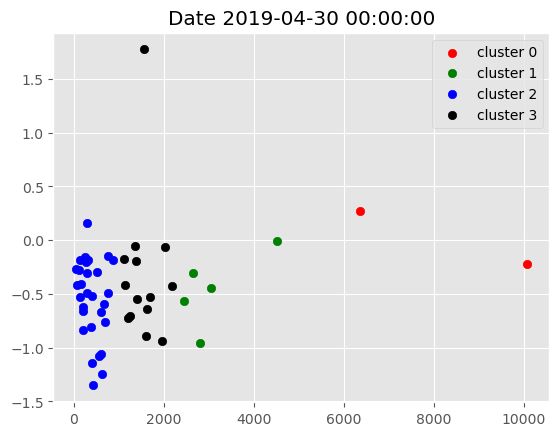

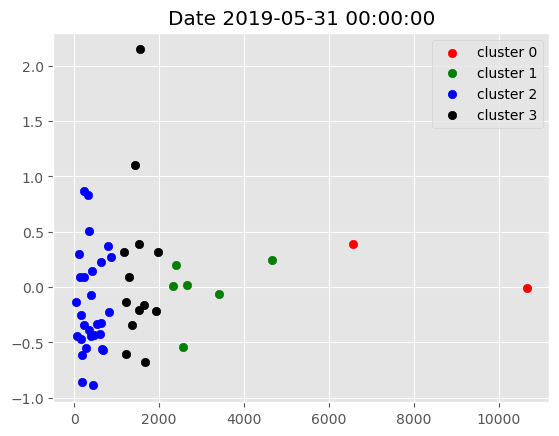

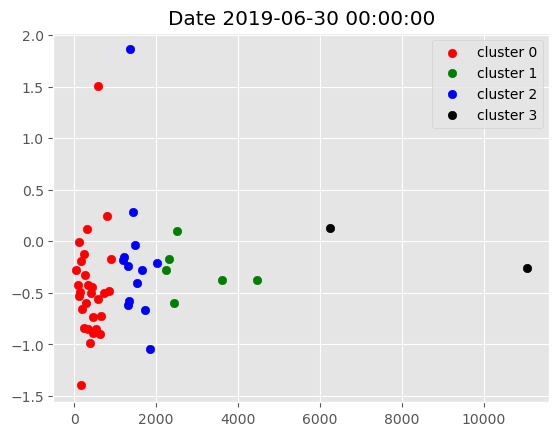

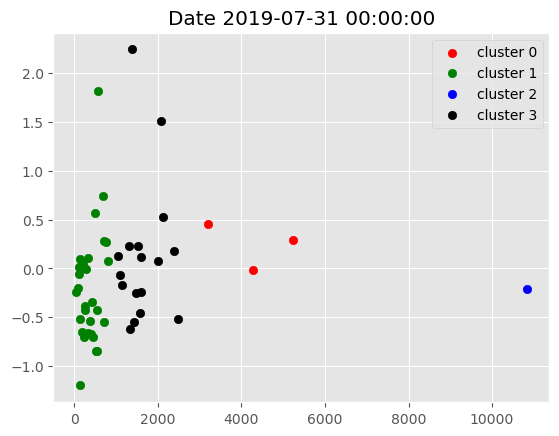

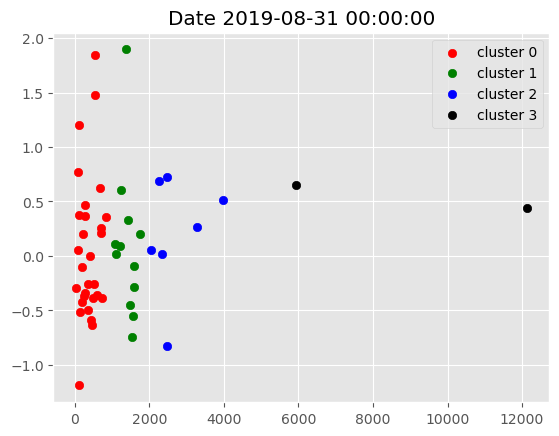

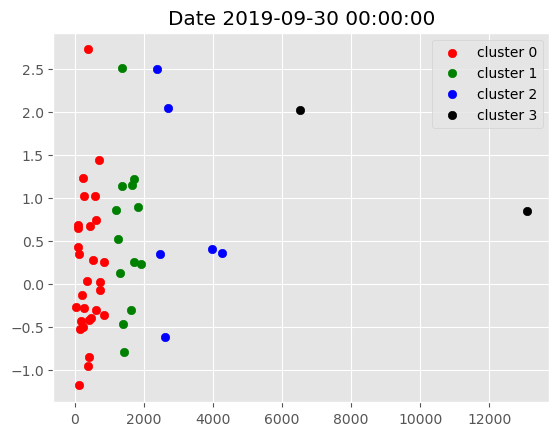

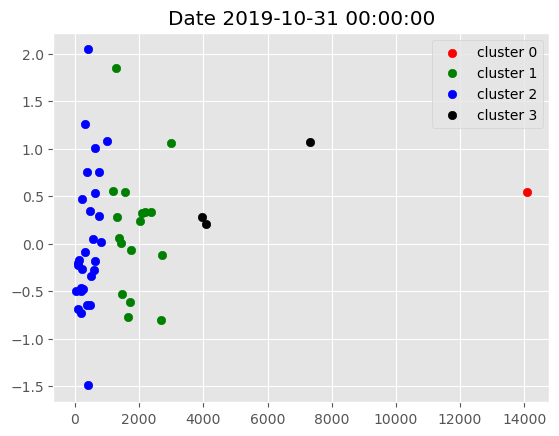

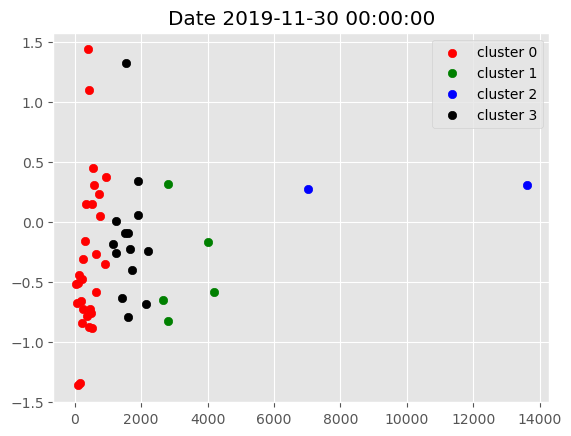

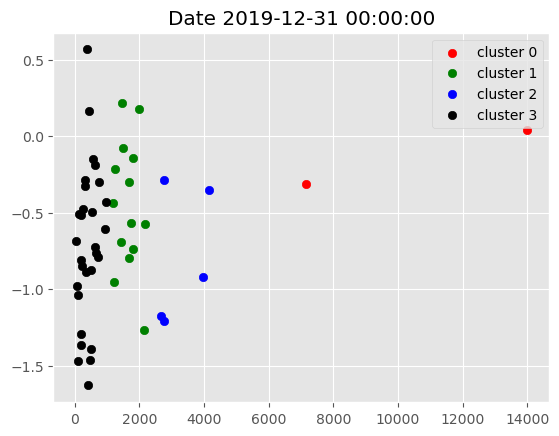

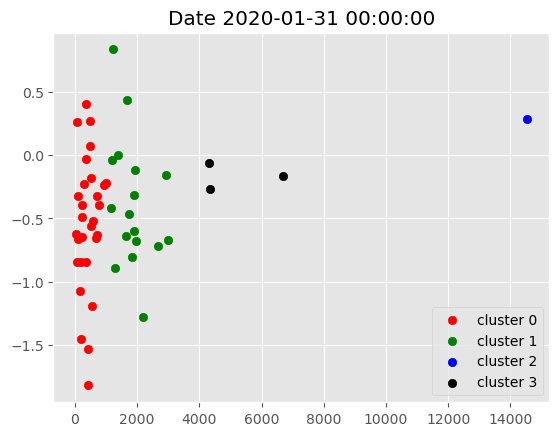

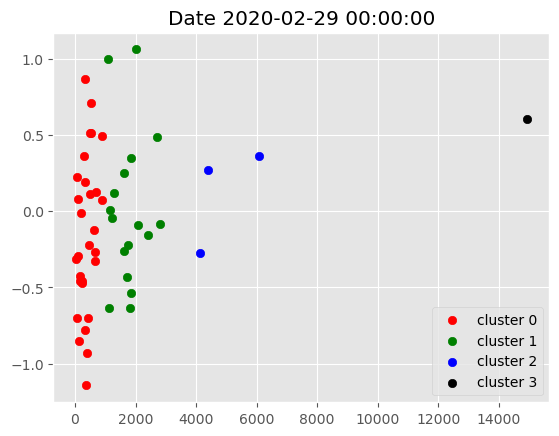

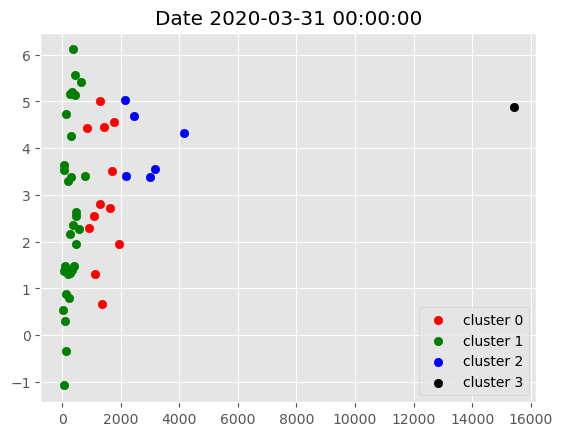

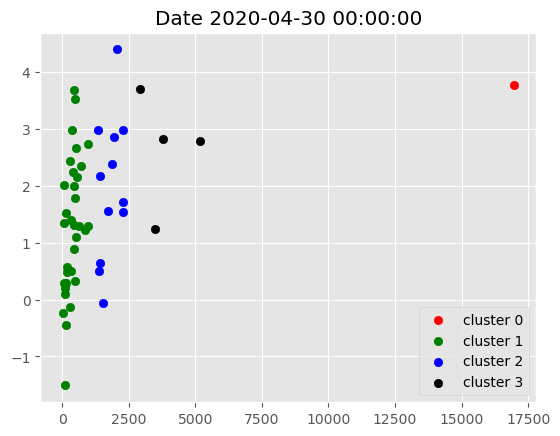

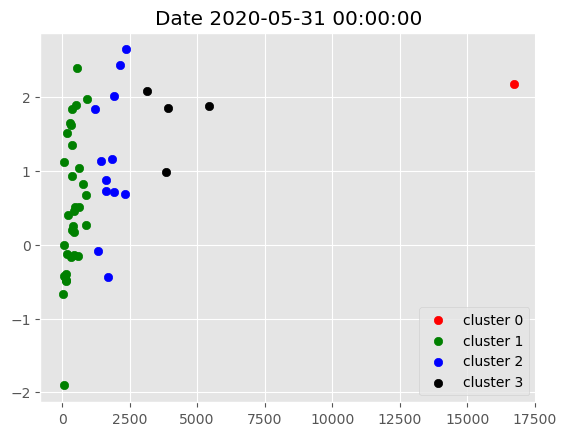

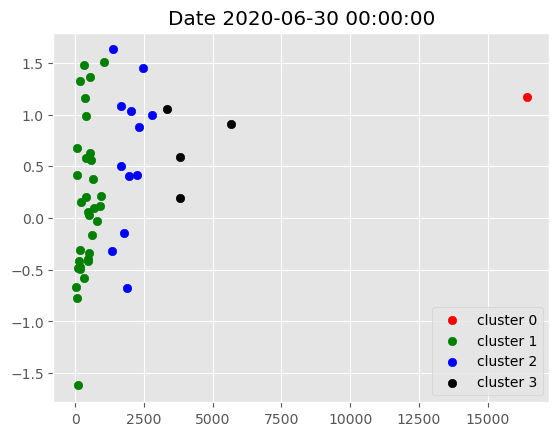

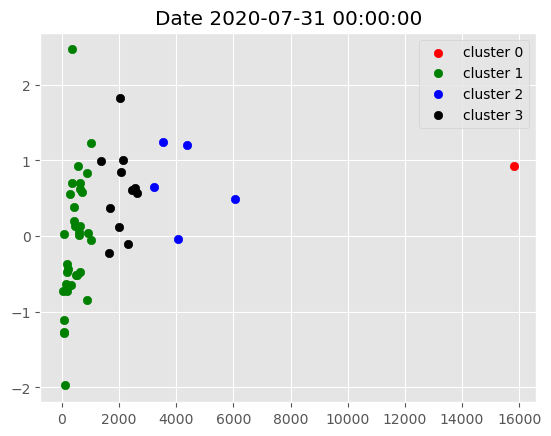

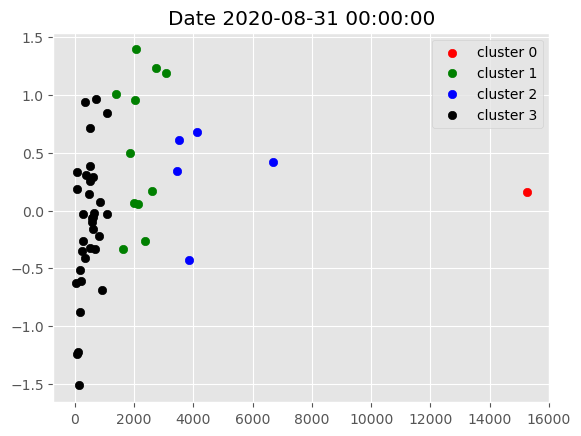

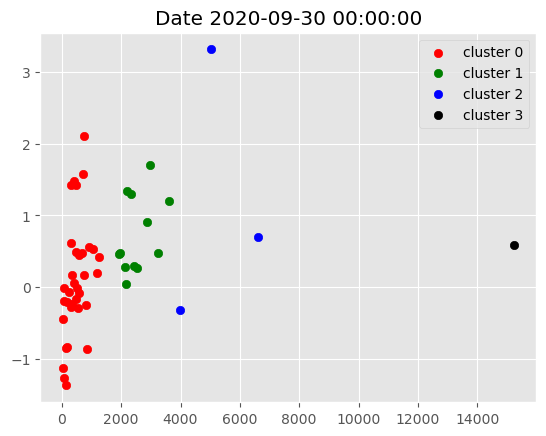

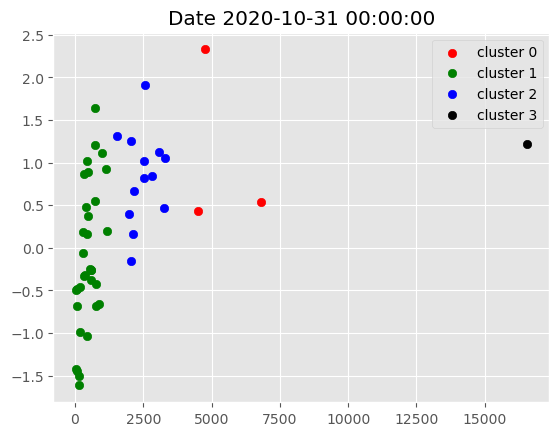

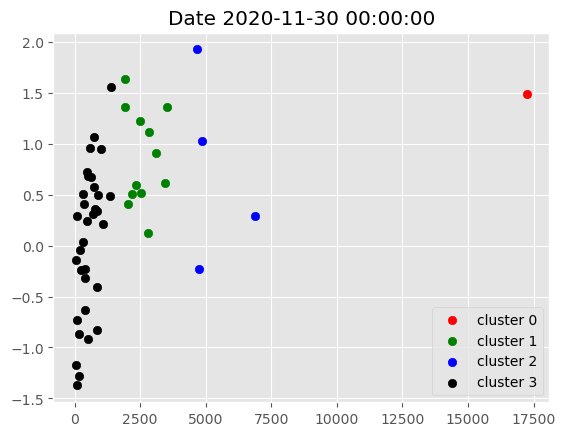

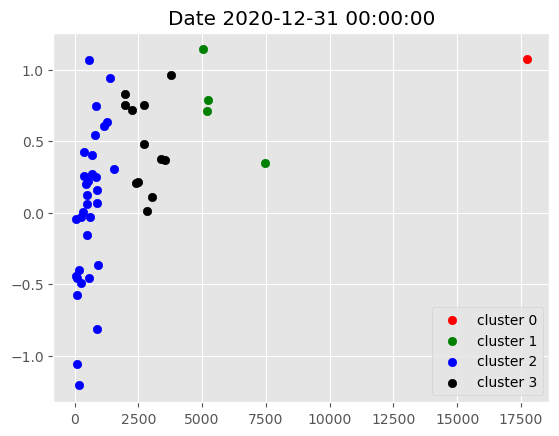

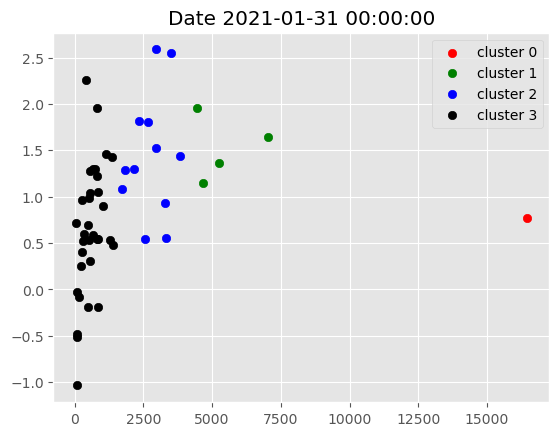

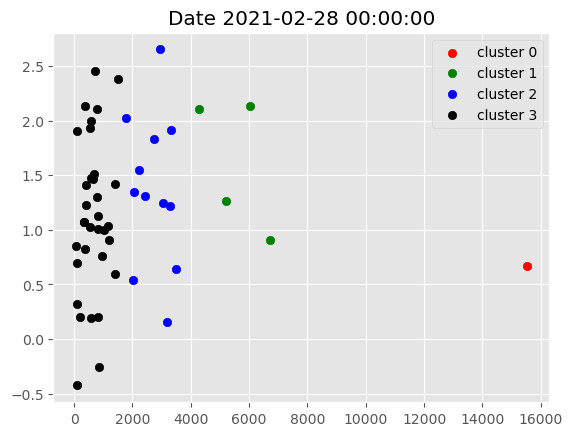

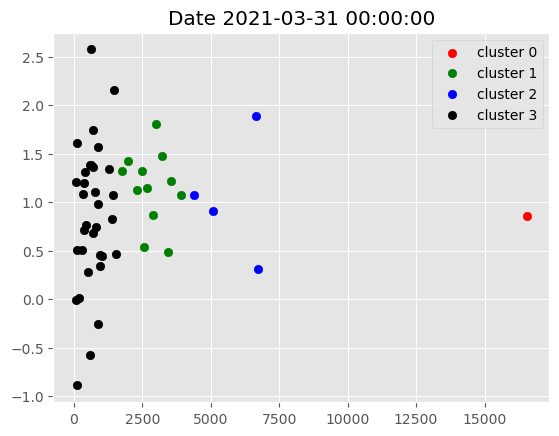

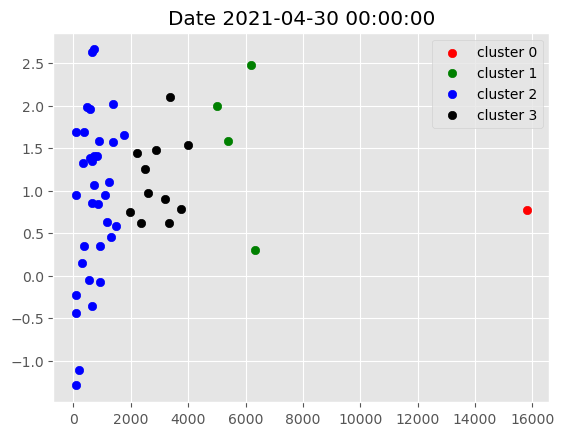

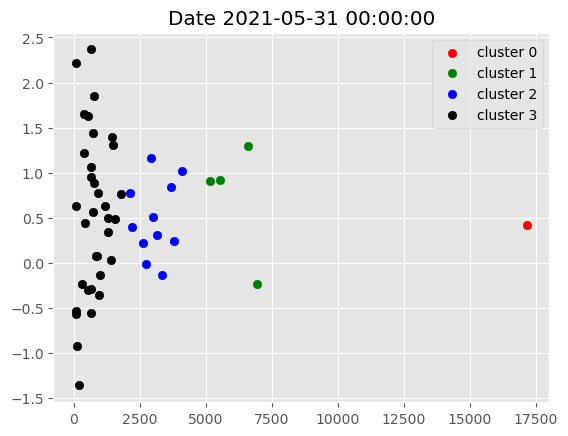

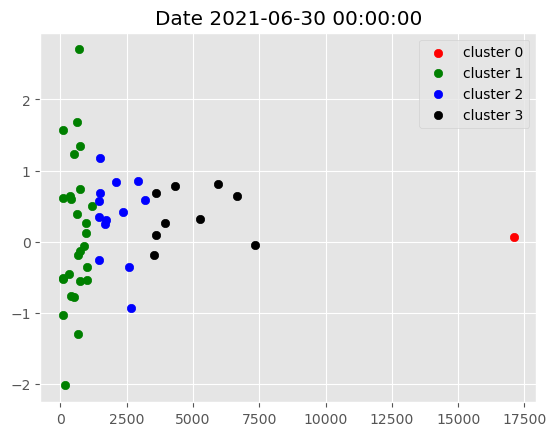

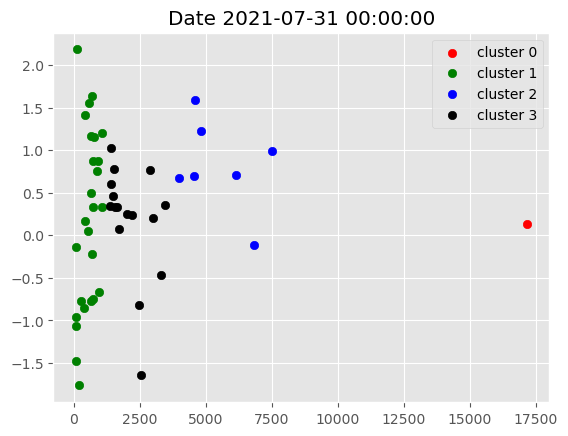

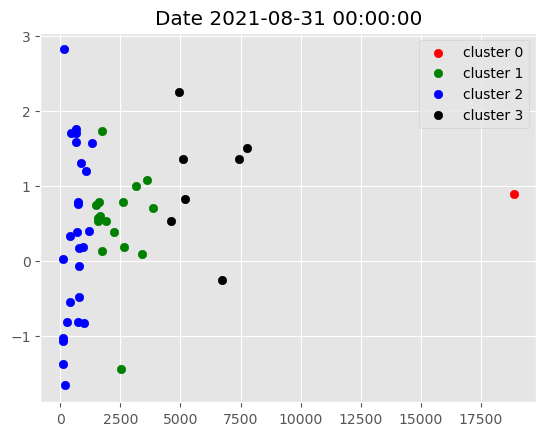

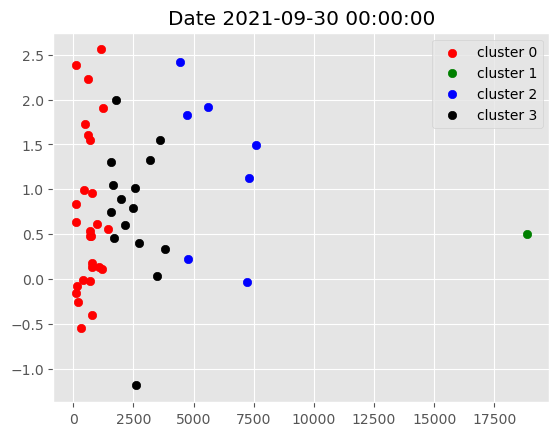

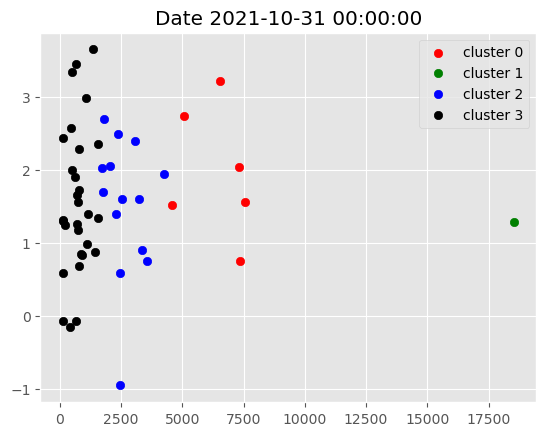

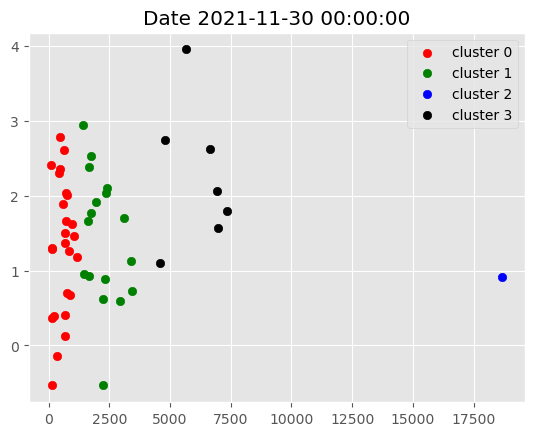

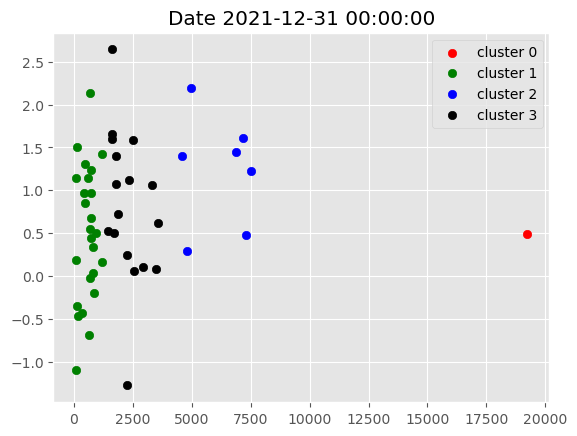

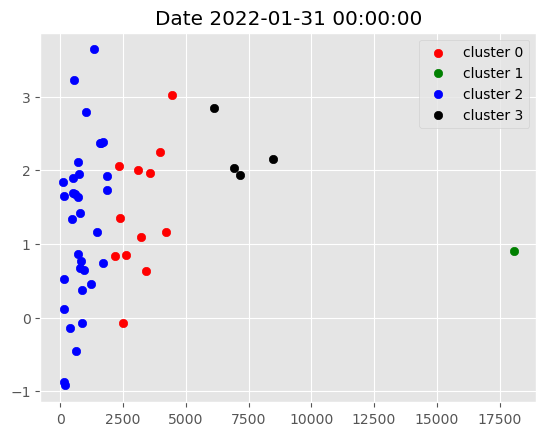

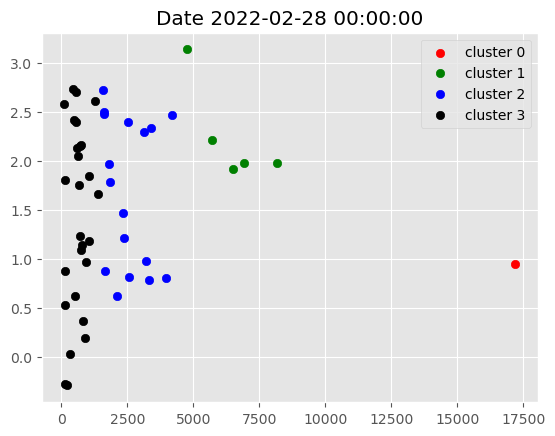

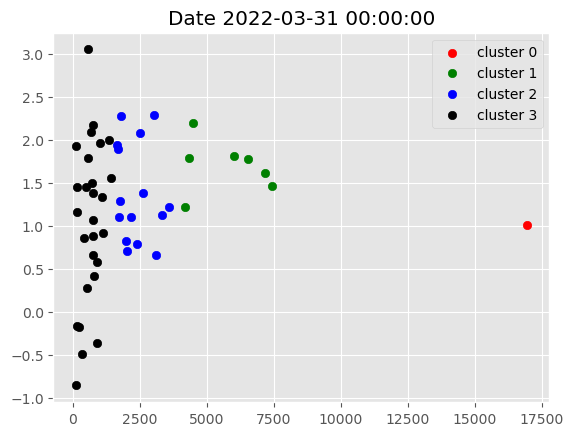

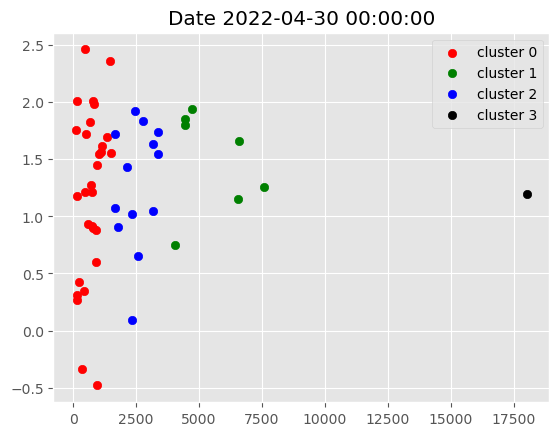

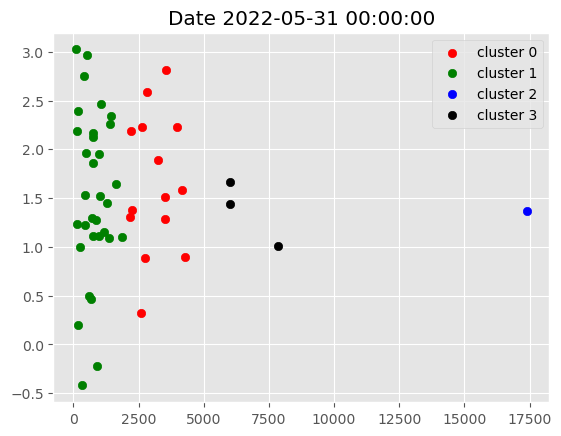

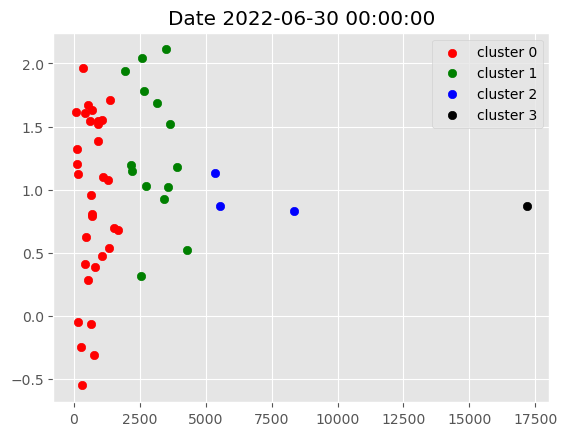

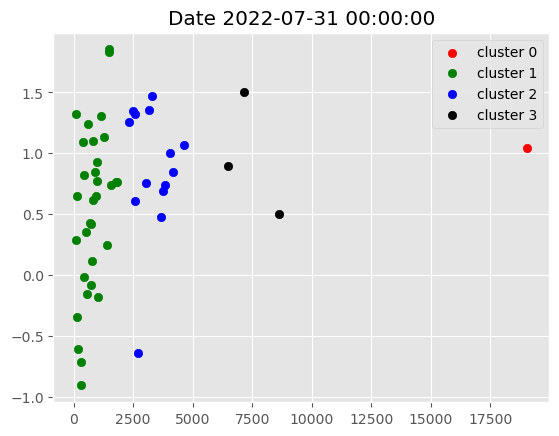

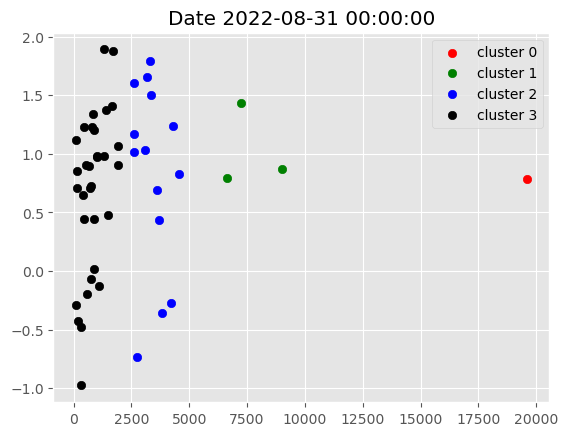

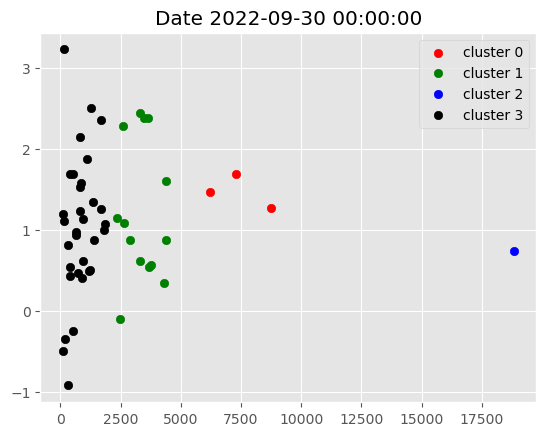

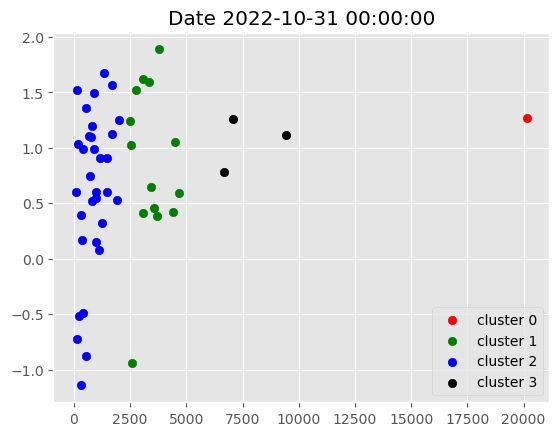

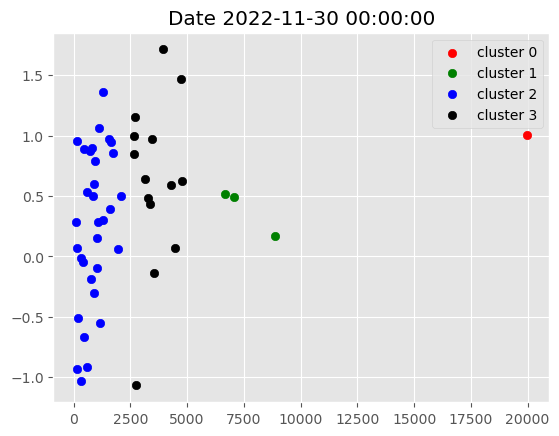

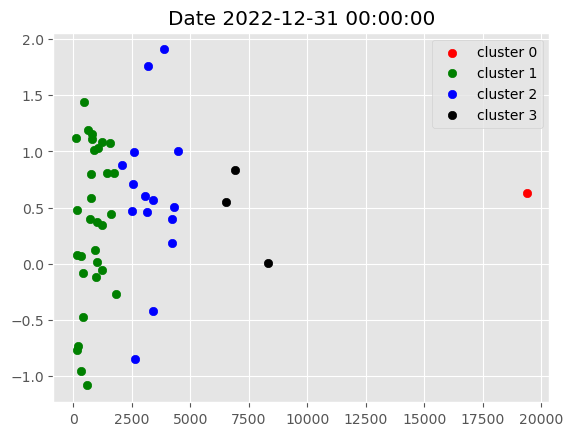

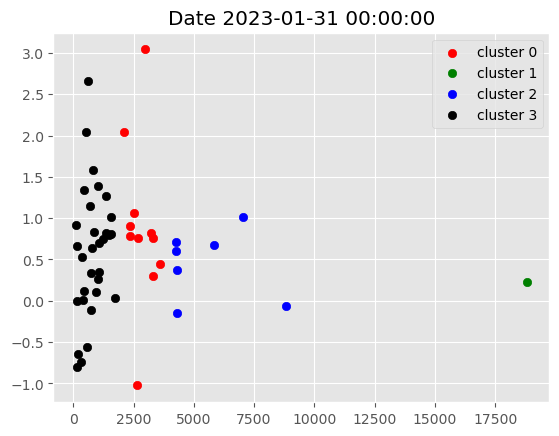

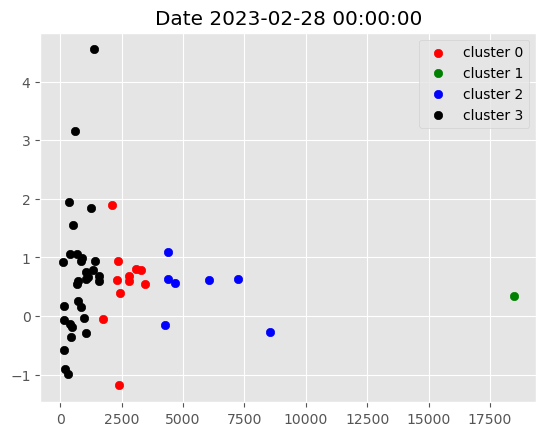

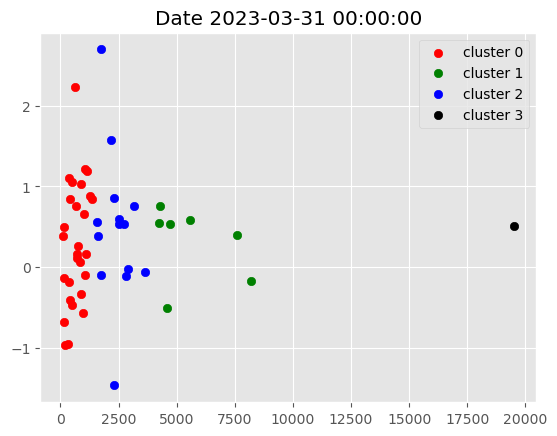

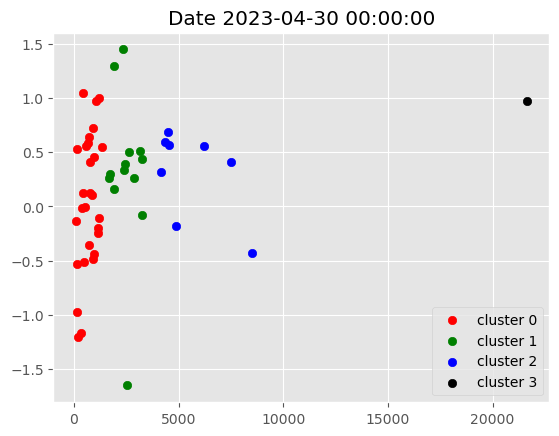

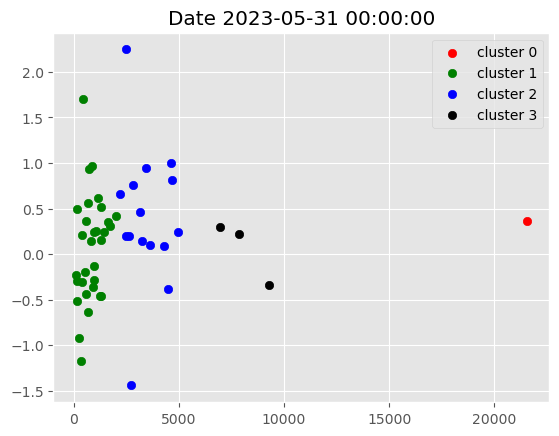

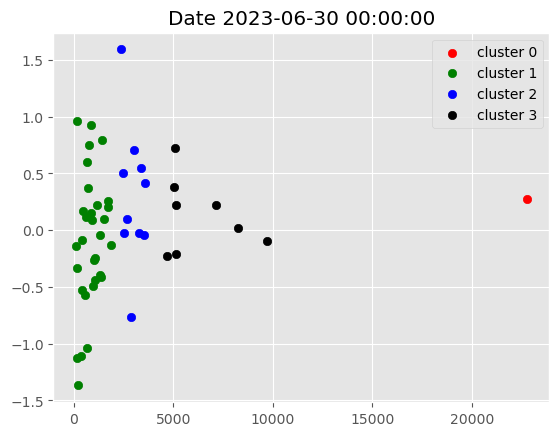

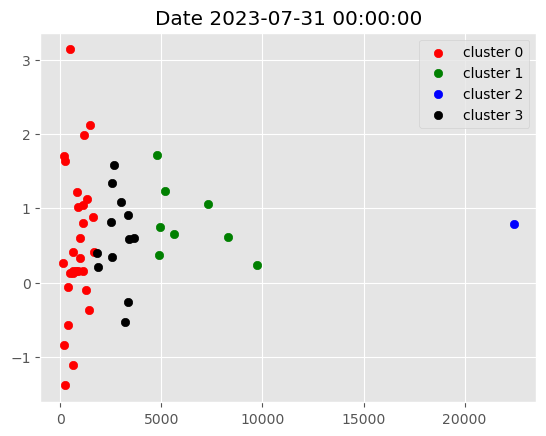

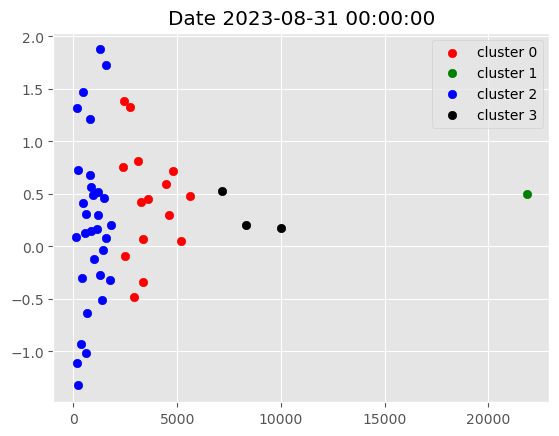

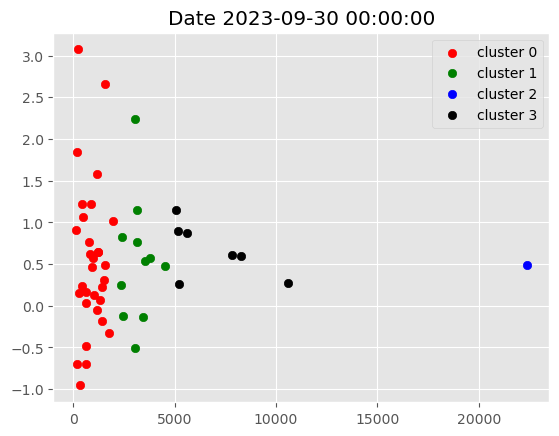

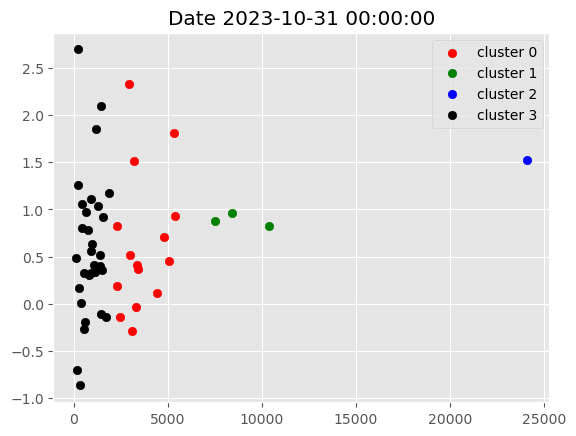

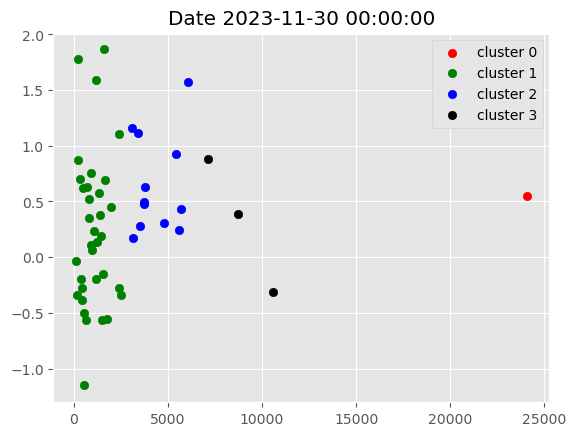

In [19]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)


### 6. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [20]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2015-06-01': ['DRREDDY.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS'],
 '2015-07-01': ['DRREDDY.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS'],
 '2015-08-01': ['DRREDDY.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS'],
 '2015-09-01': ['DRREDDY.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'ULTRACEMCO.NS'],
 '2015-10-01': ['DRREDDY.NS', 'MARUTI.NS', 'NESTLEIND.NS'],
 '2015-11-01': ['ADANIENT.NS',
  'ADANIPORTS.NS',
  'AXISBANK.NS',
  'BAJAJFINSV.NS',
  'BHARTIARTL.NS',
  'BPCL.NS',
  'COALINDIA.NS',
  'HCLTECH.NS',
  'HINDALCO.NS',
  'ICICIBANK.NS',
  'INFY.NS',
  'ITC.NS',
  'JSWSTEEL.NS',
  'NTPC.NS',
  'ONGC.NS',
  'POWERGRID.NS',
  'RELIANCE.NS',
  'SBIN.NS',
  'TATACONSUM.NS',
  'TATAMOTORS.NS',
  'TATASTEEL.NS',
  'TECHM.NS',
  'TITAN.NS',
  'UPL.NS',
  'WIPRO.NS'],
 '2015-12-01': ['ADANIENT.NS',
  'ADANIPORTS.NS',
  'BAJAJFINSV.NS',
  'BHARTIARTL.NS',
  'BPCL.NS',
  'COALINDIA.NS',
  'HCLTECH.NS',
  'HINDALCO.NS',
  'ICICIBANK.NS',
  'ITC.NS',
  'JSWSTEEL.NS',
  'NTPC.NS',
  'ONG

### Define portfolio optimization function

We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [21]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

 * Download Fresh Daily Prices Data only for short listed stocks.

In [22]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=24),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  50 of 50 completed


Adj Close                                            \
            ADANIENT.NS ADANIPORTS.NS APOLLOHOSP.NS ASIANPAINT.NS   
Date                                                                
2013-05-31    28.400606    143.324036    964.777588    447.569275   
2013-06-03    27.897528    144.737961    930.023743    432.033936   
2013-06-04    27.689585    146.434662    982.537537    430.745514   
2013-06-05    28.588425    145.680573    974.447449    430.280762   
2013-06-06    28.856733    143.748199    962.048950    428.546143   
...                 ...           ...           ...           ...   
2023-11-22  2172.649902    791.900024   5532.000000   3133.000000   
2023-11-23  2175.250000    793.099976   5493.950195   3122.949951   
2023-11-24  2225.449951    795.549988   5401.299805   3136.149902   
2023-11-28  2423.500000    837.700012   5366.799805   3148.350098   
2023-11-29  2396.600098    835.549988   5421.950195   3148.350098   

                                                                   \
            AXISBANK.NS BAJAJ-AUTO.NS BAJAJFINSV.NS BAJFINANCE.NS   
Date                                                                
2013-05-31   270.645508   1311.146362     65.669373    140.405807   
2013-06-03   270.702301   1267.213257     65.817970    140.935043   
2013-06-04   264.004944   1273.298950     66.288483    139.013550   
2013-06-05   261.507629   1264.620605     65.580231    139.895599   
2013-06-06   268.290100   1257.418579     65.500992    138.689285   
...                 ...           ...           ...           ...   
2023-11-22   998.099976   5751.549805   1623.900024   7128.350098   
2023-11-23   999.049988   5925.250000   1623.949951   7073.649902   
2023-11-24  1008.500000   5930.299805   1617.250000   7020.799805   
2023-11-28  1021.150024   5998.149902   1654.400024   7127.549805   
2023-11-29  1060.150024   6069.950195   1653.500000   7130.100098   

                                      ...       Volume                \
           BHARTIARTL.NS     BPCL.NS  ... SUNPHARMA.NS TATACONSUM.NS   
Date                                  ...                              
2013-05-31    262.593994   75.400375  ...      4391362       3823348   
2013-06-03    263.854950   73.599640  ...      2791600       1446953   
2013-06-04    264.550690   74.299927  ...      2693116       3464825   
2013-06-05    263.028809   74.760117  ...      2588284       1965493   
2013-06-06    256.636780   74.630058  ...      1560132       1633085   
...                  ...         ...  ...          ...           ...   
2023-11-22    969.750000  402.100006  ...      1401782        885449   
2023-11-23    976.650024  411.299988  ...      1177434        907511   
2023-11-24    973.150024  410.600006  ...      1376695        521207   
2023-11-28    984.900024  424.500000  ...       886708        904835   
2023-11-29    995.400024  428.649994  ...      1813462       1047897   

                                                                  \
           TATAMOTORS.NS TATASTEEL.NS   TCS.NS TECHM.NS TITAN.NS   
Date                                                               
2013-05-31       6906041     71057705  1929868   478088  1240732   
2013-06-03       8077455     45763118  3097612  1137708  1173694   
2013-06-04       7869007     40275253  1305320  2076636  2085444   
2013-06-05       5727698     35038255  1728676  2322816  2348999   
2013-06-06       5575044     36067396  2540452  2205108  2438952   
...                  ...          ...      ...      ...      ...   
2023-11-22       9279642     19588063  1798051   750622   980779   
2023-11-23       5885370     30736851  2729804   651637   517362   
2023-11-24       6951690     14719450  1989733   884921   589530   
2023-11-28      16015860     18377843  1689195   910795   733524   
2023-11-29      16122864     23092165  1441634  1898448   819200   

                                            
           ULTRACEMCO.NS   UPL.NS WIPRO.NS  
Date                        

 * Calculate daily returns for each stock which could land up in our portfolio.

 * Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

 * If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

 * Calculated each day portfolio return.

In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram

In [24]:
def hrp_weights(cov_matrix):
    corr_matrix = cov_matrix.corr()
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(corr_matrix, 'single')
    
    # Create a dendrogram
    plt.figure(figsize=(10, 8))
    dendrogram(linkage_matrix, labels=corr_matrix.columns)
    
    # Extract cluster labels
    cluster_labels = pd.Series(index=corr_matrix.columns, data=dendrogram(linkage_matrix, no_plot=True)['ivl'])
    
    # Calculate inverse variance of each cluster
    inv_var = 1 / corr_matrix.groupby(cluster_labels).apply(np.diag).apply(np.sum)
    
    # Calculate weights based on inverse variance
    weights = inv_var / inv_var.sum()
    
    return weights

'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
'return'
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
'return'
'return'
'return'
'return'
'return'
Max Sharpe Optimization failed for 2020-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-11-01, Continuing with Equal-Weights
'return'
'return'
'return'
'return'
'return'
'return'
'return'
're

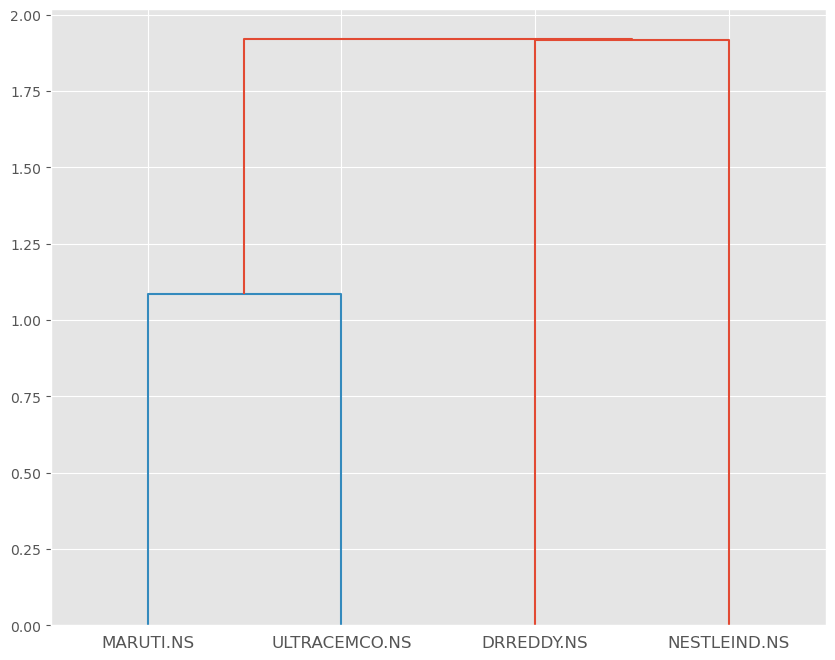

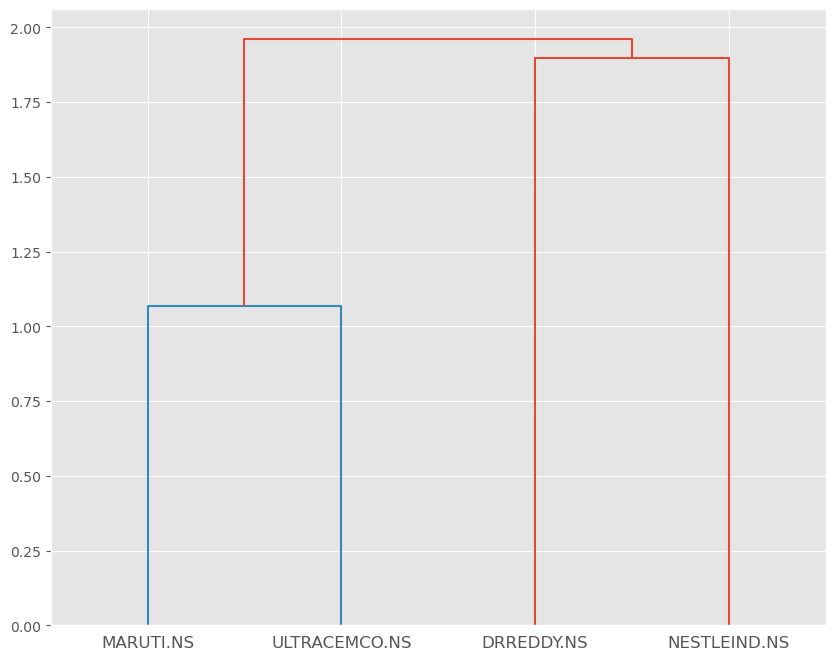

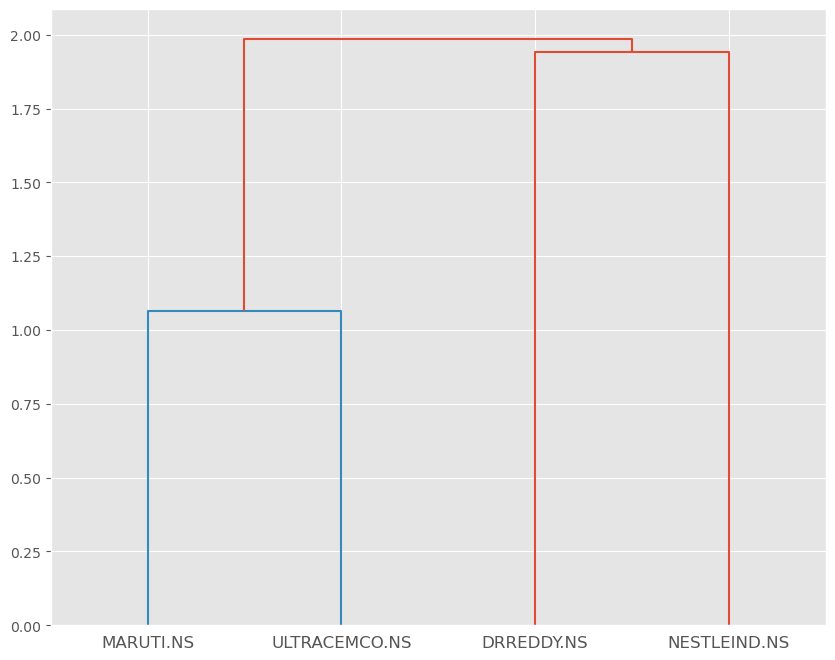

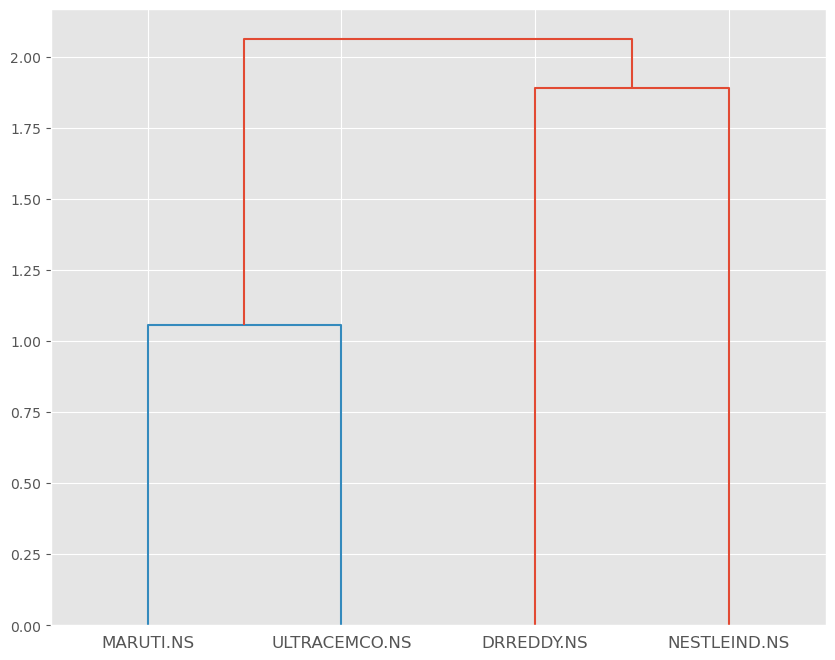

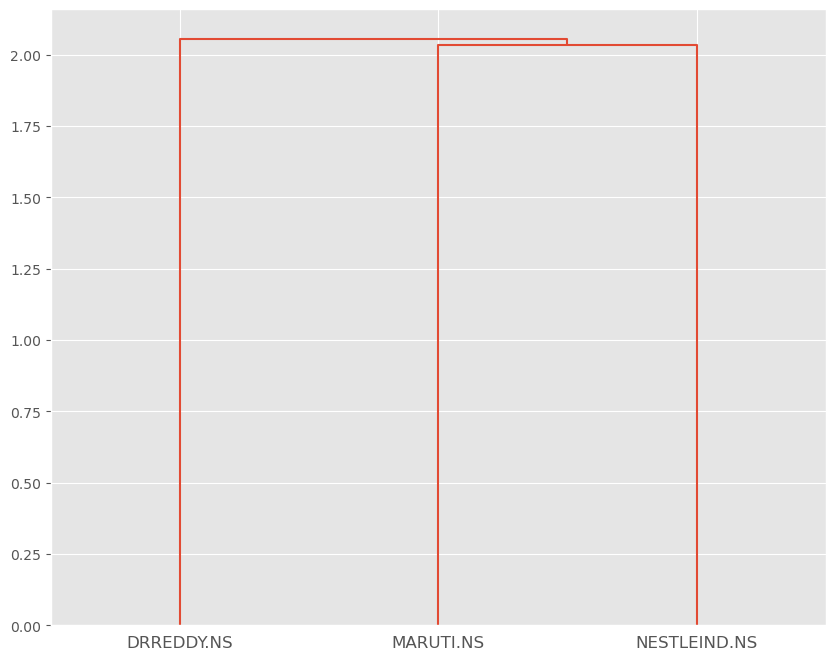

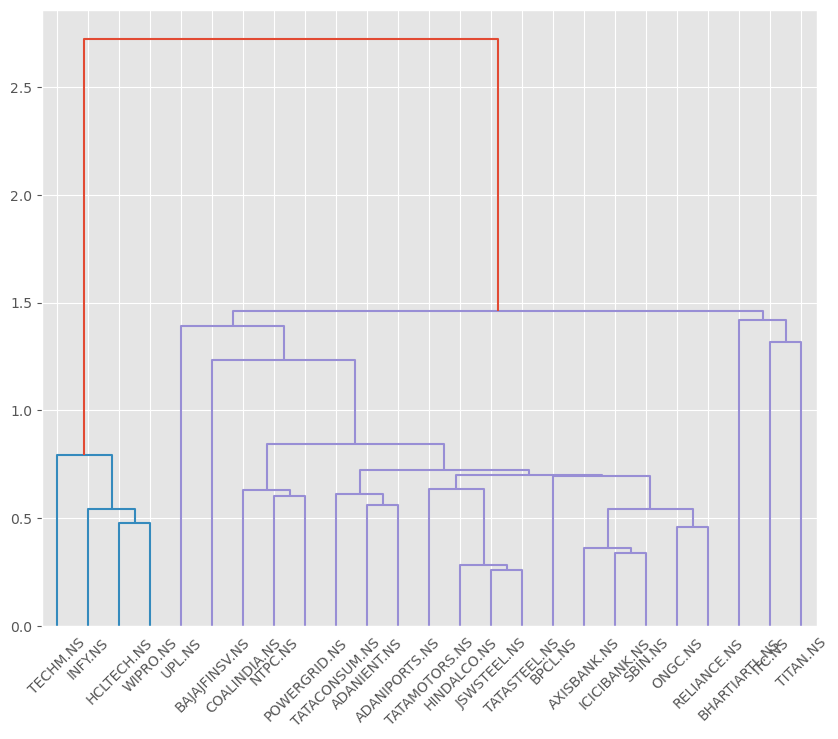

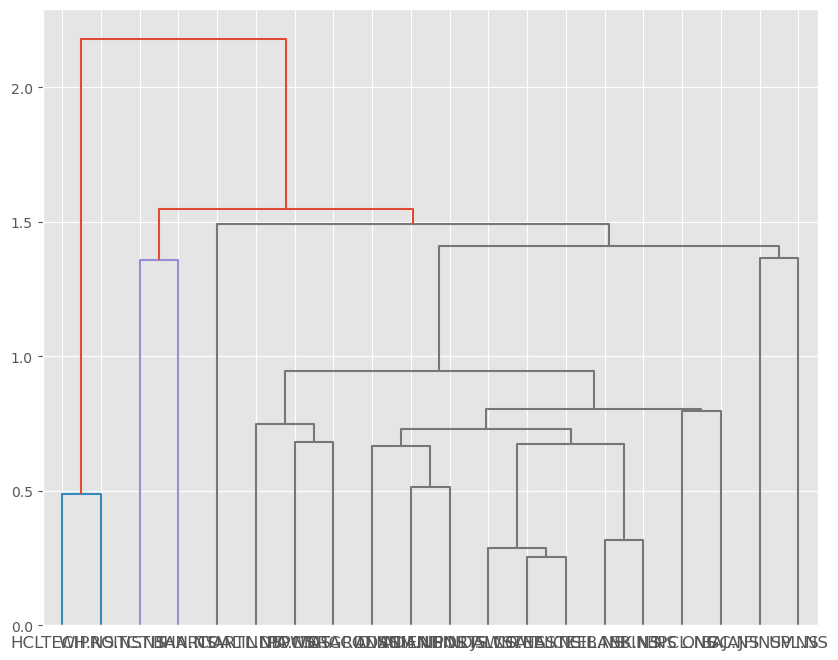

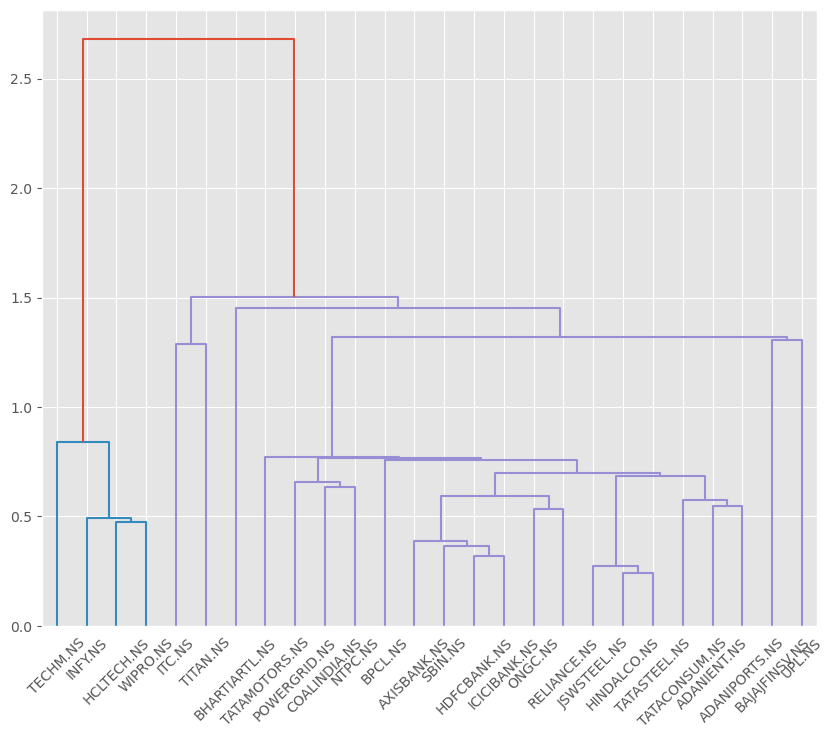

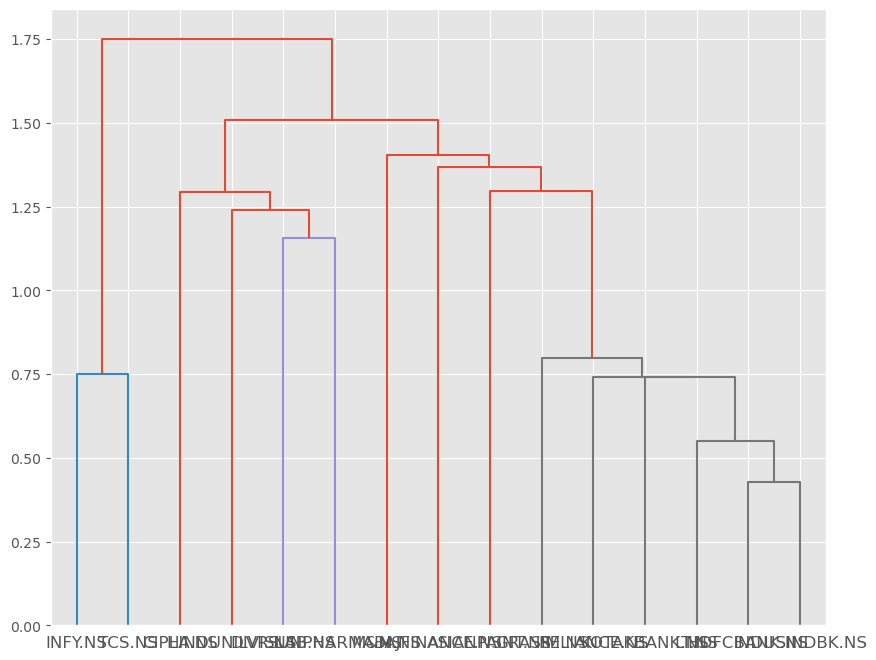

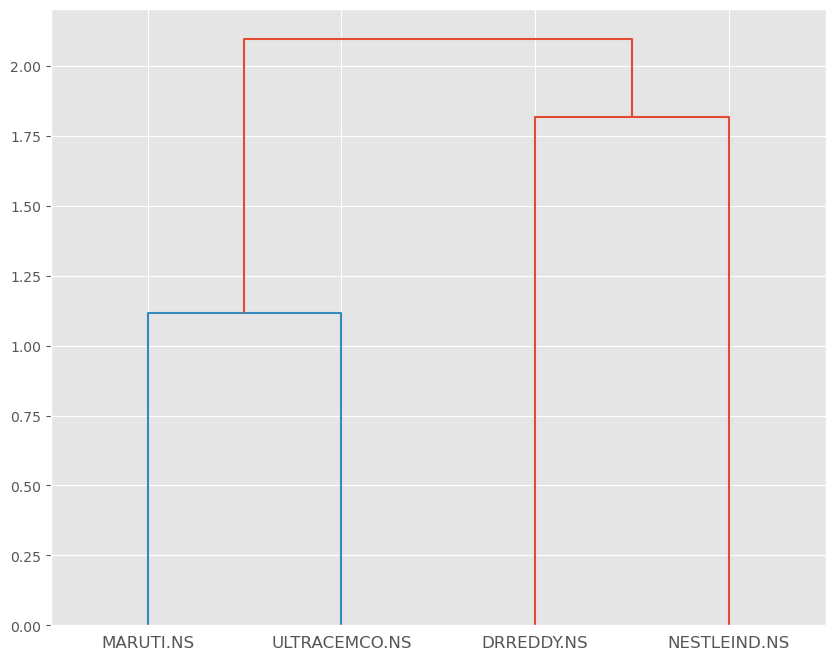

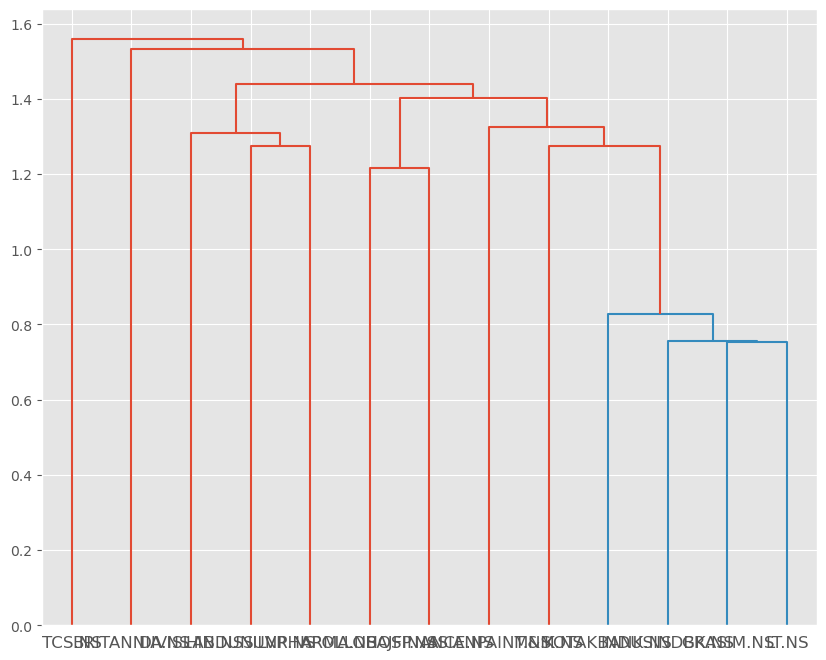

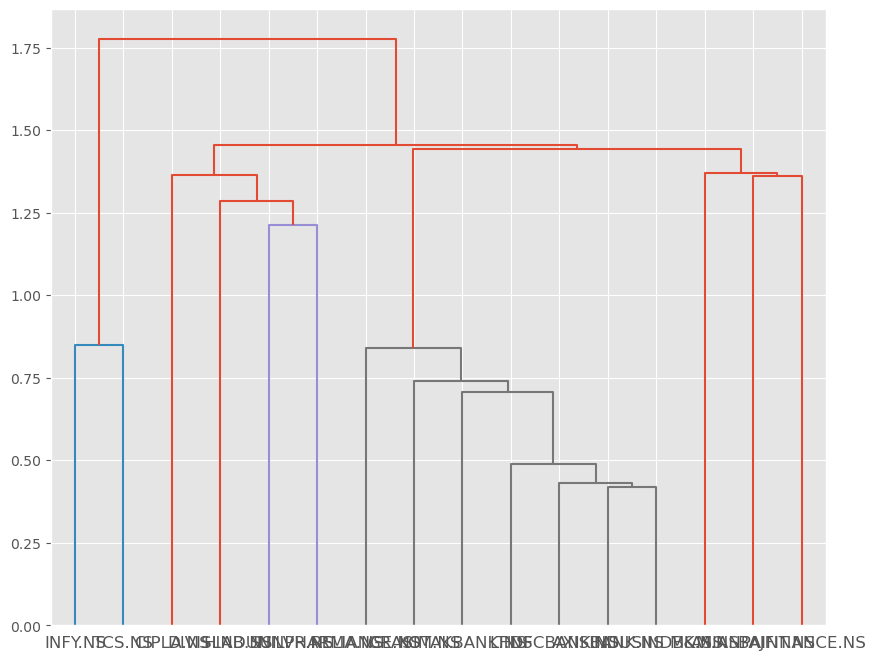

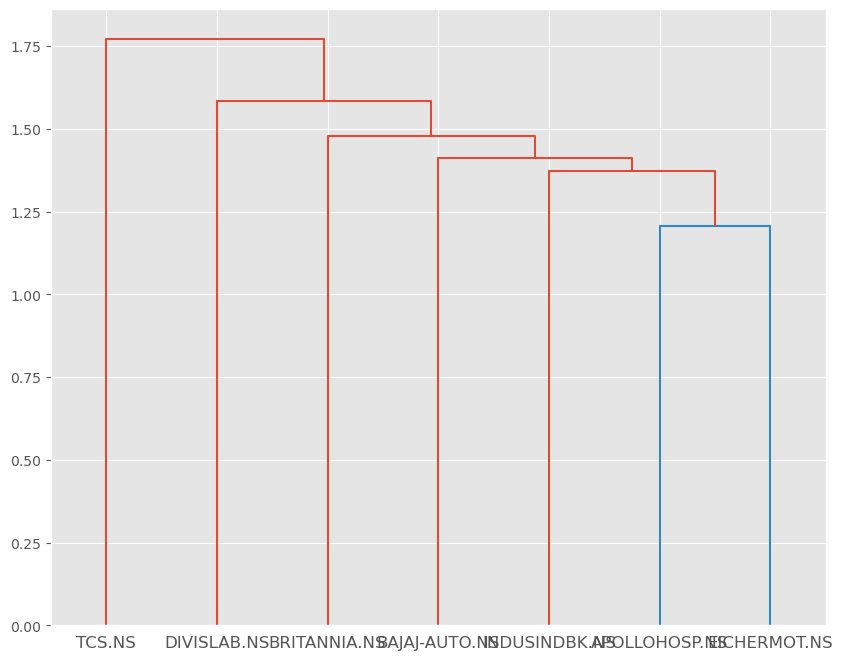

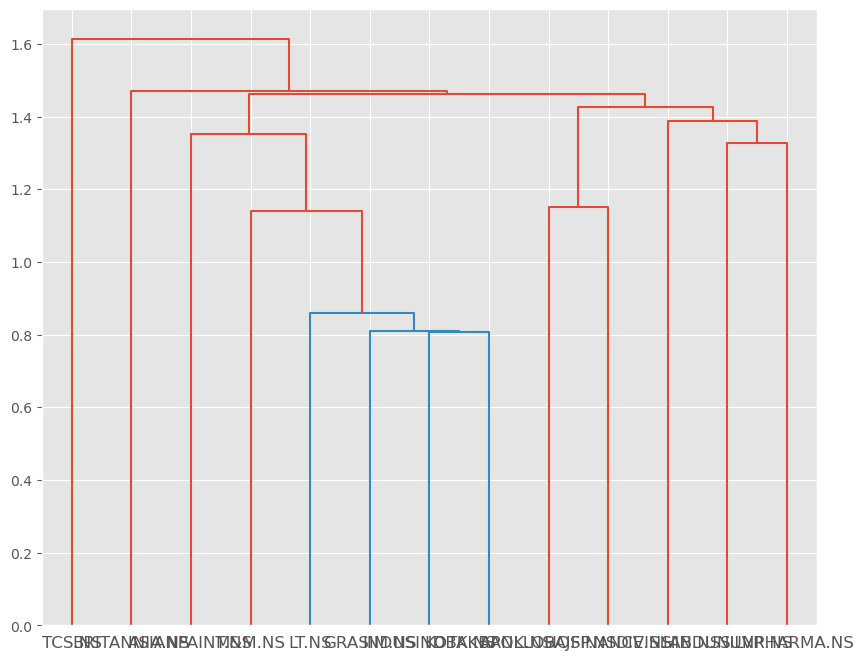

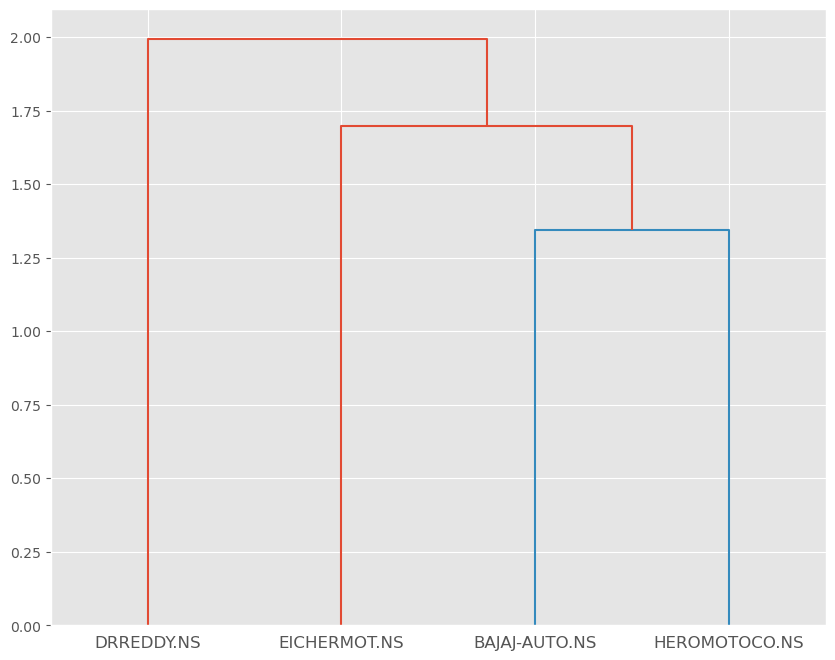

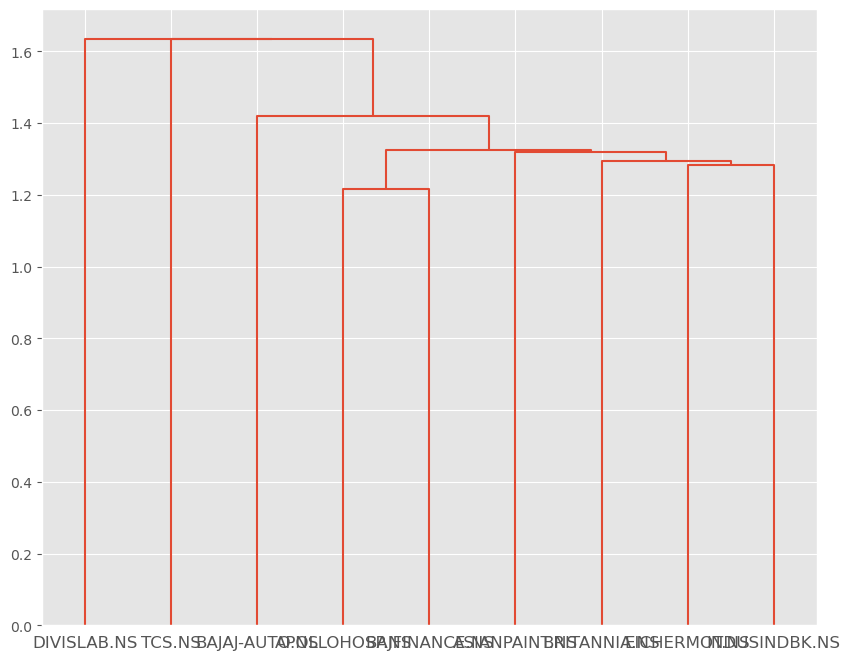

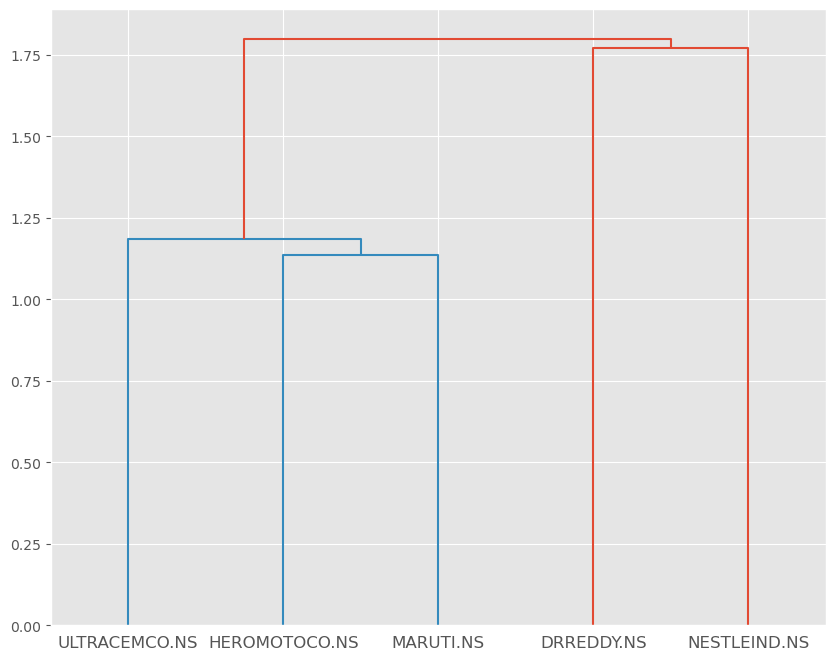

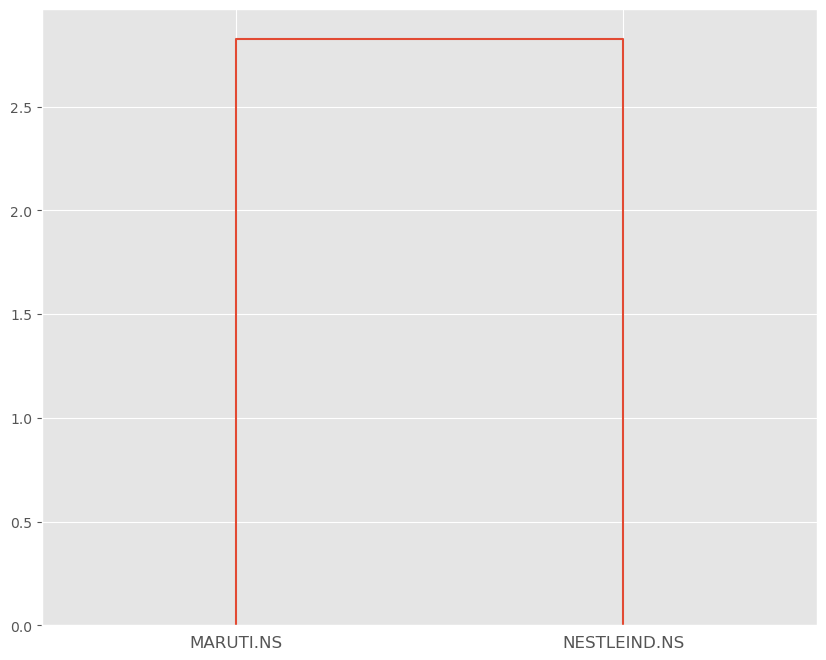

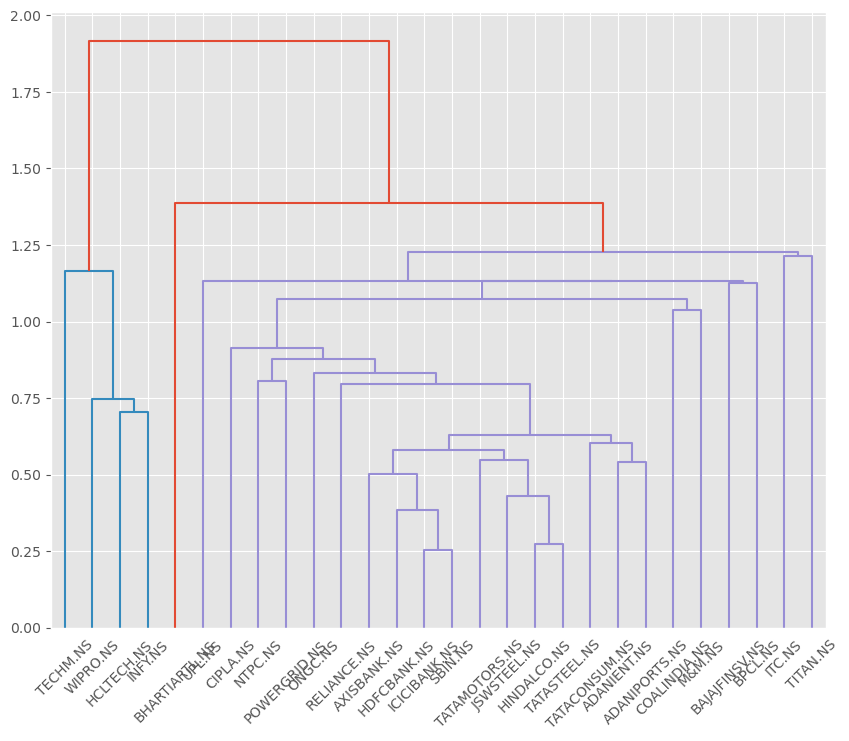

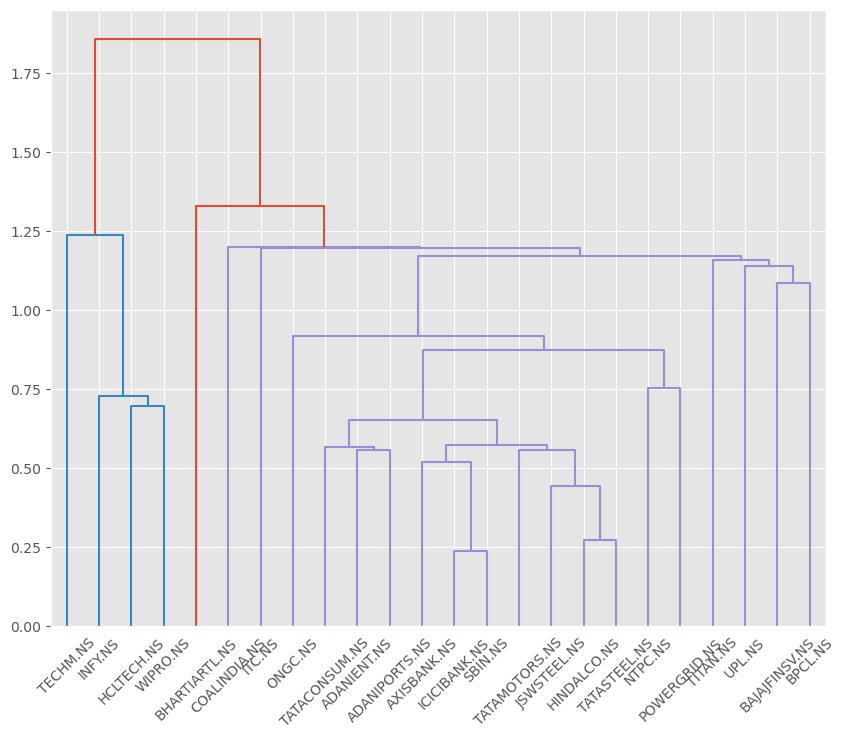

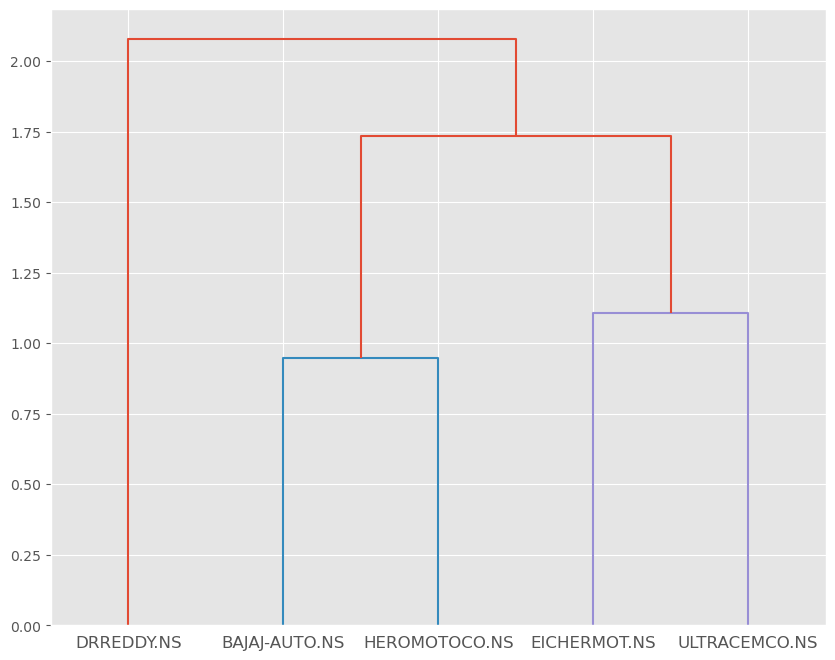

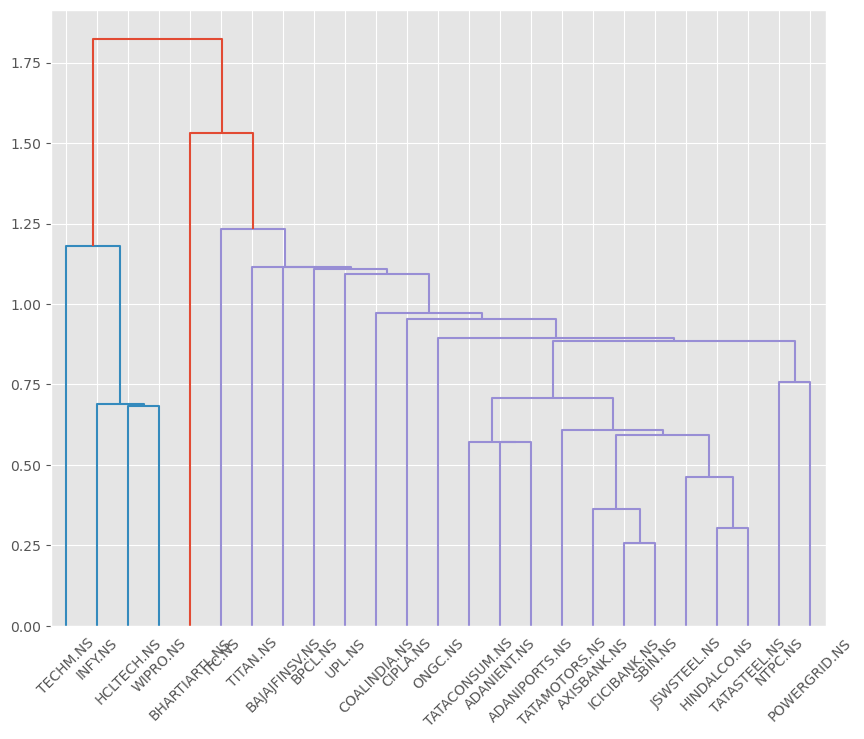

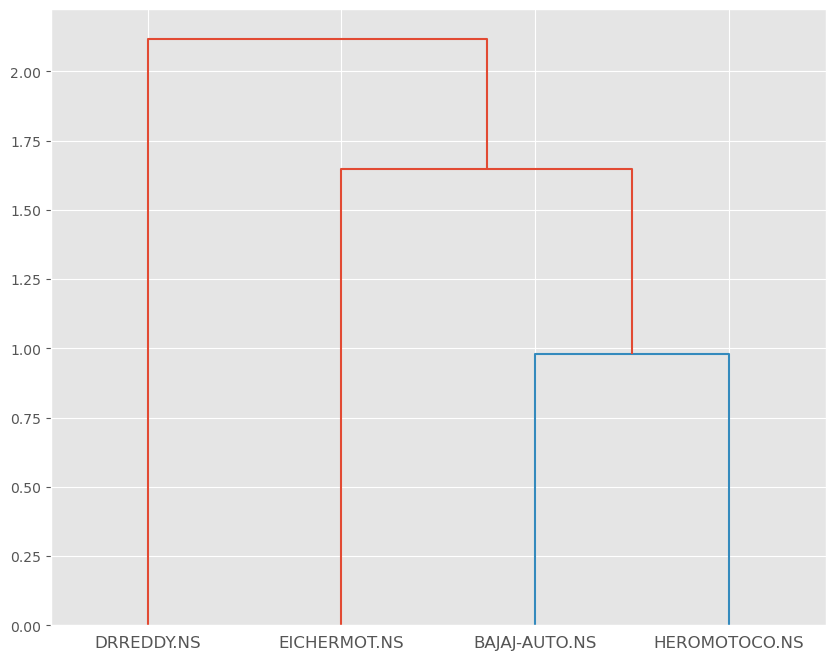

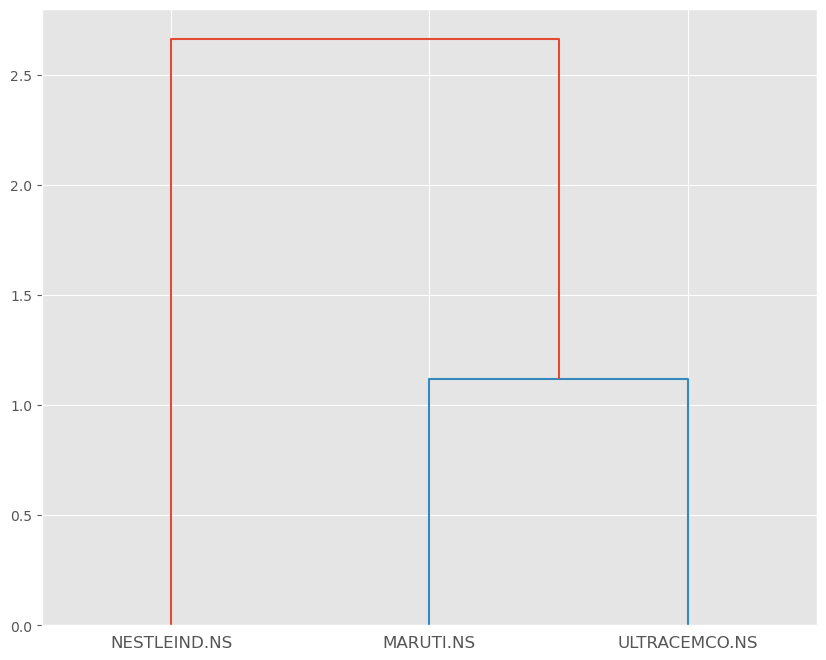

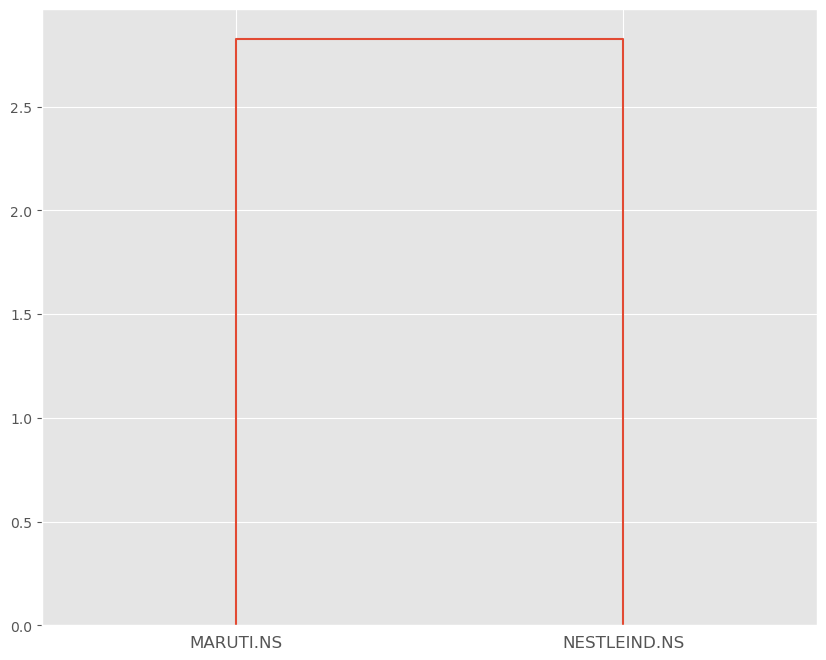

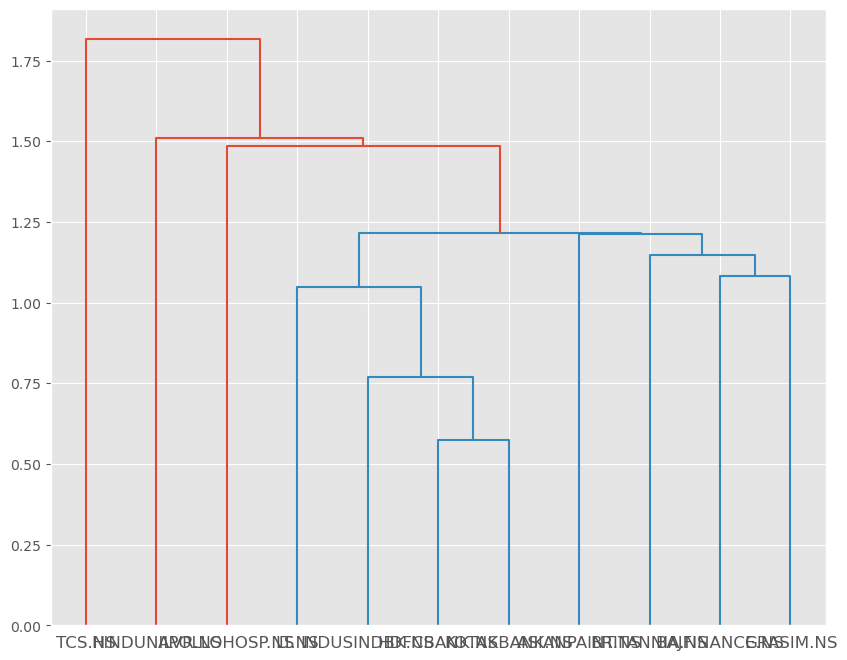

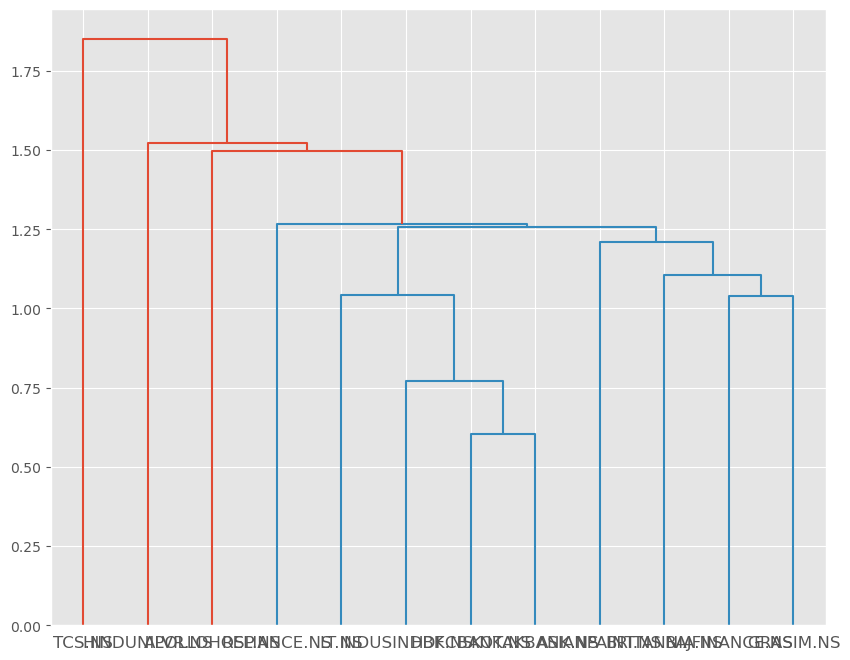

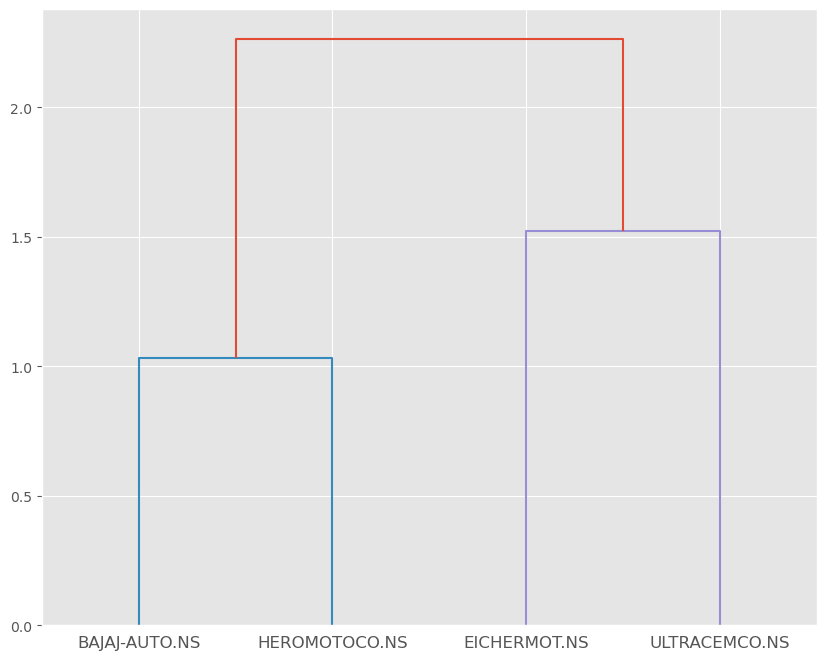

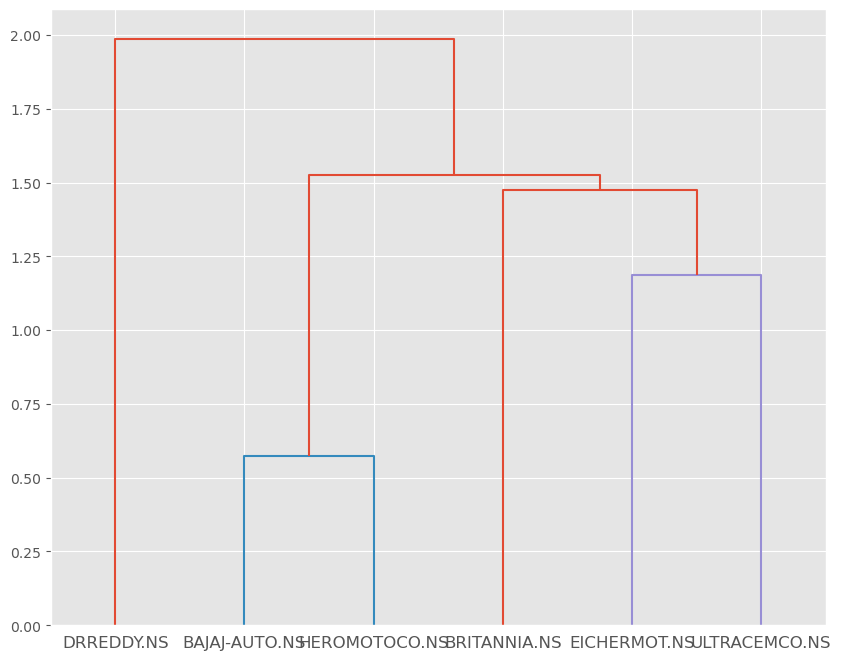

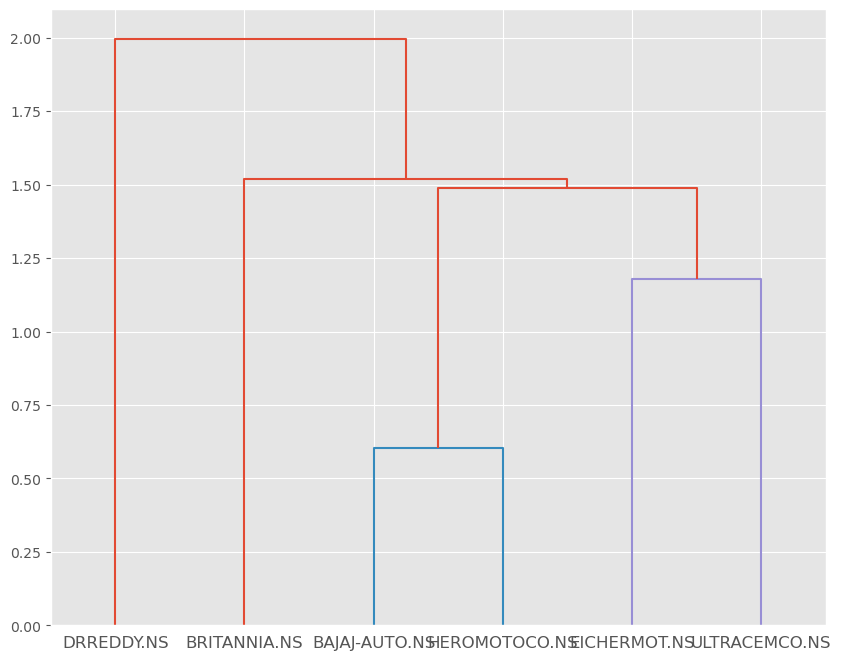

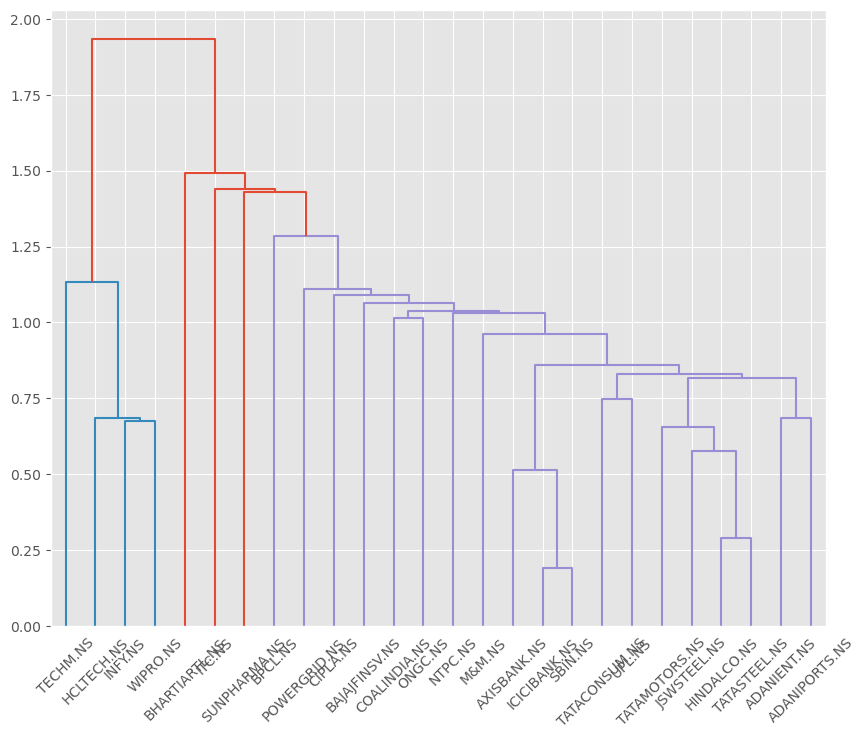

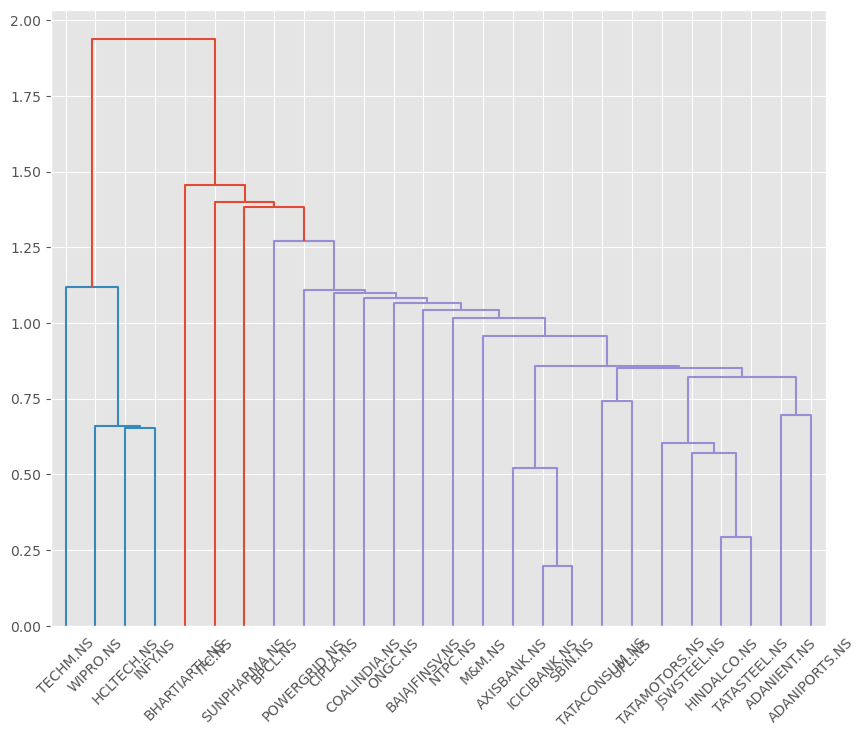

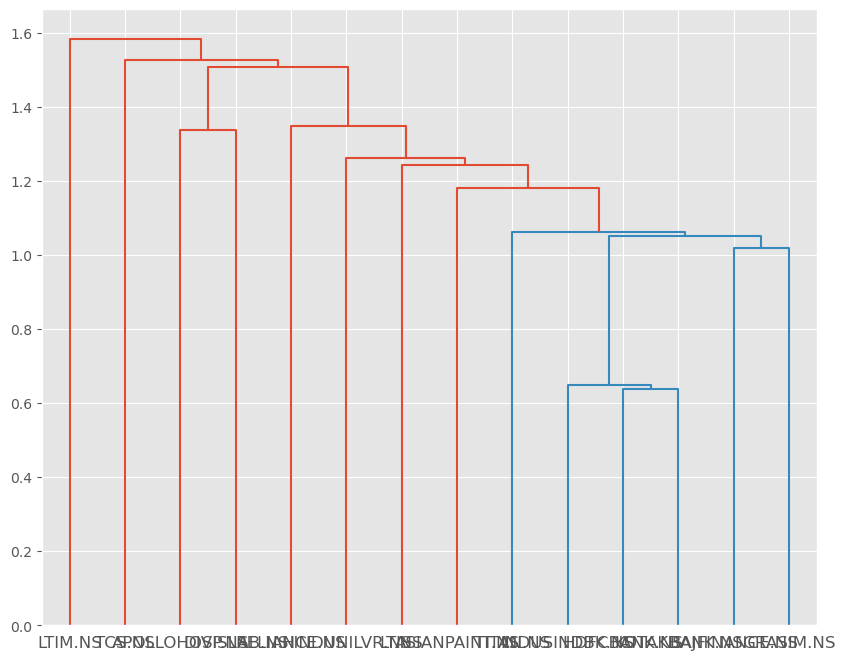

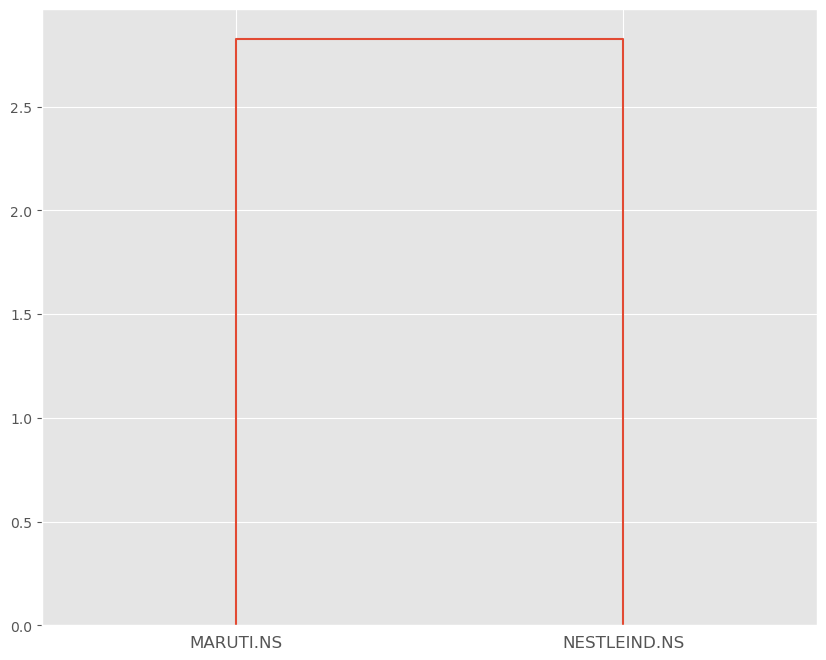

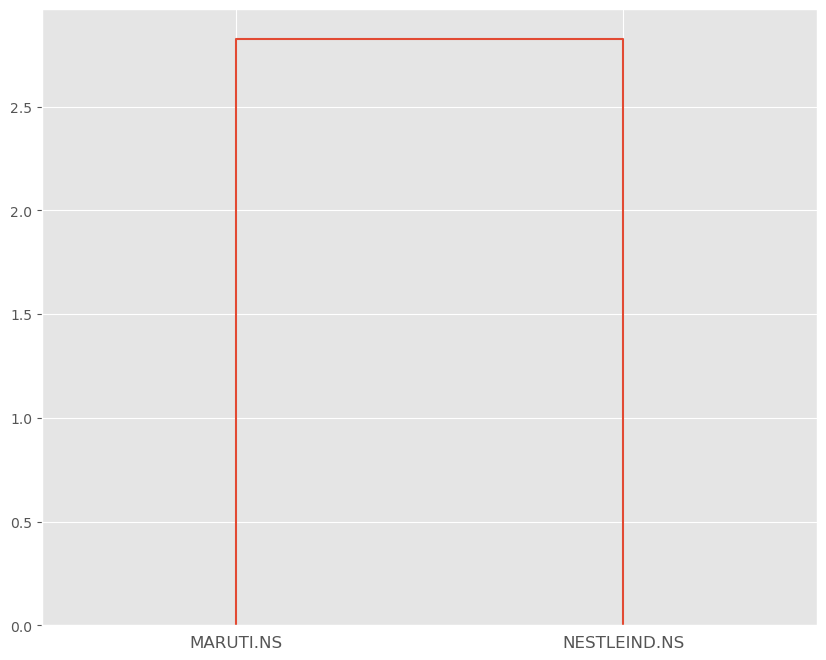

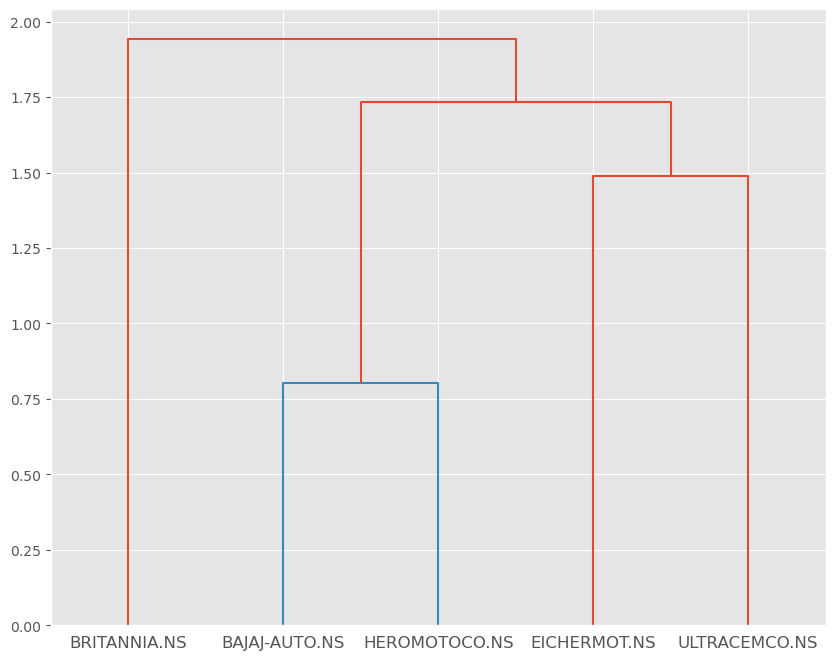

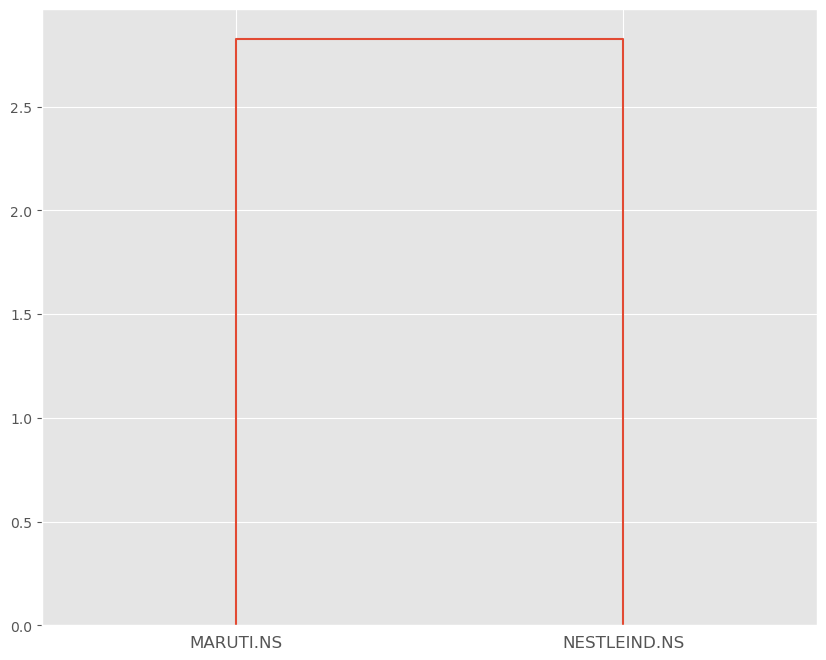

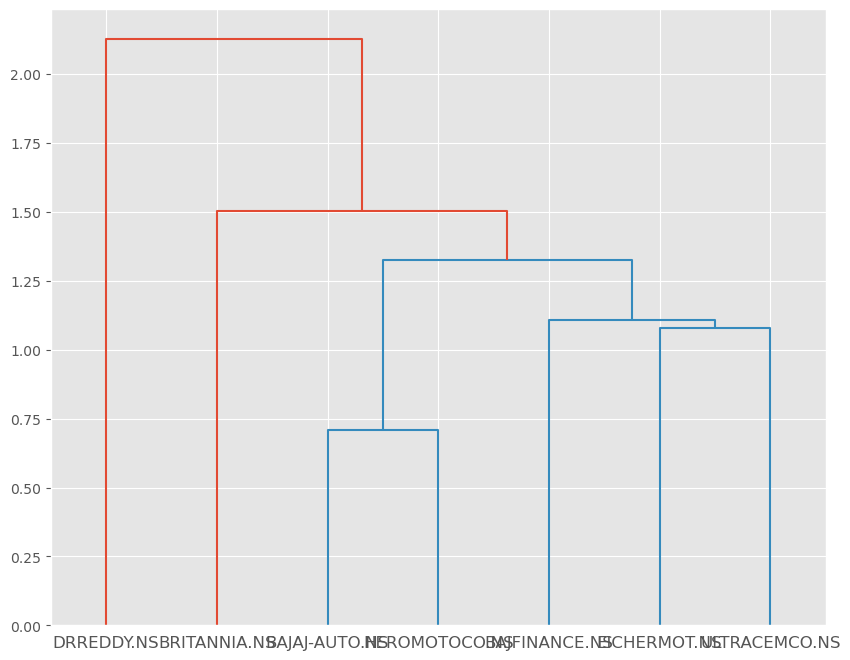

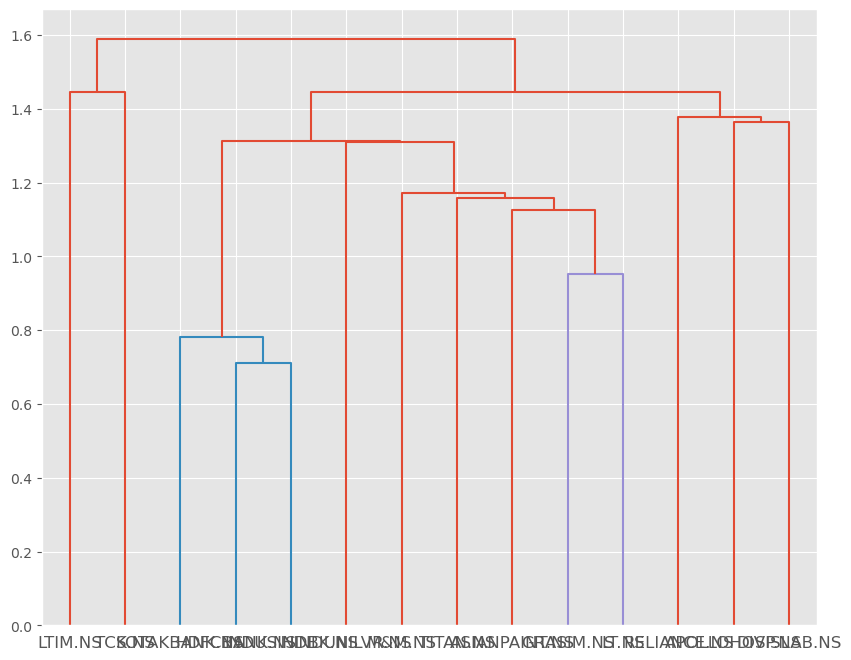

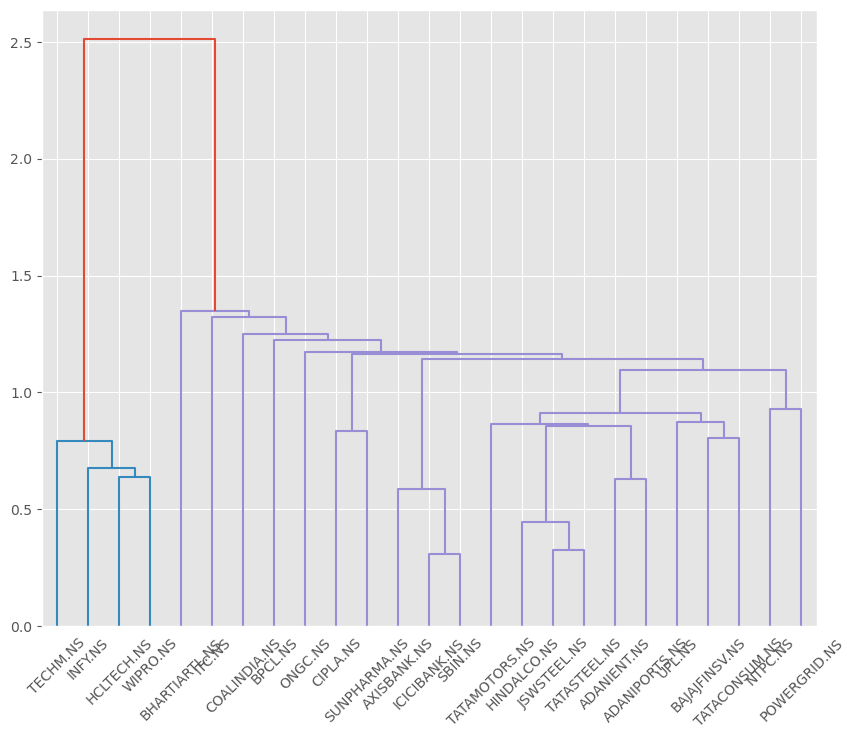

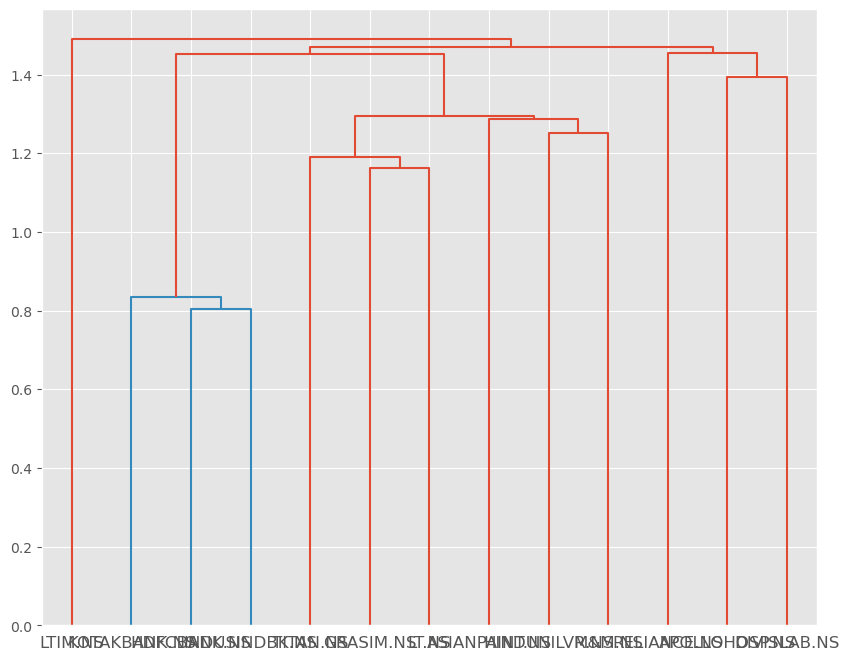

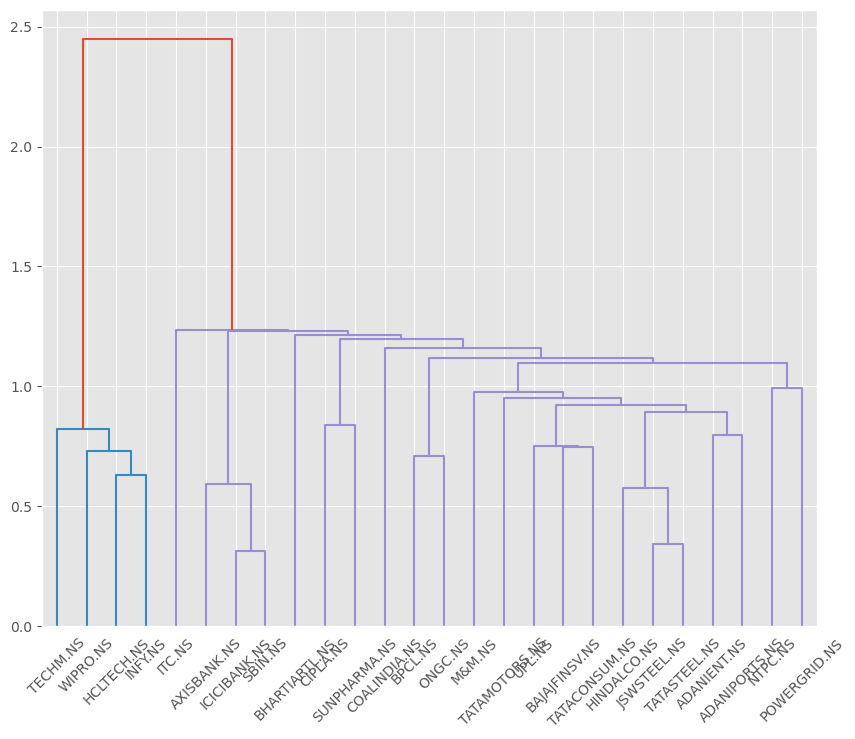

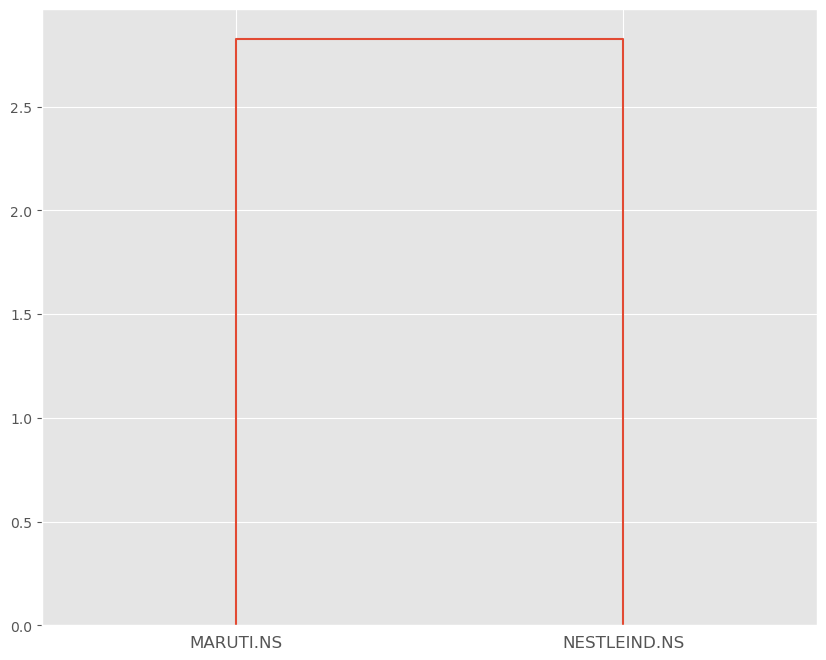

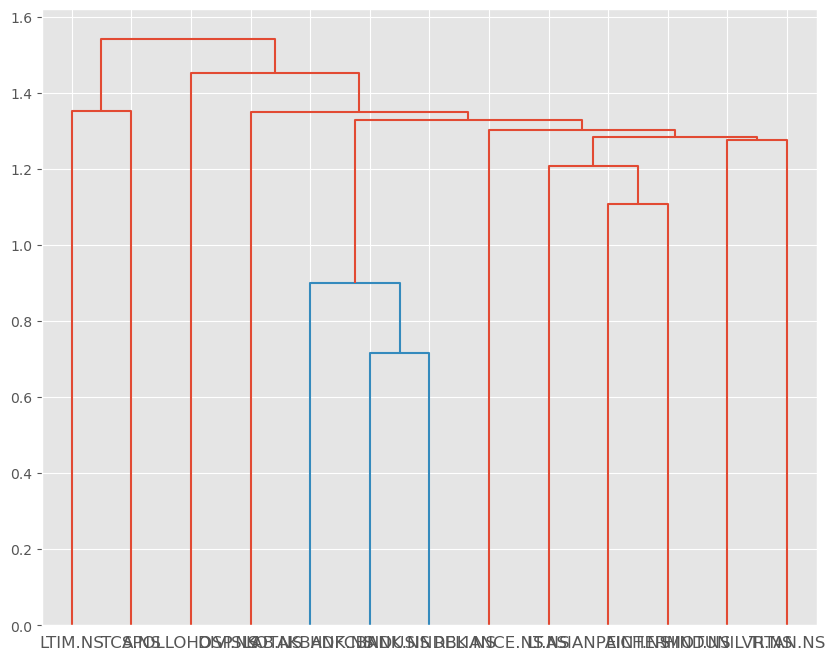

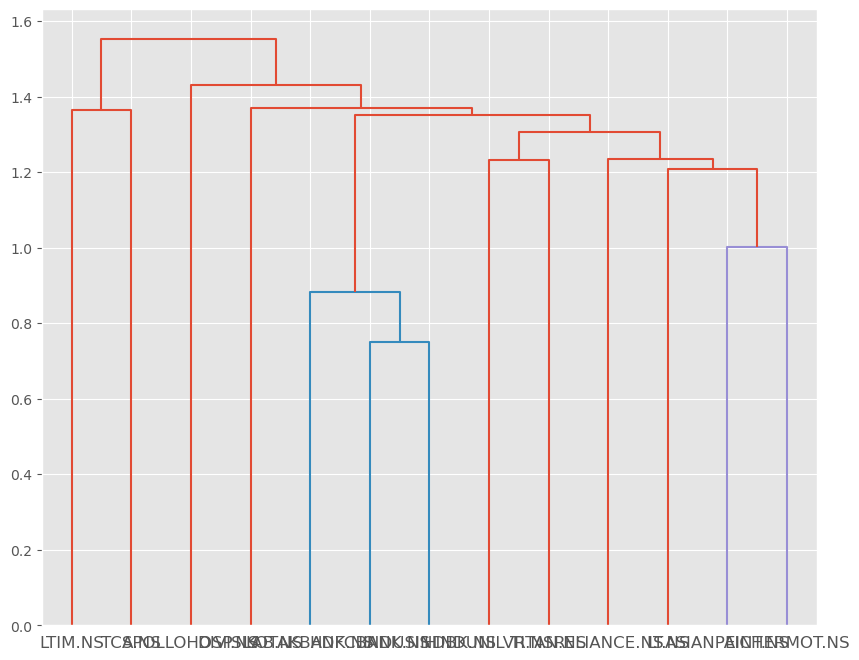

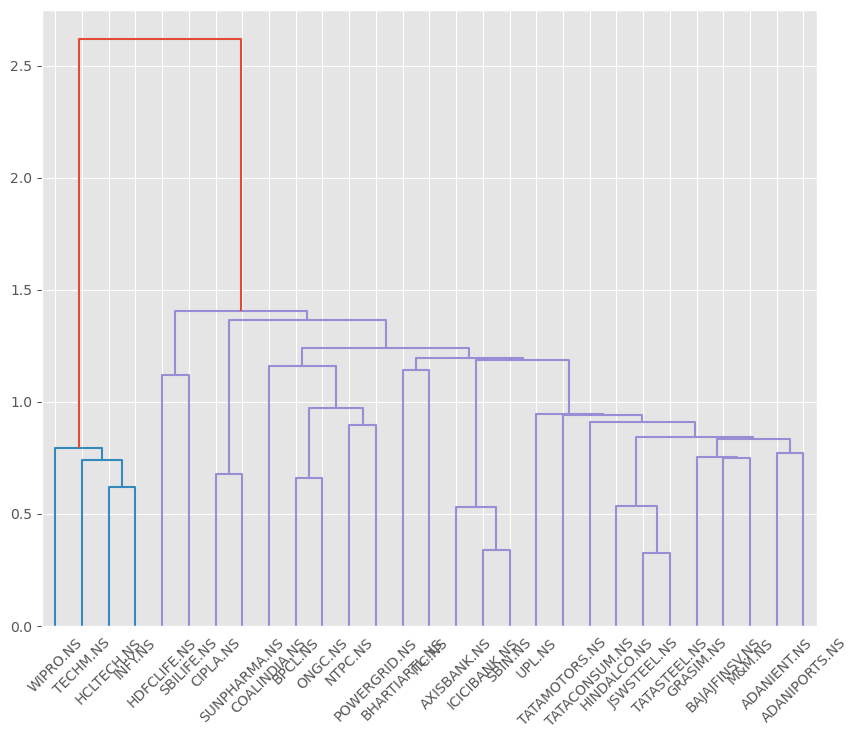

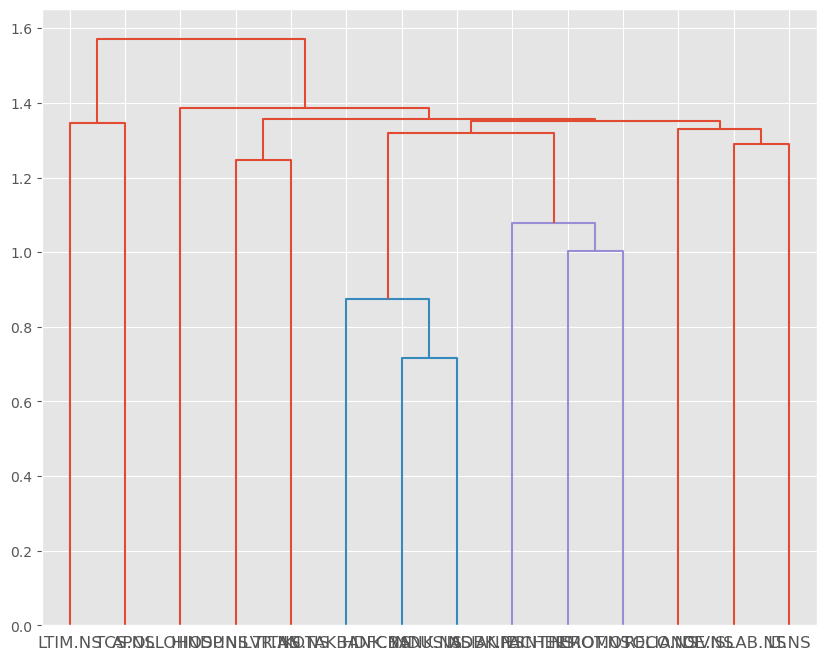

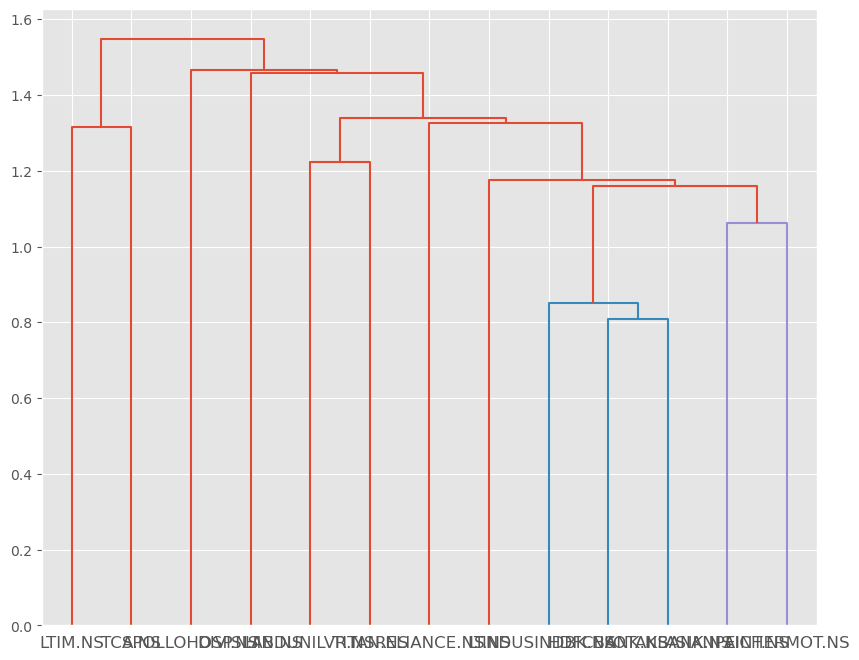

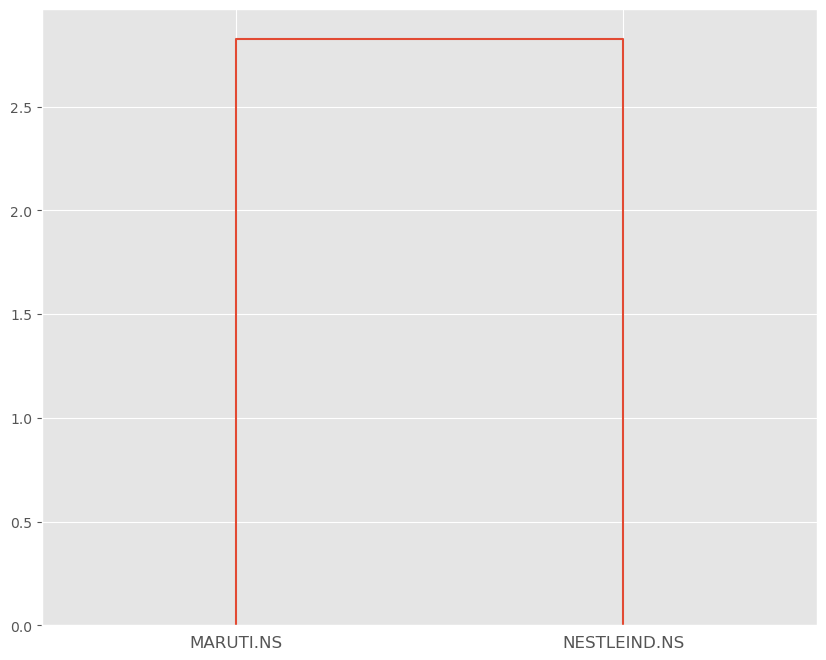

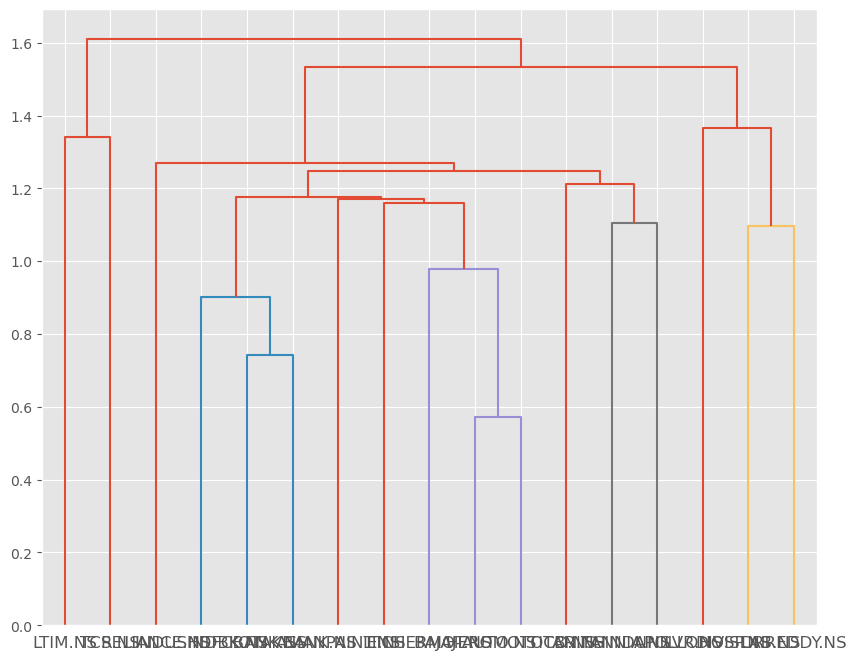

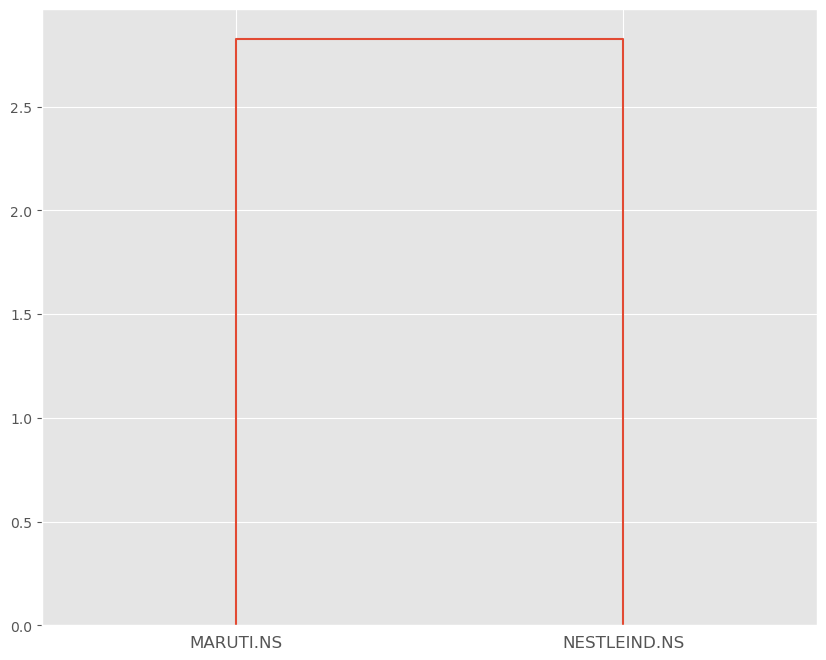

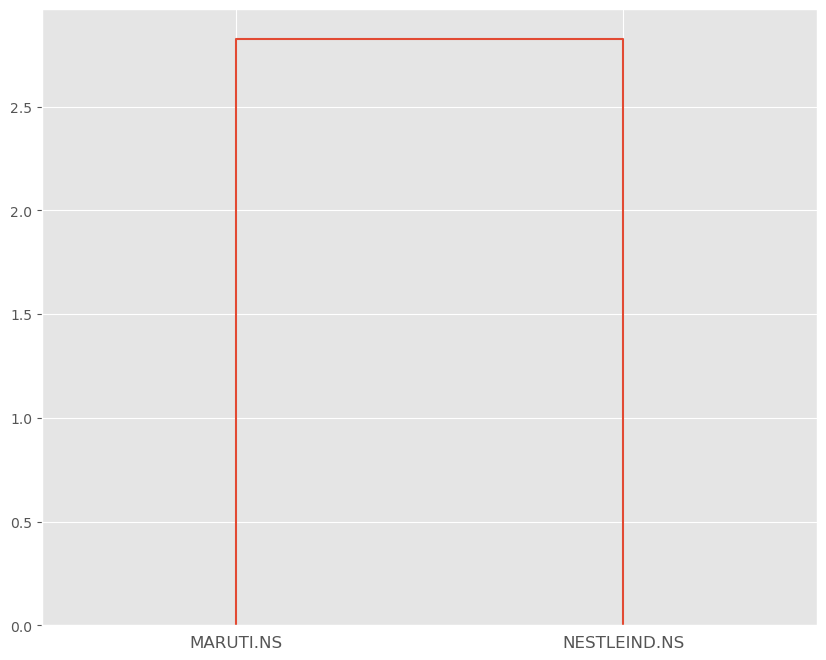

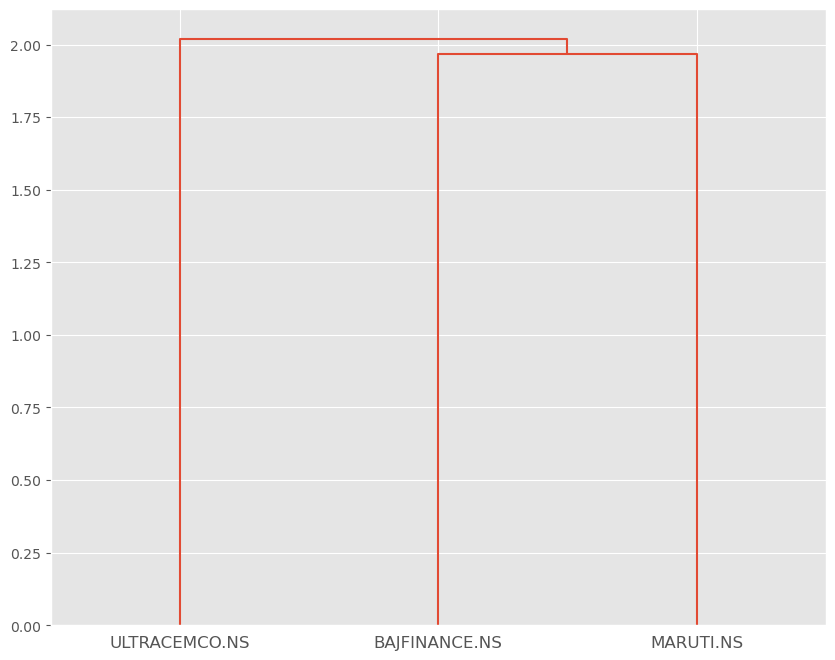

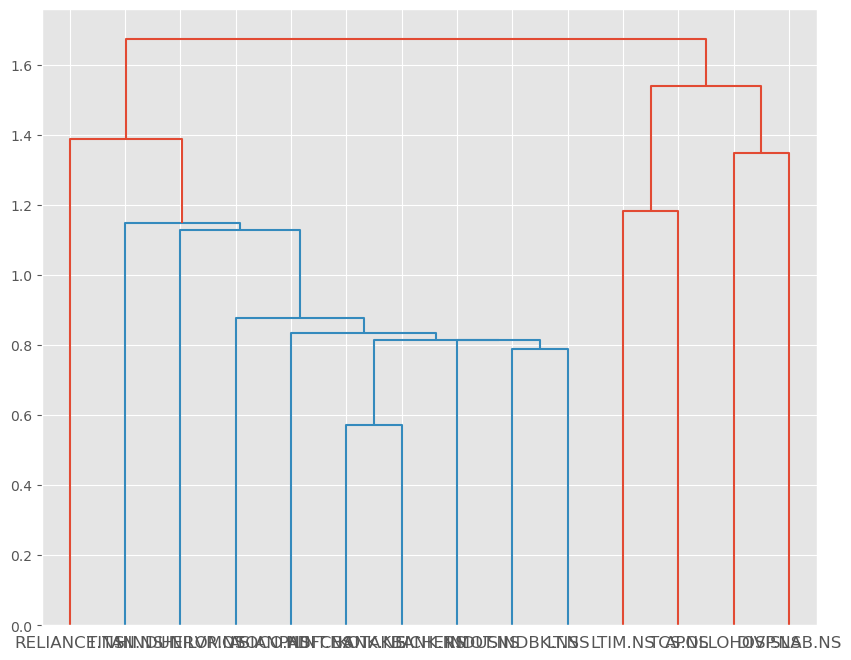

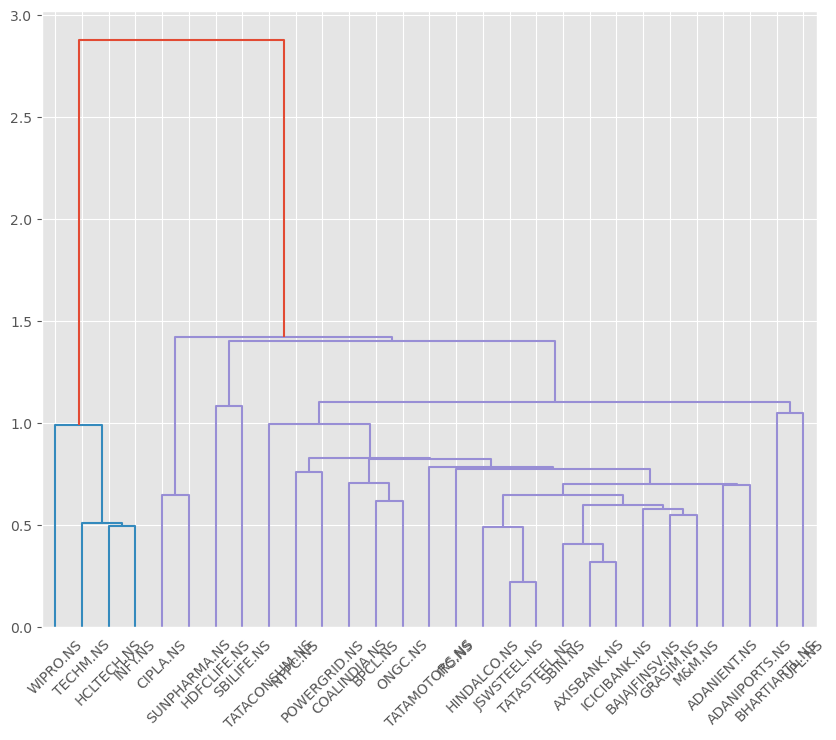

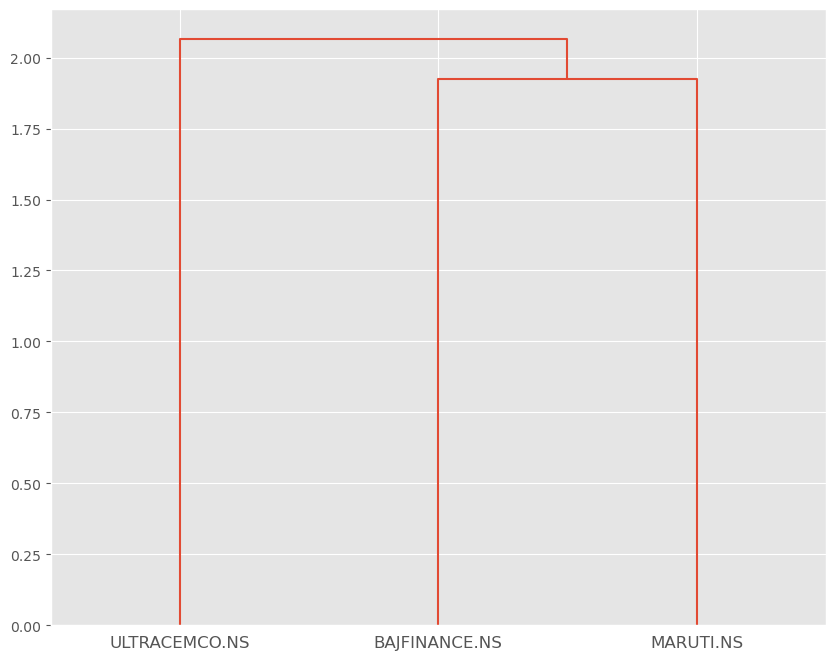

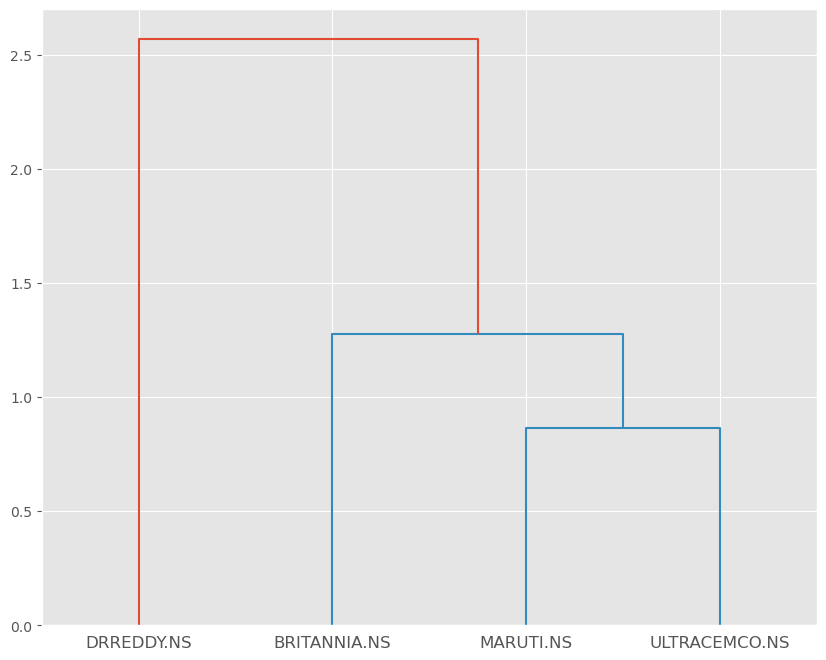

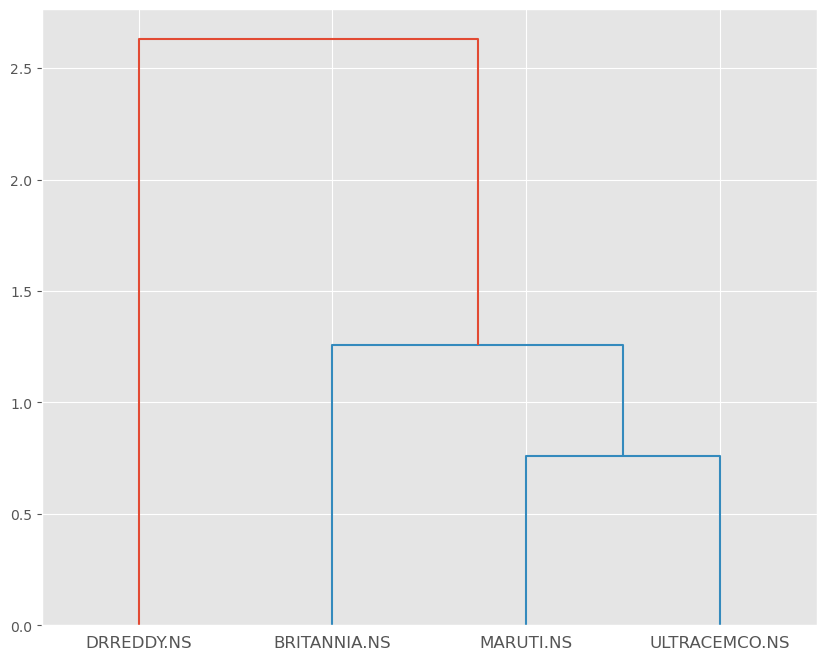

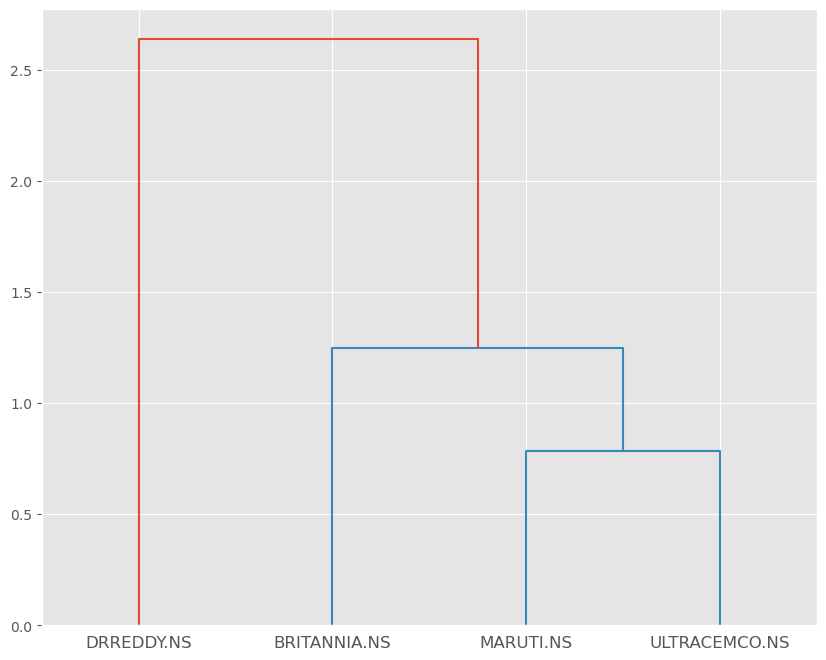

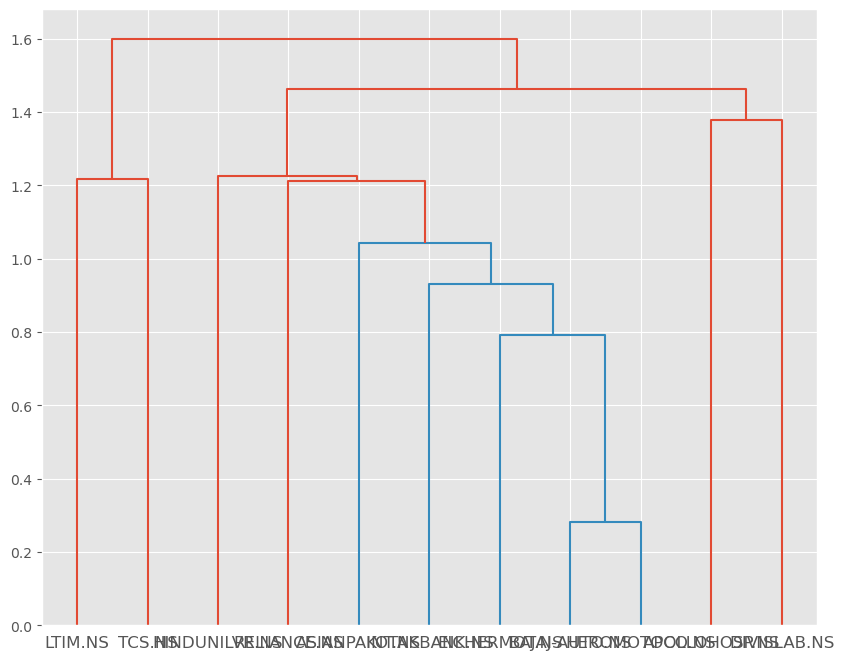

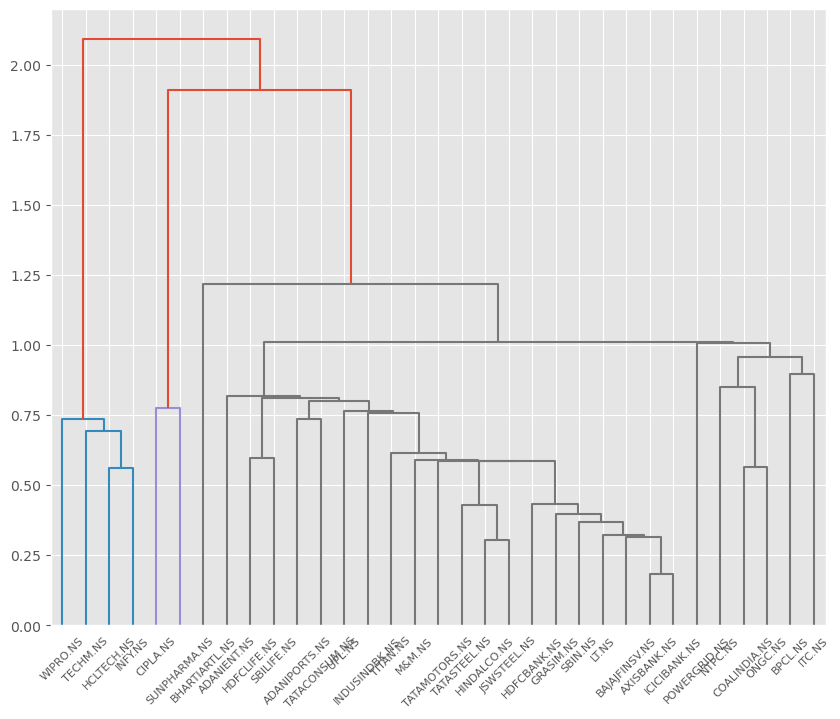

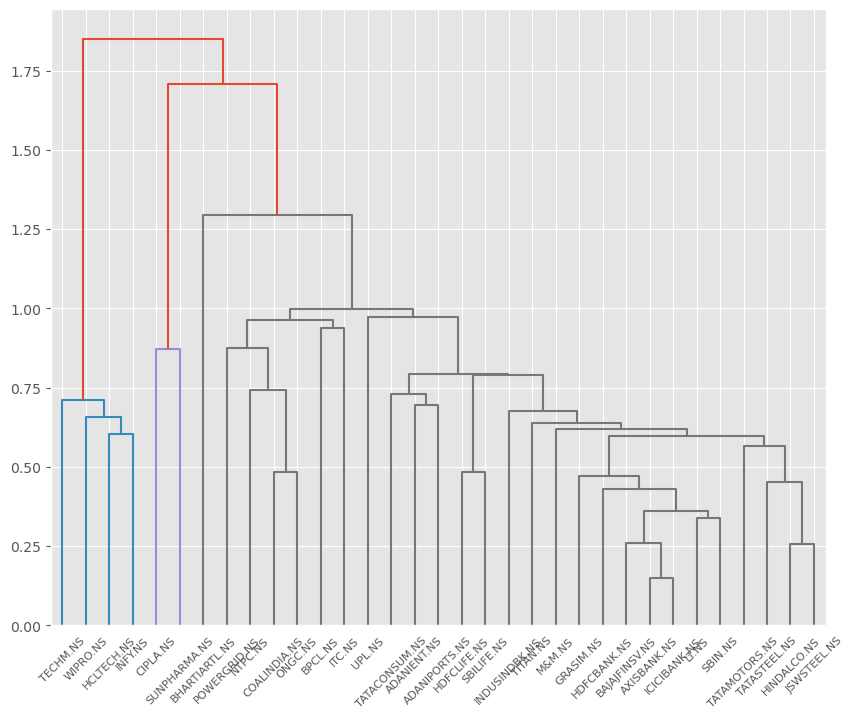

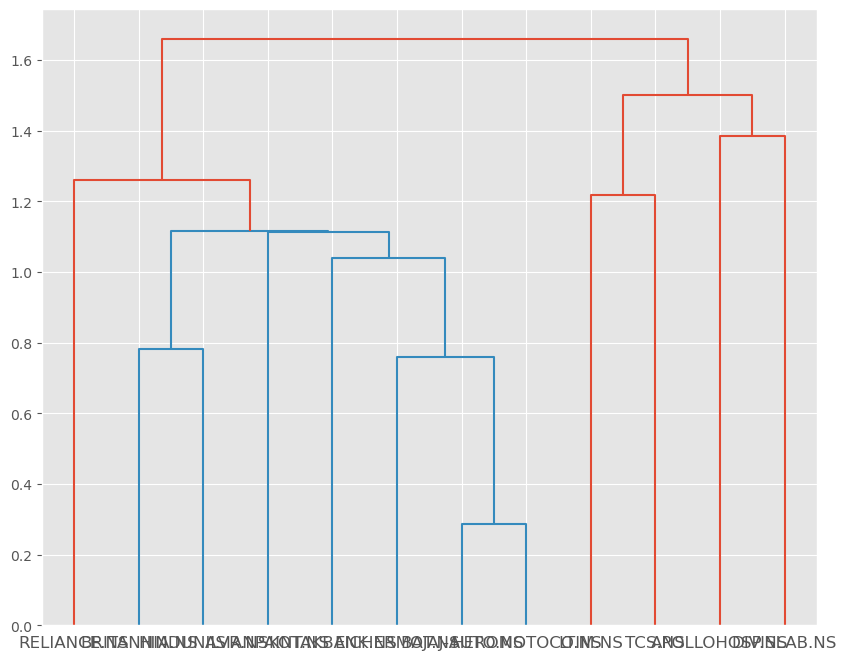

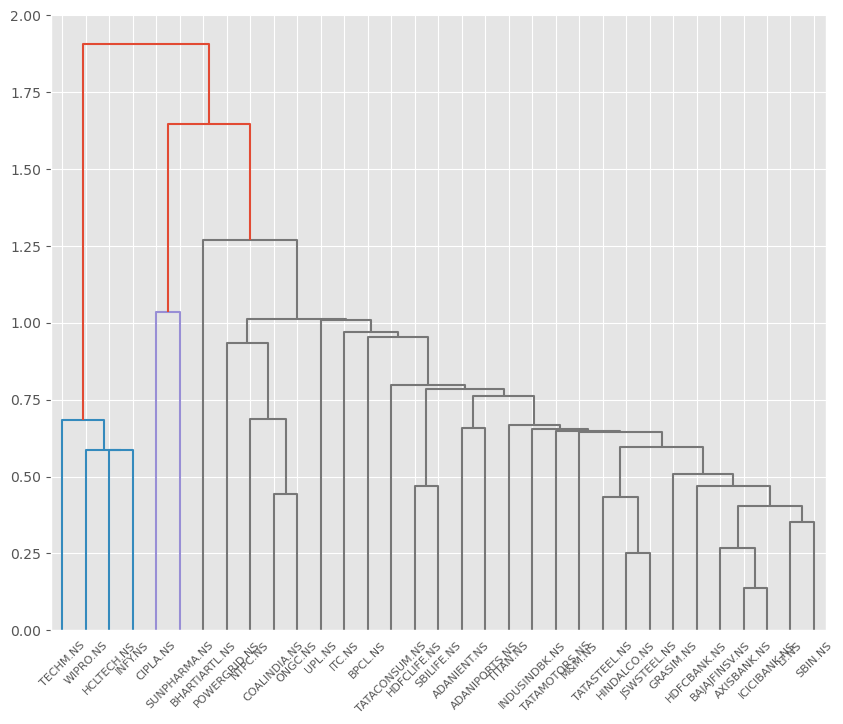

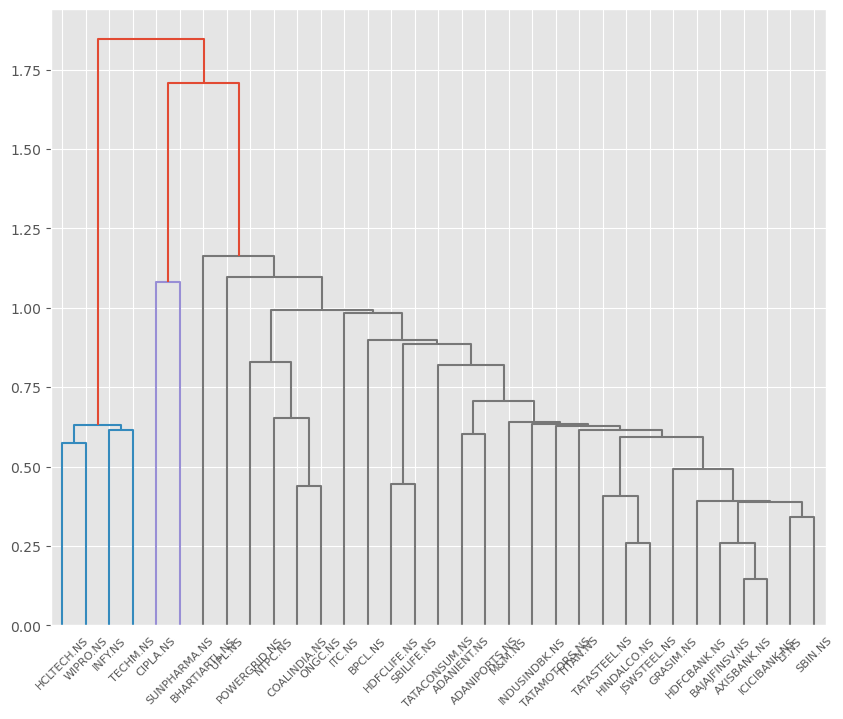

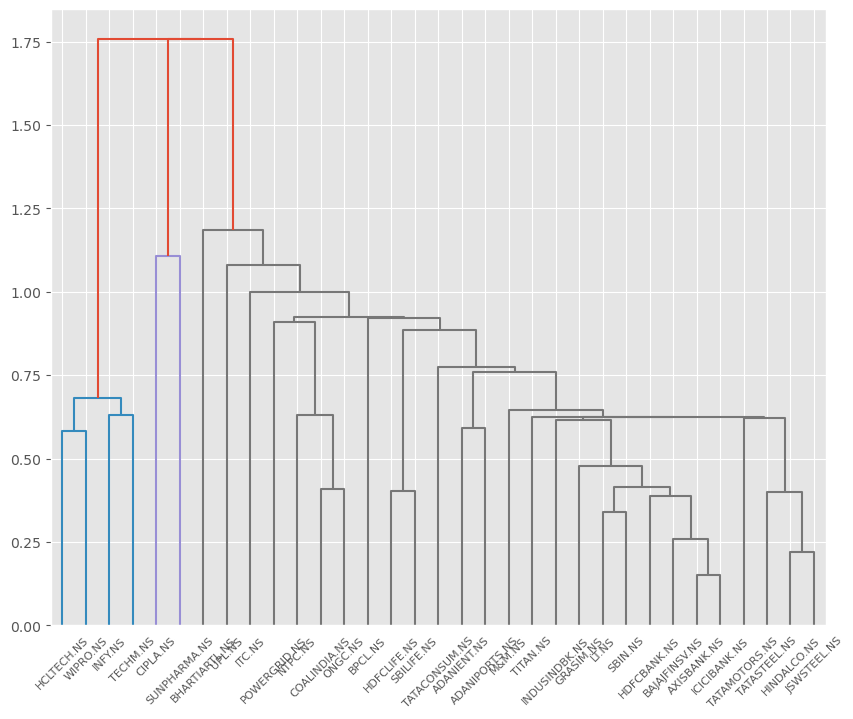

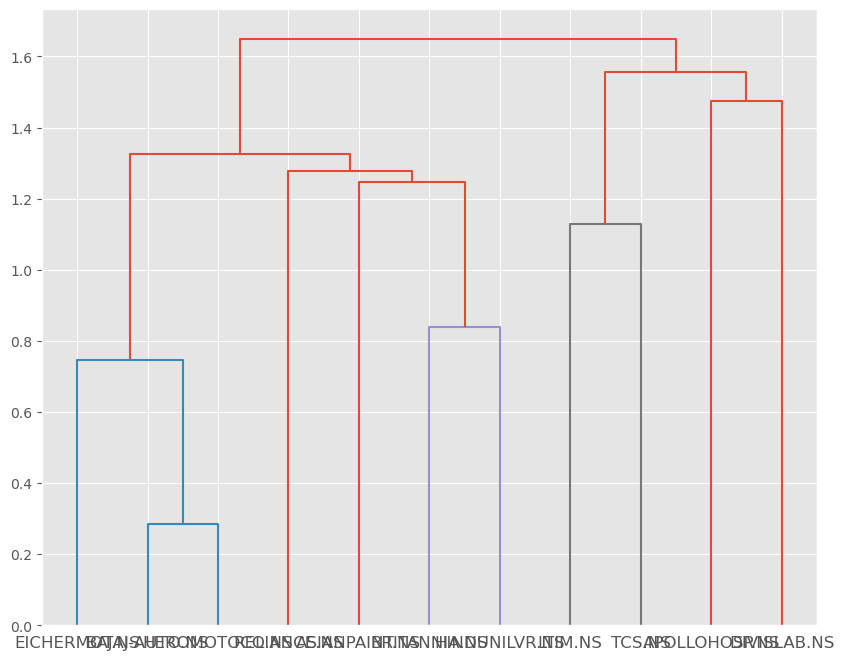

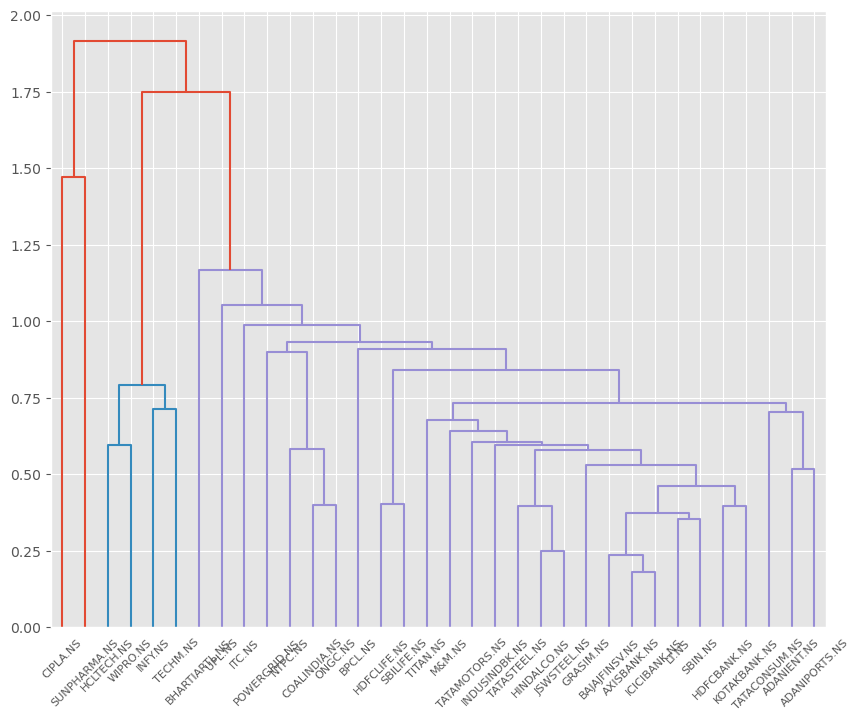

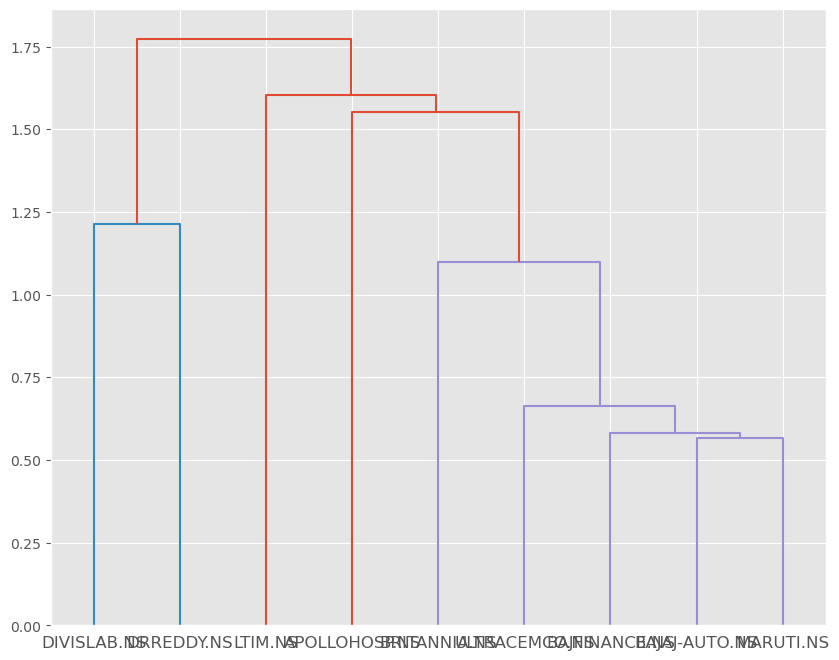

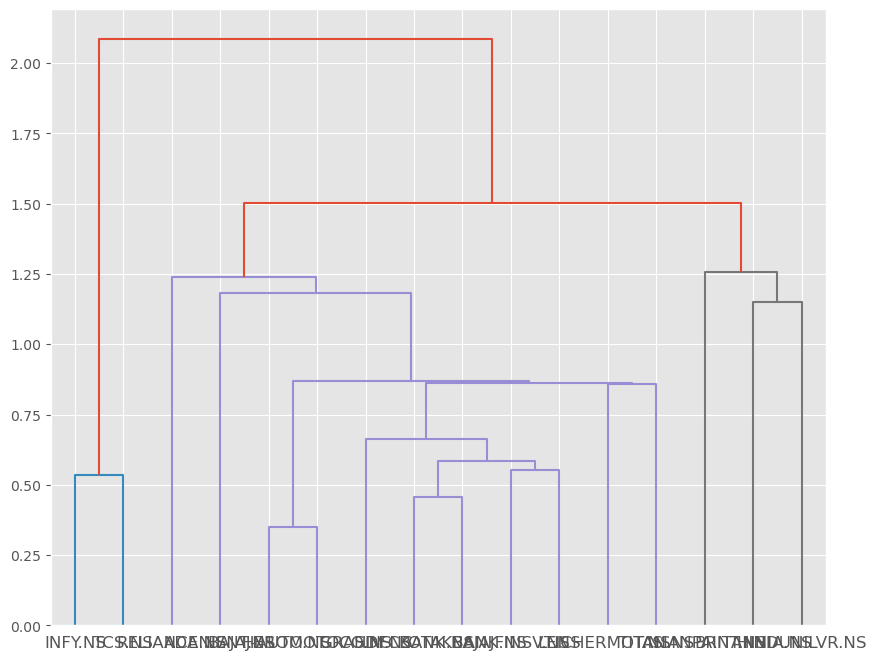

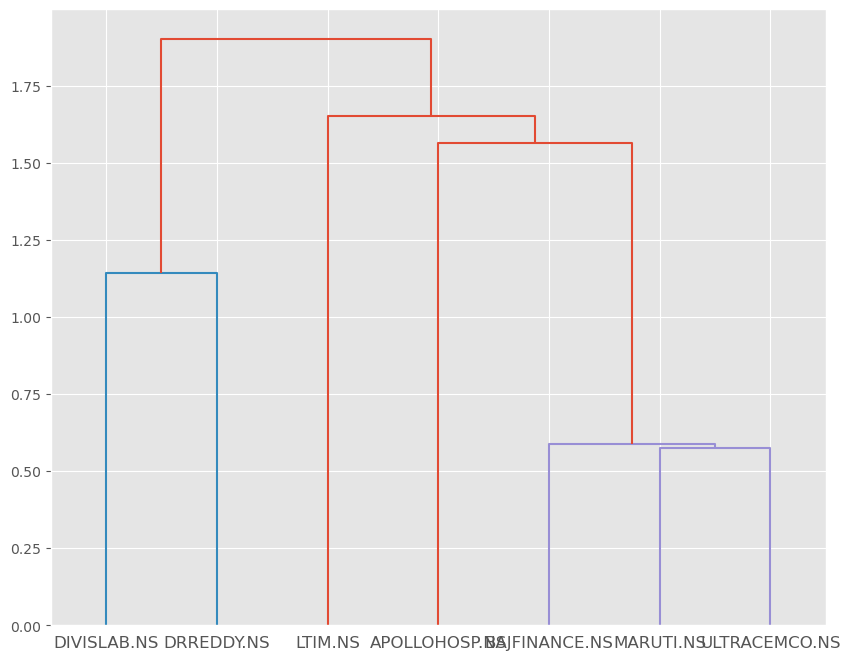

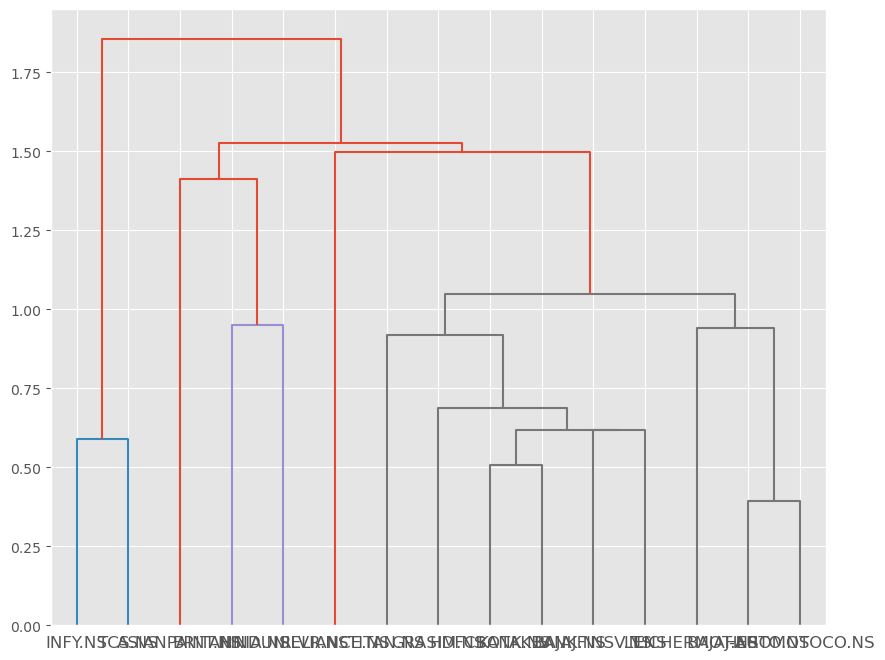

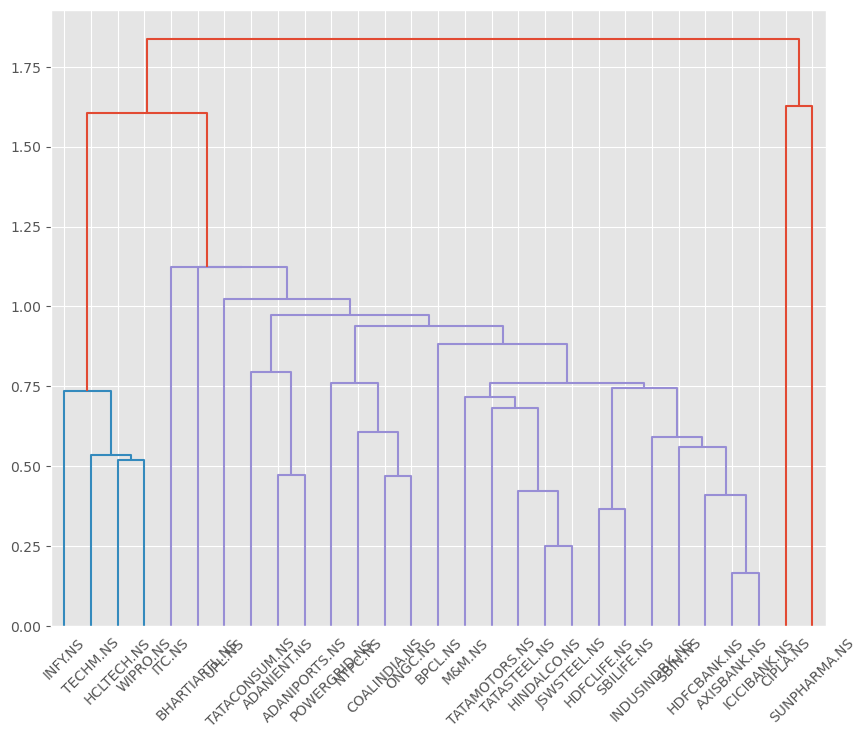

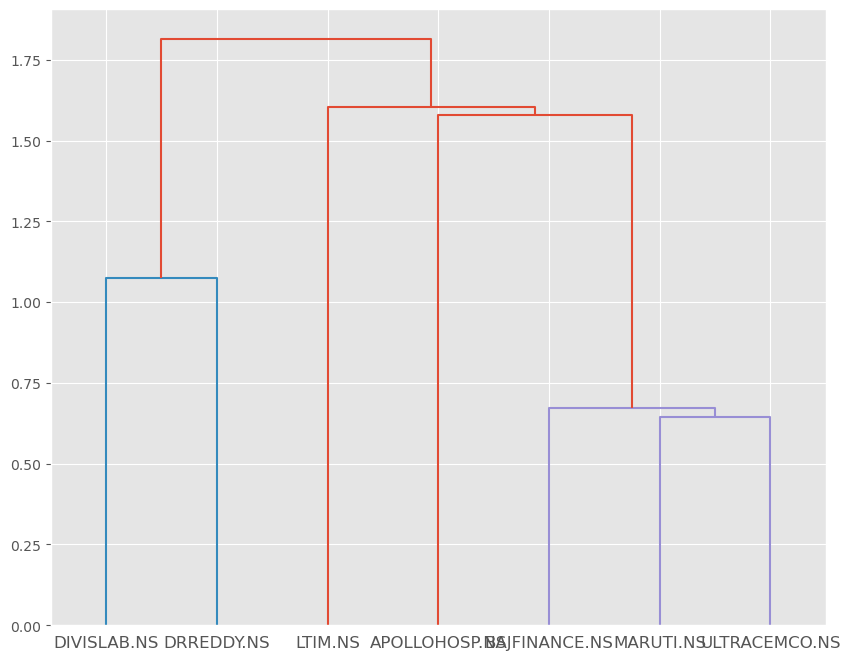

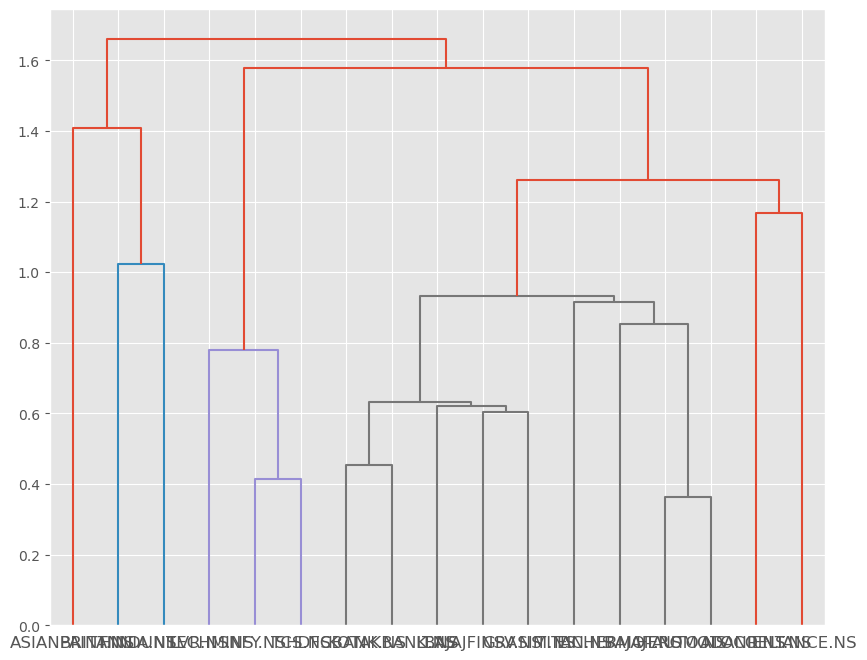

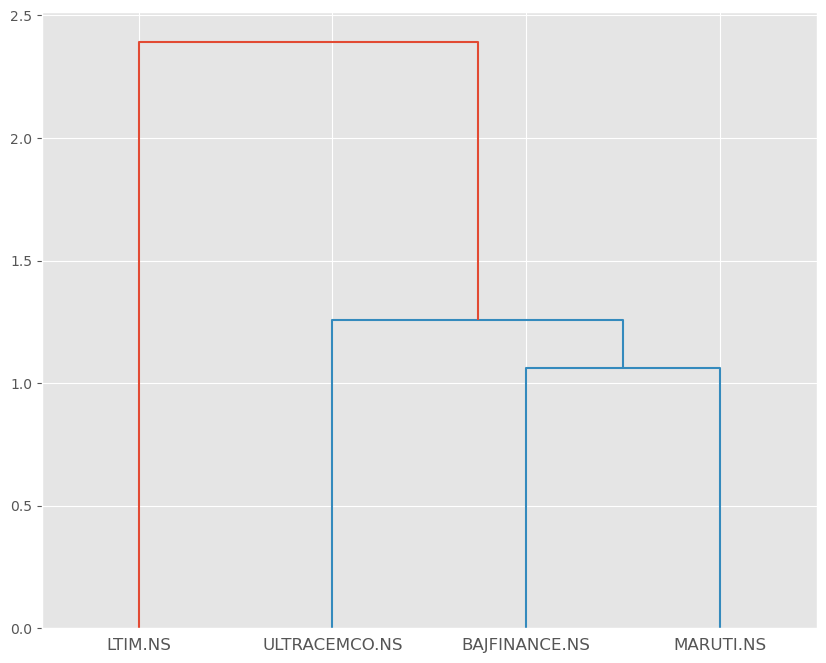

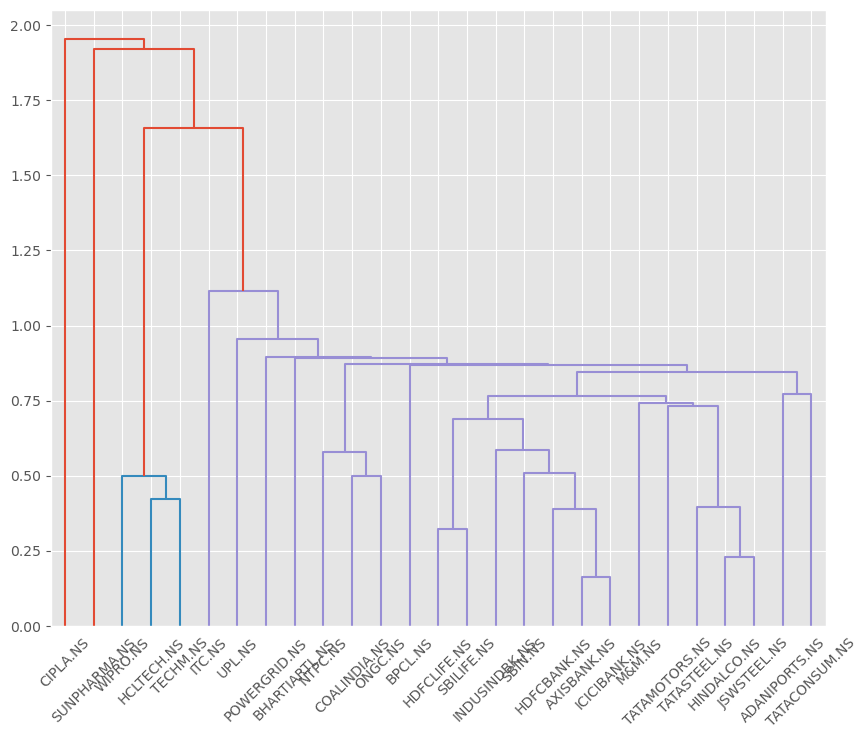

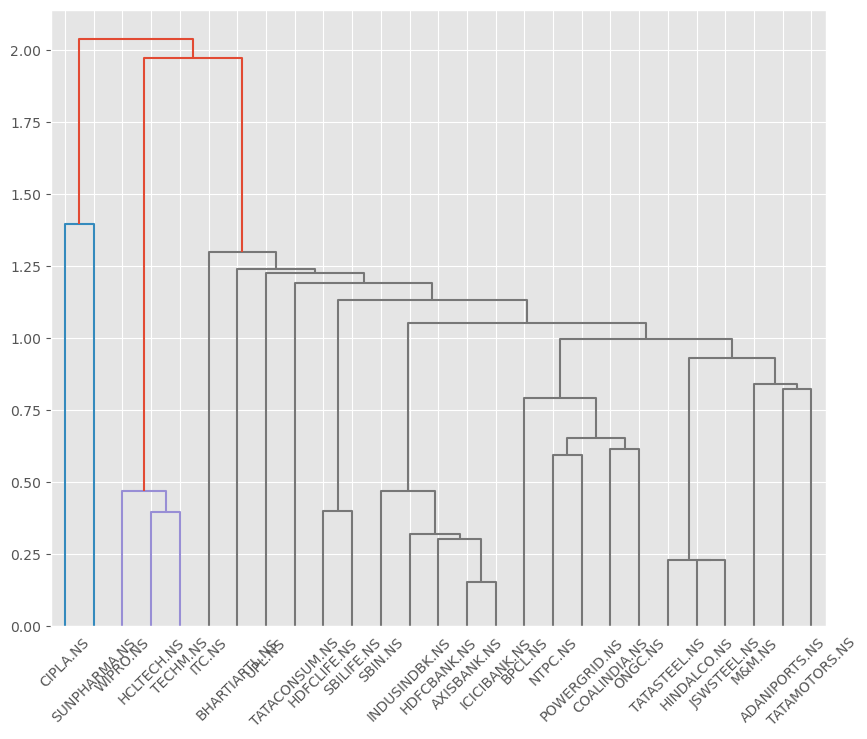

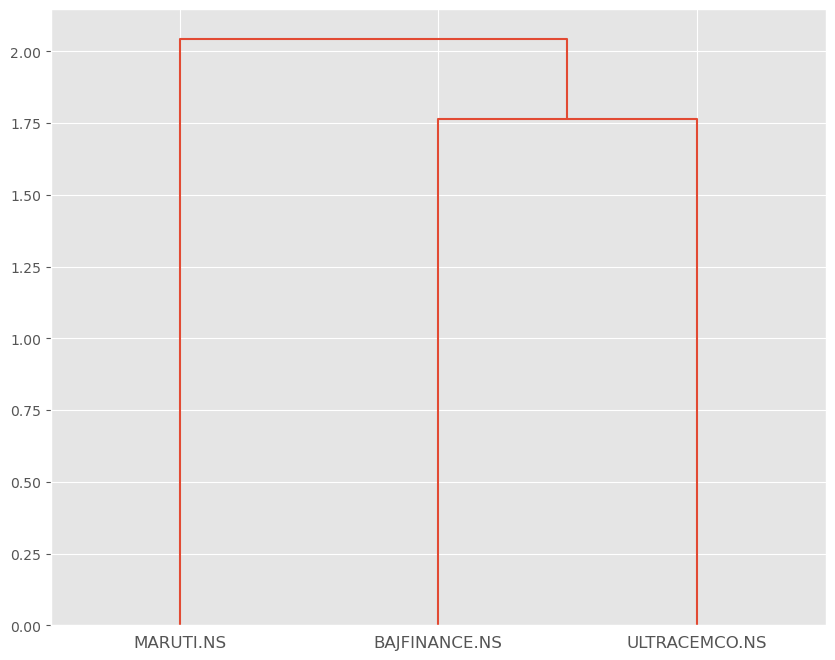

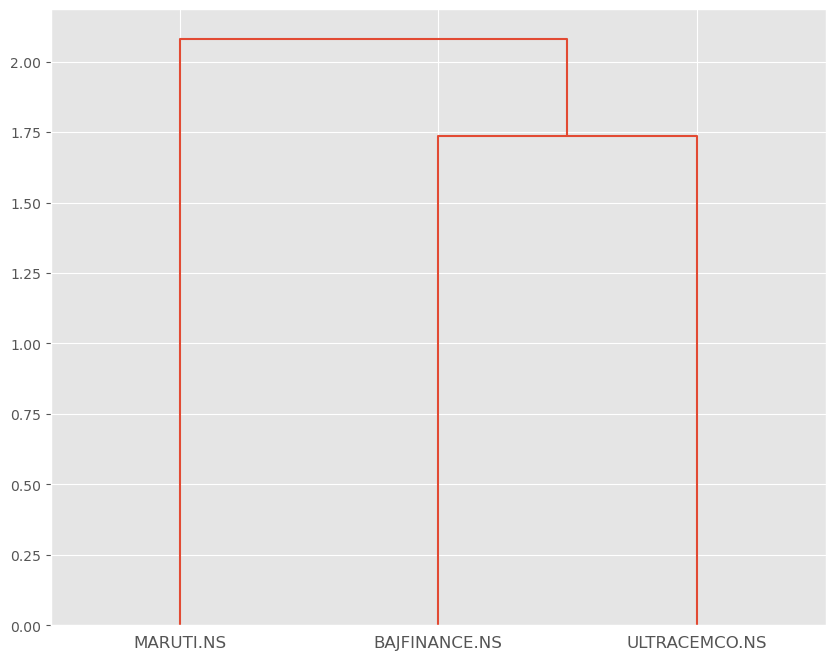

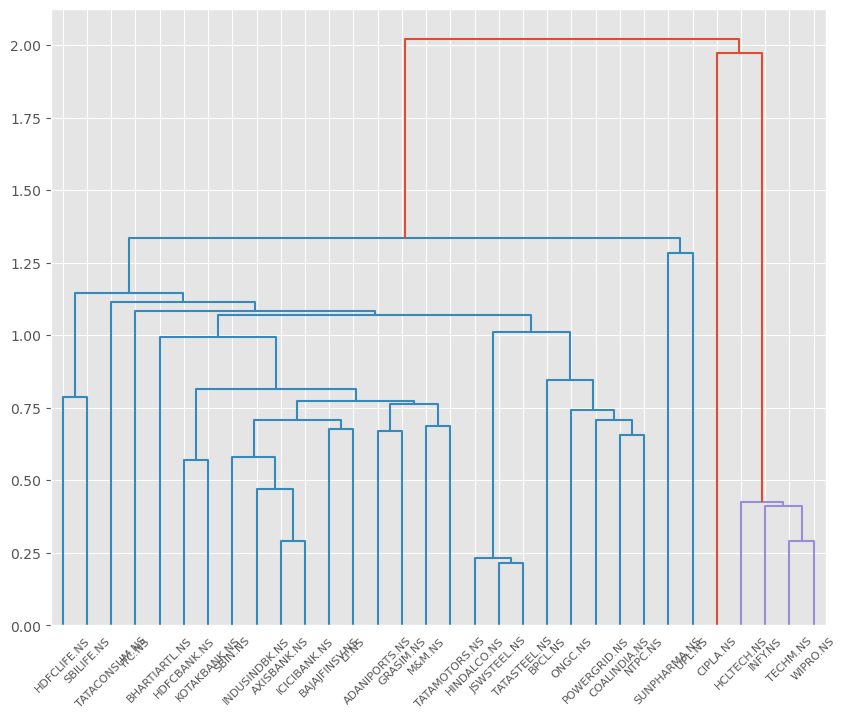

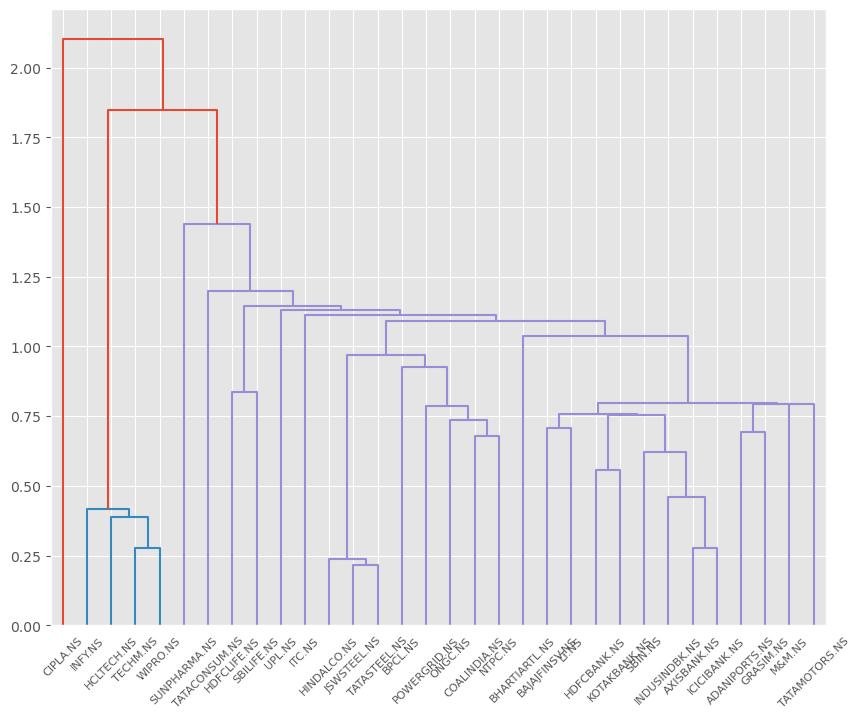

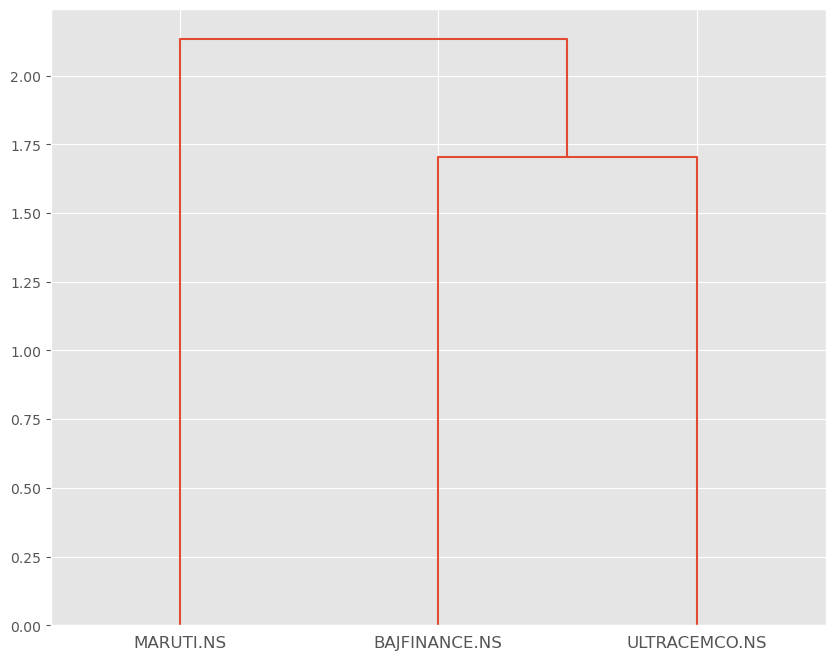

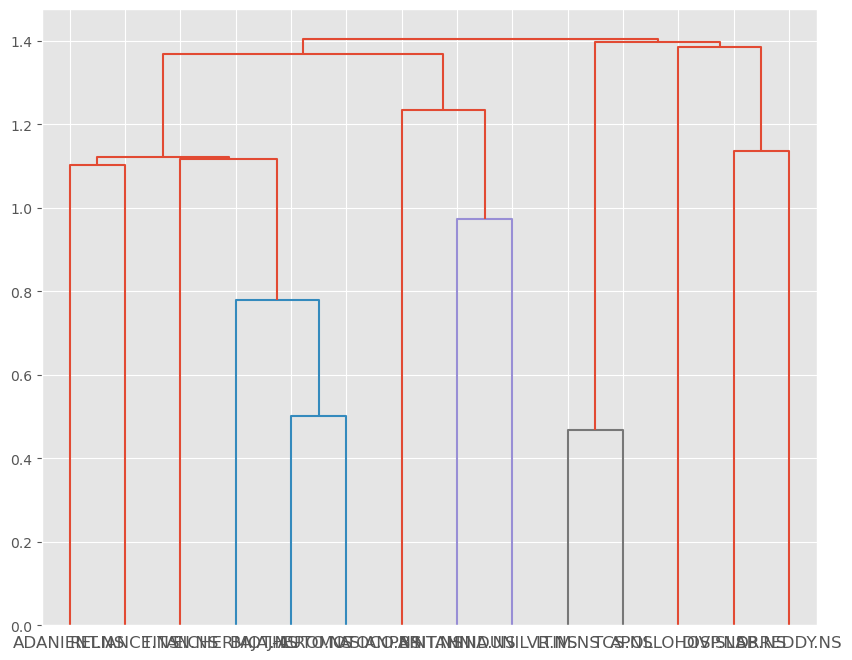

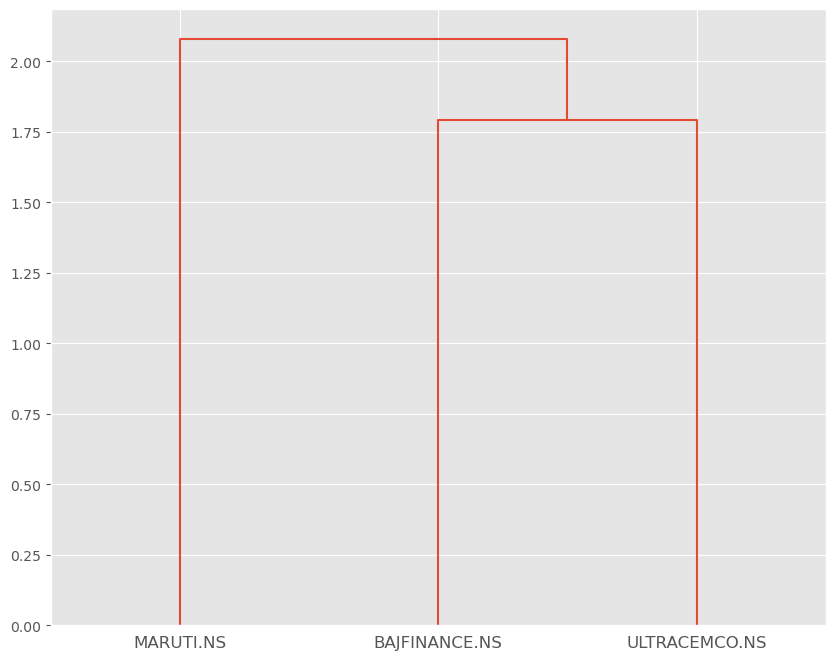

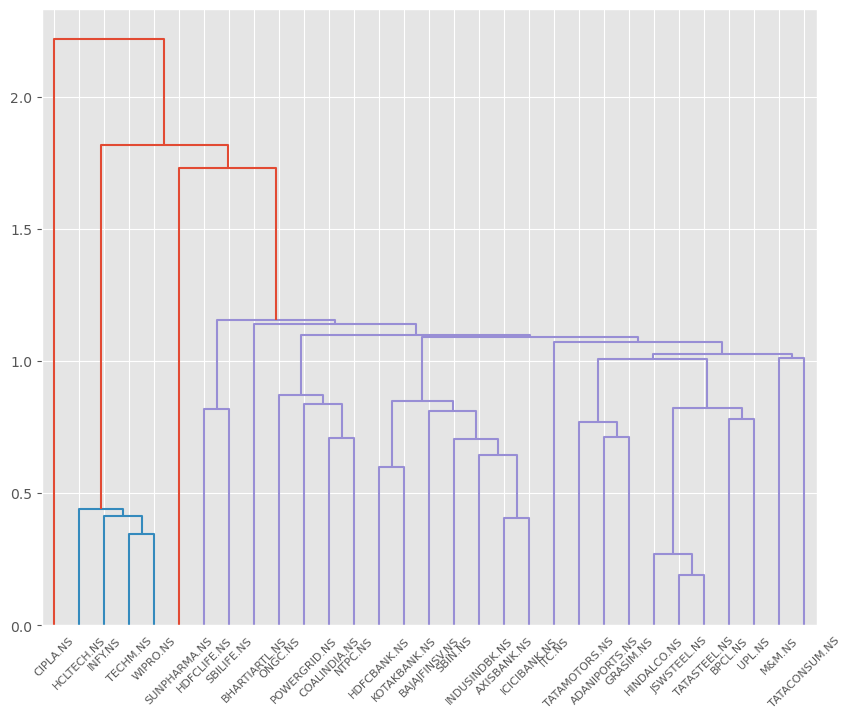

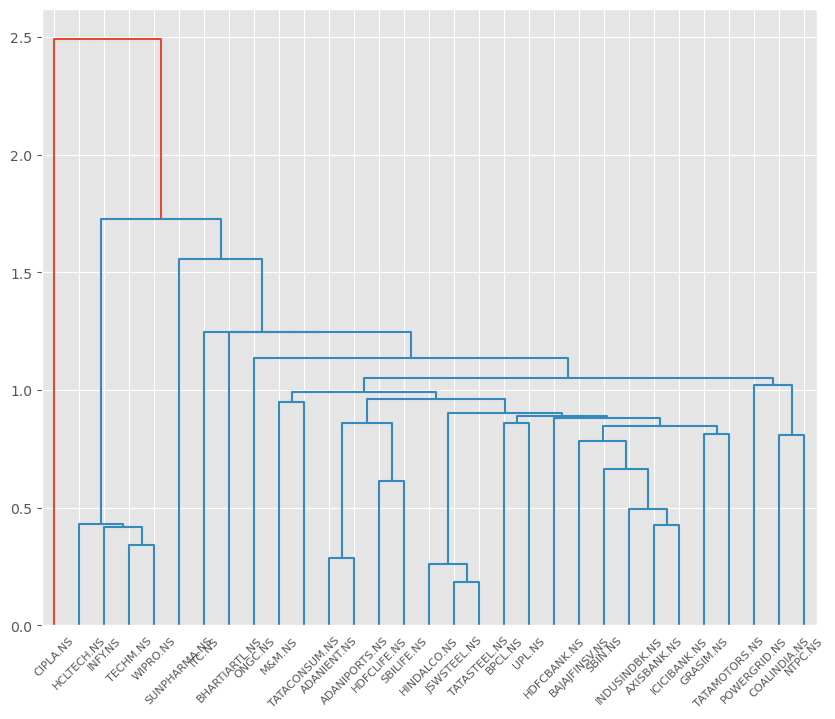

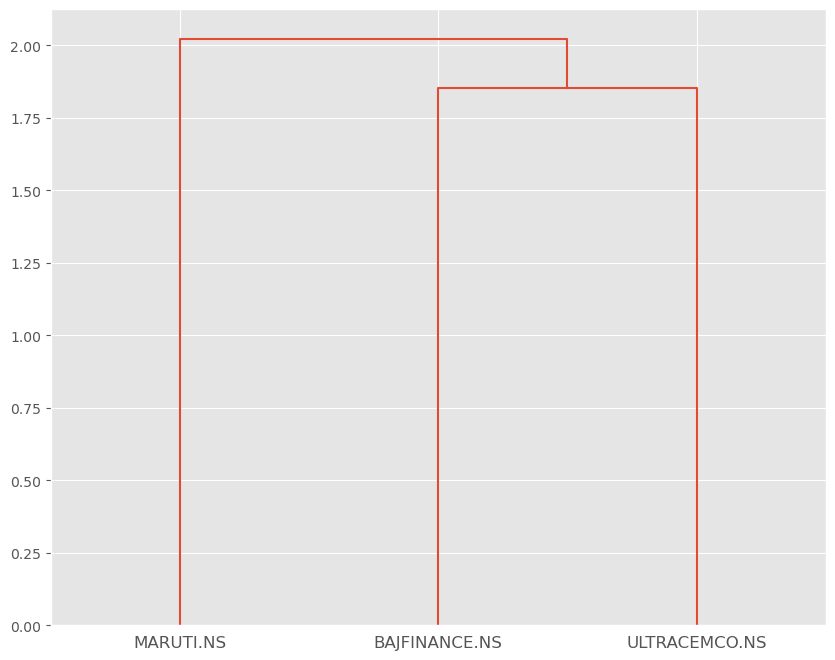

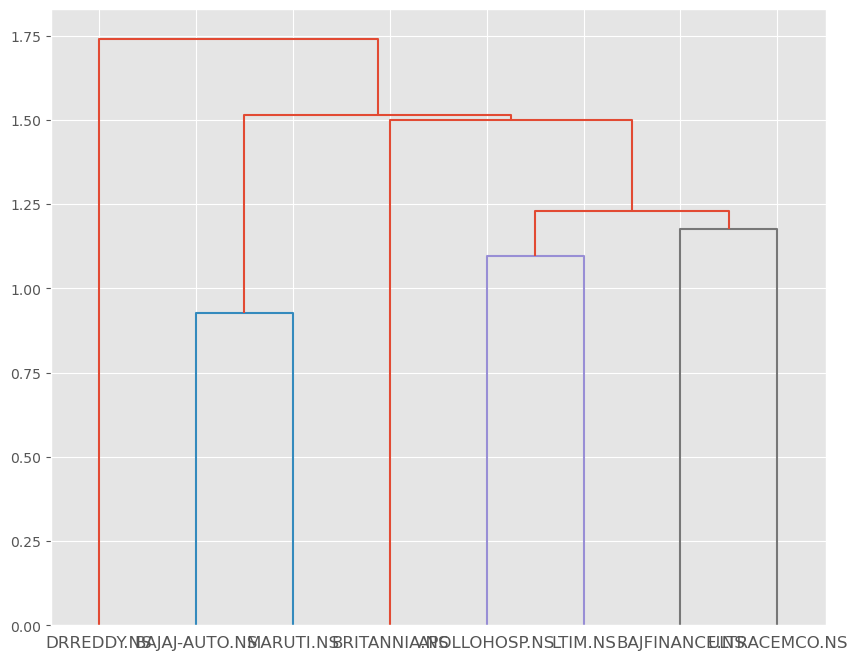

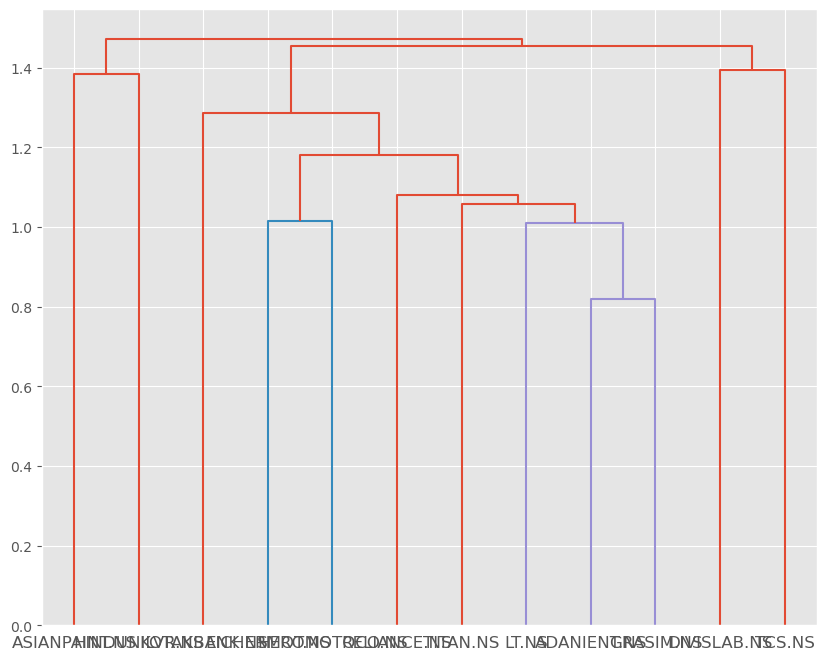

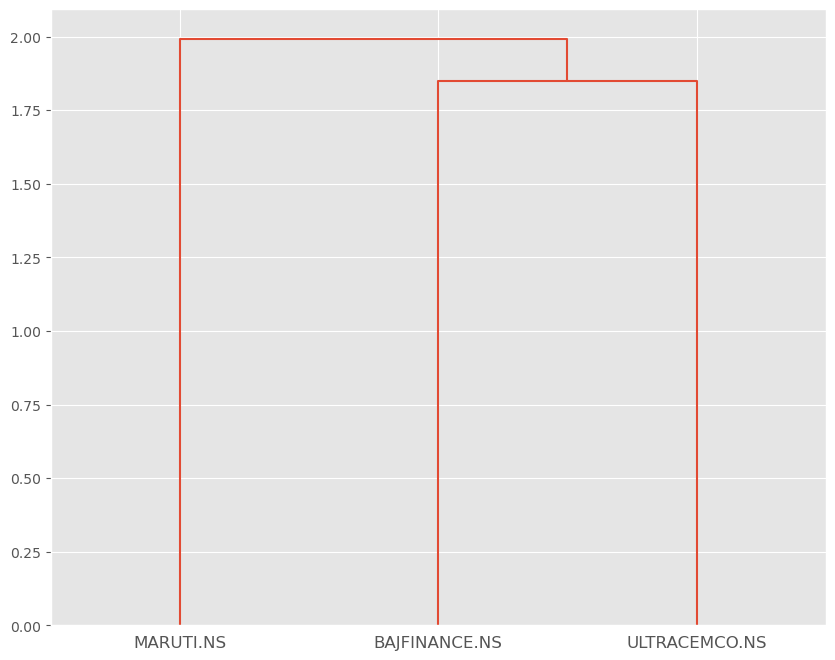

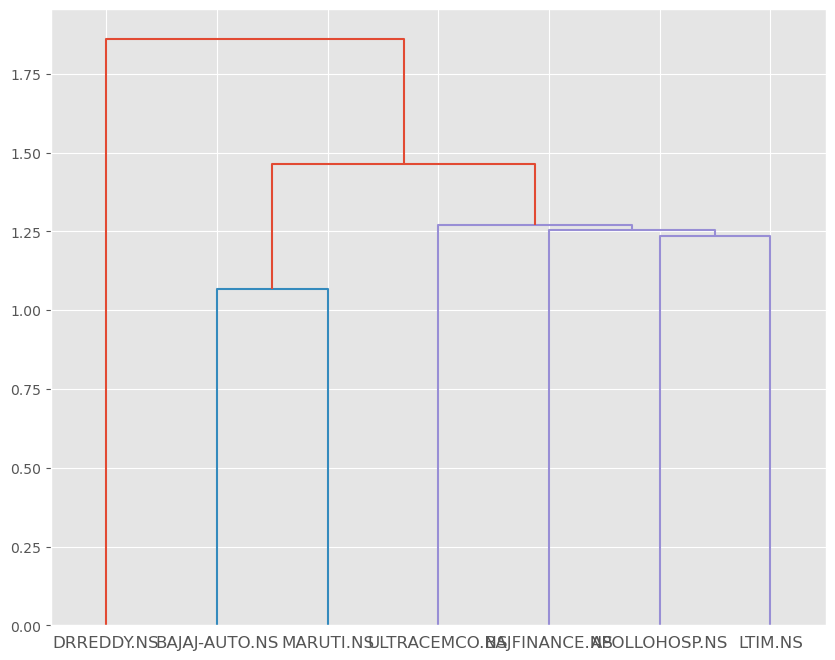

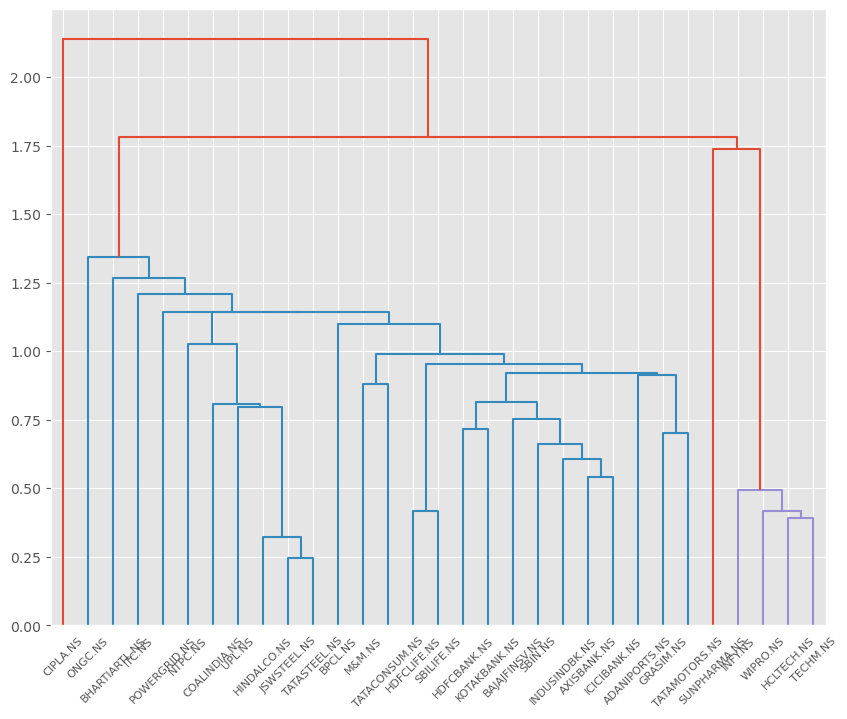

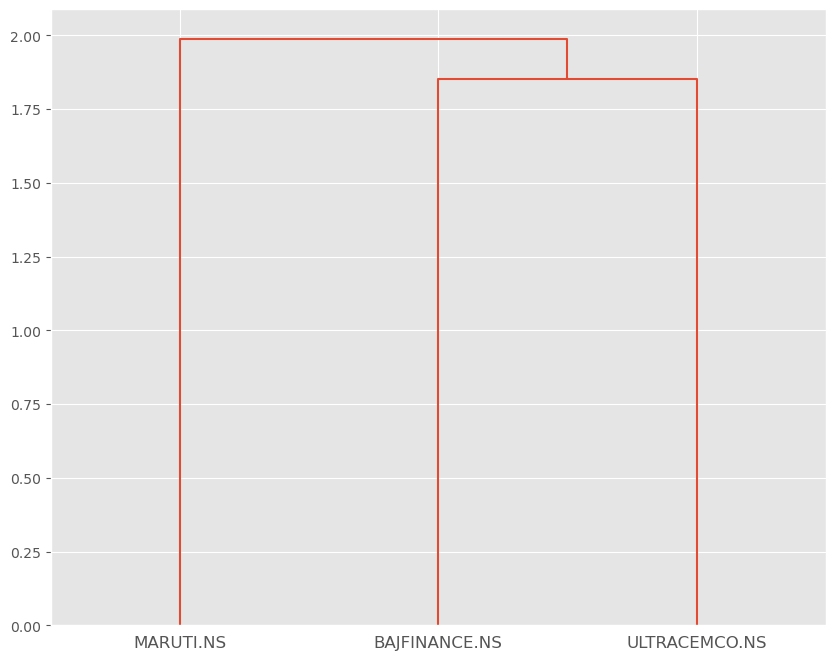

In [25]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=24)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            #weights = optimize_weights(prices=optimization_df,
            #                       lower_bound=round(1/(len(optimization_df.columns)*2),3))

            #weights = pd.DataFrame(weights, index=pd.Series(0))
            
           
            # Replace the existing optimization section with HRP method
            cov_matrix = optimization_df.pct_change().cov()  # You can use your own covariance calculation method
            weights = hrp_weights(cov_matrix)


           # Convert weights to a DataFrame
            weights = pd.DataFrame(weights, index=optimization_df.columns)
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

In [26]:
portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Strategy Return
date                       
2019-01-01         0.001512
2019-01-02        -0.028344
2019-01-03        -0.008831
2019-01-04         0.004232
2019-01-07         0.017477
...                     ...
2023-05-25         0.004401
2023-05-26         0.004963
2023-05-29         0.006820
2023-05-30        -0.007159
2023-05-31         0.004562

[184 rows x 1 columns]

### 7. Visualize Portfolio returns and compare to SP500 returns.

In [70]:
nifty_df = yf.download("^NSEI", start, end, interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [71]:
nifty_ret = np.log(nifty_df[['Adj Close']]).diff().dropna().rename({'Adj Close':'Nifty Buy&Hold'}, axis=1)


In [72]:
portfolio_df = portfolio_df.merge(nifty_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

Strategy Return  Nifty Buy&Hold
2019-01-02        -0.028344       -0.006470
2019-01-03        -0.008831       -0.011205
2019-01-04         0.004232        0.005150
2019-01-07         0.017477        0.004135
2019-01-08         0.010465        0.002814
...                     ...             ...
2023-05-25         0.004401        0.001953
2023-05-26         0.004963        0.009679
2023-05-29         0.006820        0.005353
2023-05-30        -0.007159        0.001891
2023-05-31         0.004562       -0.005351

[182 rows x 2 columns]

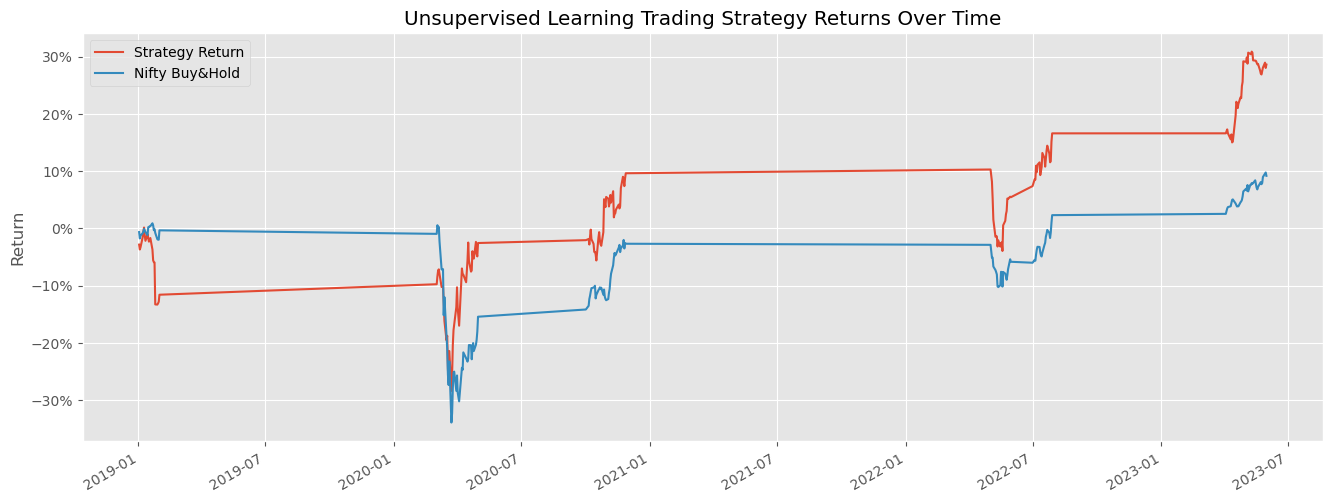

In [73]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

In [61]:
 def analysis(data, risk_free_rate=0.02):
        # Calculate daily returns
        daily_returns = data

        # Annualized mean return and standard deviation
        annualized_mean_return = daily_returns.mean() * 252
        annualized_std_dev = daily_returns.std() * np.sqrt(252)

        # Sharpe ratio
        sharpe_ratio = (annualized_mean_return - risk_free_rate) / annualized_std_dev

        # Drawdown
        previous_peaks = data.cummax()
        drawdown = data - previous_peaks
        max_drawdown = drawdown.min()

        # Sortino ratio
        downside_returns = daily_returns[daily_returns < 0]
        downside_std_dev = downside_returns.std() * np.sqrt(252)
        sortino_ratio = (annualized_mean_return - risk_free_rate) / downside_std_dev if downside_std_dev != 0 else float('inf')

        print("Sharpe Ratio:", sharpe_ratio)
        print("Max Drawdown:", max_drawdown)
        print("Sortino Ratio:", sortino_ratio)

In [62]:
final_df = portfolio_df['Strategy Return']

In [63]:
strategy_analysis = analysis(final_df)

Sharpe Ratio: 1.0742322803474802
Max Drawdown: -0.16394968994614167
Sortino Ratio: 1.5075380450521711
